In [1]:
import logging
# set seed
from pprint import pprint
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import utils as ut
import experiment as exp
import evaluation as ev
from pathlib import *
import torch
import random
import regex as re
import plot
import matplotlib.pyplot as plt
from sk_models import LocalWeightedRegression, PCR, setup_pls_models, PLSR, LinearRidge, CustomWrapper

In [2]:
seed = 1
torch.manual_seed(seed)
random.seed(seed + 1)
np.random.seed(seed + 2)

random_state = np.random.RandomState(seed)

In [3]:
#we need to set parametesr
file_name = "PLN7.csv"#"PLN7.csv"
id_cols =["sample_id"]#["db_id","sample_id"]#["sample_id"]
n_comps = [i for i in range(1,101)]

data_path = Path('D:/workspace/lazydeep/data/soil_data/')
log_path = Path("D:/workspace/lazydeep/experiments/0.00")

In [4]:
data_file = data_path / file_name
log_dir = log_path / re.sub(r'\.(?=csv$)[^.]+$', '',file_name)
if not log_dir.exists():
    log_dir.mkdir()
print(log_dir)

data = pd.read_csv(data_file)
nrow, ncol = data.shape
data = ut.sample_data(data,random_state)

n_features = ncol - 1-len(id_cols)
dataset = ut.TabularDataset(data,id_cols = id_cols, cat_cols=None, output_cols=None, ignore_cols= None)

# todo write a summary
#ut.setup_logger(logger_name="",file_name=log_dir/"log.txt")
ut.setup_logger(logger_name="summary",file_name=log_dir/"summary.txt")
#tb = SummaryWriter(log_dir/"tb")
print(log_dir)

D:\workspace\lazydeep\experiments\0.00\PLN7
D:\workspace\lazydeep\experiments\0.00\PLN7


In [5]:
#todo write a summary

ut.setup_logger(logger_name="summary",file_name=log_dir/"summary.txt")
summary_logger = logging.getLogger("summary")
eval = ev.CrossValEvaluation(preprocessing=None,tensorboard=None,time=True,random_state=random_state)

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [6]:
def plot_preds_and_res(preds,save_loc = "", name_lambda = lambda x:x,save_lambda = lambda x:x):
    for col_name in preds.columns:
        # plot predictions
        fig, ax = plot.scatter_plot(preds,col_name,"y",color_col="set_id",title= f"Predictions for {name_lambda(col_name)}")
        plt.savefig(save_loc/f"predictions_{save_lambda(col_name)}.png",bbox_inches='tight')
        plt.close()
        # plt.show()

        fig, ax = plot.residual_plot(preds, col_name, "y", color_col="set_id",title = f"Residuals for {name_lambda(col_name)}")
        plt.savefig(save_loc/f"residuals_{save_lambda(col_name)}.png", bbox_inches='tight')
        plt.close()

In [7]:
#PCR with and without whitening,scaling
#PLSR with and without scaling
lr_models = {
    'lr':CustomWrapper(LinearRidge(scale=False,ridge=False)),
    'lr_norm':CustomWrapper(LinearRidge(scale=True,ridge=False)),
    'ridge':CustomWrapper(LinearRidge(scale=False,ridge=True,ridge_param=1e-2)),
    'ridge_norm':CustomWrapper(LinearRidge(scale=True,ridge=True,ridge_param=1e-2))}

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass fit_intercept=0.01 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [8]:
local_logger_name = f"lr"

save_loc = log_dir/f"LR"
if not save_loc.exists():
    save_loc.mkdir()
ut.setup_logger(logger_name=local_logger_name,file_name=save_loc/f"{local_logger_name}_log.txt")
local_logger=logging.getLogger(local_logger_name)
scheme= ev.SKLearnScheme(logger=local_logger_name)

local_logger.info(f"Running LR")
scores_ls, preds_ls, model_states_ls ,train_time_ls, test_time_ls = eval.evaluate(lr_models,dataset,scheme,logger_name=local_logger_name)
scores_ls_final, _, model_states_ls_final , _, _= eval.build(lr_models,dataset,scheme,logger_name=local_logger_name)
for fold,nested in model_states_ls.items():
    for name,model in nested.items():
        model.save(save_loc/(f"{name}_{fold}"))
for name,model in model_states_ls_final.items():
    model.save(save_loc/(f"{name}_final"))

local_logger.info(f"Train times: {train_time_ls}")
local_logger.info(f"Test times: {test_time_ls}")
local_logger.info(f"Scores: {scores_ls}")
for key,value in ut.flip_dicts(scores_ls).items():
    local_logger.info(f"{key}: {value}")

Running LR'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of lr:188.769,lr_norm:188.769,ridge:292.0661,ridge_norm:189.077'
Tested (test) on 1667 instances with mean losses of: lr:205.5931,lr_norm:205.5931,ridge:311.9164,ridge_norm:205.4397'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of lr:190.469,lr_norm:190.469,ridge:291.8887,ridge_norm:190.794'
Tested (test) on 1667 instances with mean losses of: lr:209.3015,lr_norm:209.3014,ridge:288.481,ridge_norm:206.3096'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of lr:188.9606,lr_norm:188.9606,ridge:293.753,ridge_norm:189.3257'
Tested (test) on 1667 instances with mean l

In [9]:
scores_df_lr = None
scores_df_lr_final = None

#write preds
preds_ls.to_csv(save_loc/ (f"predictions_lr" + ".csv"), index=False)
#plot our figures
plot_preds_and_res(preds_ls,name_lambda=lambda x:f"{x}",save_lambda= lambda x:f"lr_{x}",save_loc=save_loc)
#save scores

flipped = ut.flip_dicts(scores_ls)
for name,record in flipped.items():
    record1 = {'model':f"{name}",'n_comp':"None"}
    if scores_df_lr is None:
        scores_df_lr =pd.DataFrame([{**record1,**record}])
    else:
        scores_df_lr=scores_df_lr.append([{**record1,**record}],ignore_index=True)

flipped = ut.flip_dicts(scores_ls_final)
for name,record in flipped.items():
    record1 = {'model':f"{name}",'n_comp':"None"}
    if scores_df_lr_final is None:
        scores_df_lr_final =pd.DataFrame([{**record1,**record}])
    else:
        scores_df_lr_final=scores_df_lr_final.append([{**record1,**record}],ignore_index=True)



C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [10]:
#setup
scores_df_pcr = None
scores_df_pcr_final = None

for n_component in n_comps:
    save_loc = log_dir/f"PCR_{n_component}"
    if not save_loc.exists():
        save_loc.mkdir()

    pca_models = {
    'pcr':CustomWrapper(PCR(n_component=n_component,scale=False,whiten=False)),
    'pcr_scale':CustomWrapper(PCR(n_component=n_component,scale=True,whiten=False)),
    'pcr_whiten':CustomWrapper(PCR(n_component=n_component,scale=False,whiten=True)),
    'pcr_s_w':CustomWrapper(PCR(n_component=n_component,scale=True,whiten=True)),
    }


    local_logger_name = f"pcr_{n_component}"
    ut.setup_logger(logger_name=local_logger_name,file_name=save_loc/f"{local_logger_name}_log.txt")
    local_logger = logging.getLogger(local_logger_name)

    scheme = ev.SKLearnScheme(logger=local_logger_name )

    local_logger.info(f"Running PCR with {n_component} components")
    scores_sk, preds_sk, model_states_sk , train_time_sk, test_time_sk = eval.evaluate(pca_models,dataset,scheme,logger_name=local_logger_name)
    scores_sk_final, _, model_states_sk_final , _, _= eval.build(pca_models,dataset,scheme,logger_name=local_logger_name)
    for fold,nested in model_states_sk.items():
        for name,model in nested.items():
            model.save(save_loc/(f"{name}_{fold}"))
    for name,model in model_states_sk_final.items():
        model.save(save_loc/(f"{name}_final"))
    local_logger.info(f"Train times: {train_time_sk}")
    local_logger.info(f"Test times: {test_time_sk}")
    local_logger.info(f"Scores: {scores_sk}")
    for key,value in ut.flip_dicts(scores_sk).items():
        local_logger.info(f"{key}: {value}")

    preds_sk.to_csv(save_loc/ (f"predictions_pcr" + ".csv"), index=False)
    plot_preds_and_res(preds_sk,name_lambda=lambda x:f"PCR with {x} components",save_lambda= lambda x:f"pcr_{x}",save_loc=save_loc)

    flipped = ut.flip_dicts(scores_sk)
    #add to scores
    for name,record in flipped.items():
        record1 = {'model':f"{name}",'n_comp':n_component}
        if scores_df_pcr is None:
            scores_df_pcr =pd.DataFrame([{**record1,**record}])
        else:
           scores_df_pcr=scores_df_pcr.append([{**record1,**record}],ignore_index=True)
        
    flipped = ut.flip_dicts(scores_sk_final)
    #add to scores
    for name,record in flipped.items():
        record1 = {'model':f"{name}",'n_comp':n_component}
        if scores_df_pcr_final is None:
            scores_df_pcr_final =pd.DataFrame([{**record1,**record}])
        else:
           scores_df_pcr_final=scores_df_pcr_final.append([{**record1,**record}],ignore_index=True)


Running PCR with 1 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of pcr:474.9977,pcr_scale:474.8186,pcr_whiten:474.9977,pcr_s_w:474.8186'
Tested (test) on 1667 instances with mean losses of: pcr:502.8145,pcr_scale:501.8417,pcr_whiten:502.8145,pcr_s_w:501.8417'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of pcr:491.3714,pcr_scale:491.8598,pcr_whiten:491.3714,pcr_s_w:491.8598'
Tested (test) on 1667 instances with mean losses of: pcr:455.8361,pcr_scale:454.8576,pcr_whiten:455.8361,pcr_s_w:454.8576'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of pcr:495.1329,pcr_scale:495.5397,pcr_whiten:495.1329,pcr_s_w:4

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 2 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of pcr:293.8868,pcr_scale:450.9182,pcr_whiten:293.8868,pcr_s_w:450.9182'
Tested (test) on 1667 instances with mean losses of: pcr:313.769,pcr_scale:474.8429,pcr_whiten:313.769,pcr_s_w:474.8429'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of pcr:293.5966,pcr_scale:468.1614,pcr_whiten:293.5966,pcr_s_w:468.1614'
Tested (test) on 1667 instances with mean losses of: pcr:290.3988,pcr_scale:426.6225,pcr_whiten:290.3988,pcr_s_w:426.6225'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of pcr:295.4306,pcr_scale:470.3444,pcr_whiten:295.4306,pcr_s_w:470

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 3 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of pcr:278.6409,pcr_scale:436.1719,pcr_whiten:278.3152,pcr_s_w:436.1719'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.03894e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: pcr:297.393,pcr_scale:459.1072,pcr_whiten:296.7689,pcr_s_w:459.1072'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of pcr:279.8943,pcr_scale:452.0668,pcr_whiten:279.6159,pcr_s_w:452.0668'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.15013e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: pcr:272.7871,pcr_scale:416.1344,pcr_whiten:271.745,pcr_s_w:416.1344'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of pcr:282.7915,pcr_scale:455.2407,pcr_whiten:282.5409,pcr_s_w:455.2407'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.17695e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: pcr:293.5169,pcr_scale:451.0904,pcr_whiten:292.6497,pcr_s_w:451.0904'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of pcr:281.6551,pcr_scale:445.8912,pcr_whiten:281.3177,pcr_s_w:445.8912'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.00338e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: pcr:275.0819,pcr_scale:442.5722,pcr_whiten:275.9409,pcr_s_w:442.5722'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of pcr:285.9916,pcr_scale:441.2021,pcr_whiten:285.5924,pcr_s_w:441.2021'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.83073e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: pcr:275.7729,pcr_scale:464.7934,pcr_whiten:276.0836,pcr_s_w:464.7934'
Building final model - Train 6666 - Test 1667'
Finished training SKLearn with a train loss of pcr:283.3849,pcr_scale:446.8947,pcr_whiten:283.1652,pcr_s_w:446.8947'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.79337e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: pcr:281.1303,pcr_scale:441.8371,pcr_whiten:280.9501,pcr_s_w:441.8371'
Train times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 297.39301080752523, 'pcr_scale': 459.10724235639157, 'pcr_whiten': 296.76886934195244, 'pcr_s_w': 459.1072492219583}, 'fold_1': {'pcr': 272.7870680985923, 'pcr_scale': 416.1343818895623, 'pcr_whiten': 271.7449614080341, 'pcr_s_w': 416.13438735783046}, 'fold_2': {'pcr': 293.5168848996077, 'pcr_scale': 451.09041901558345, 'pcr_whiten': 292.64971526787485, 'pcr_s_w': 451.0904294398758}, 'fold_3': {'pcr': 275.08193752204994, 'pcr_scale': 442.5721848587437, 'pcr_whiten': 275.94088770250687, 'pcr_s_w': 442.57216227361505}, 'fold_4': {'pcr': 275.7729140302772, 'pcr_scale': 464.79343202637625, 'pcr_whiten': 276.08364431141945, 'pcr_s_w': 464.7934263031502}, 'MSE': 

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 4 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of pcr:278.442,pcr_scale:428.1057,pcr_whiten:278.1105,pcr_s_w:428.1057'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.47142e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: pcr:296.9602,pcr_scale:453.7557,pcr_whiten:296.2582,pcr_s_w:453.7557'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of pcr:279.5228,pcr_scale:437.6372,pcr_whiten:279.2336,pcr_s_w:437.6372'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.49511e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: pcr:272.4521,pcr_scale:406.9595,pcr_whiten:271.4126,pcr_s_w:406.9595'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of pcr:281.5674,pcr_scale:444.4052,pcr_whiten:281.2833,pcr_s_w:444.4052'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.56752e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: pcr:291.7625,pcr_scale:439.8406,pcr_whiten:290.7931,pcr_s_w:439.8406'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of pcr:280.4755,pcr_scale:442.5857,pcr_whiten:280.1041,pcr_s_w:442.5857'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.47814e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: pcr:274.2938,pcr_scale:437.8495,pcr_whiten:275.2309,pcr_s_w:437.8494'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of pcr:285.1414,pcr_scale:437.4119,pcr_whiten:284.7177,pcr_s_w:437.4119'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.45361e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: pcr:275.5672,pcr_scale:458.9948,pcr_whiten:275.9652,pcr_s_w:458.9948'
Building final model - Train 6666 - Test 1667'
Finished training SKLearn with a train loss of pcr:282.574,pcr_scale:441.2084,pcr_whiten:282.3399,pcr_s_w:441.2084'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.30874e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: pcr:280.6298,pcr_scale:438.3691,pcr_whiten:280.4643,pcr_s_w:438.3691'
Train times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 296.9601607154855, 'pcr_scale': 453.7556929099506, 'pcr_whiten': 296.2582013218717, 'pcr_s_w': 453.75569185102734}, 'fold_1': {'pcr': 272.45210193588156, 'pcr_scale': 406.9595050147436, 'pcr_whiten': 271.41262885404495, 'pcr_s_w': 406.9595044217103}, 'fold_2': {'pcr': 291.76247785516875, 'pcr_scale': 439.8406007081977, 'pcr_whiten': 290.793083417112, 'pcr_s_w': 439.84061461859676}, 'fold_3': {'pcr': 274.29384405287965, 'pcr_scale': 437.8494648205623, 'pcr_whiten': 275.230909316301, 'pcr_s_w': 437.849448594598}, 'fold_4': {'pcr': 275.56715652634534, 'pcr_scale': 458.99479249697345, 'pcr_whiten': 275.9651682995649, 'pcr_s_w': 458.9947846657563}, 'MSE': {'pcr'

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 5 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of pcr:278.3472,pcr_scale:396.0822,pcr_whiten:277.9918,pcr_s_w:396.0822'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.30348e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: pcr:296.8895,pcr_scale:426.971,pcr_whiten:296.2204,pcr_s_w:426.971'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of pcr:279.2181,pcr_scale:410.779,pcr_whiten:278.8532,pcr_s_w:410.779'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.31258e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: pcr:272.5898,pcr_scale:384.4842,pcr_whiten:271.8559,pcr_s_w:384.4842'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of pcr:281.4952,pcr_scale:416.0928,pcr_whiten:281.1941,pcr_s_w:416.0928'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.33003e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: pcr:291.4725,pcr_scale:409.4681,pcr_whiten:290.3101,pcr_s_w:409.4682'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of pcr:280.4525,pcr_scale:413.1913,pcr_whiten:280.0754,pcr_s_w:413.1913'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.30806e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: pcr:274.2946,pcr_scale:396.4894,pcr_whiten:275.2302,pcr_s_w:396.4894'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of pcr:285.0712,pcr_scale:406.8855,pcr_whiten:284.6297,pcr_s_w:406.8855'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.29117e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: pcr:275.3812,pcr_scale:429.36,pcr_whiten:275.652,pcr_s_w:429.36'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.15235e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:282.4417,pcr_scale:412.4342,pcr_whiten:282.1855,pcr_s_w:412.4342'
Tested (test) on 1667 instances with mean losses of: pcr:280.9449,pcr_scale:407.9274,pcr_whiten:281.0334,pcr_s_w:407.9274'
Train times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 296.8894779638422, 'pcr_scale': 426.9709770592519, 'pcr_whiten': 296.22040512425644, 'pcr_s_w': 426.97098395331903}, 'fold_1': {'pcr': 272.58975969037283, 'pcr_scale': 384.4841635623812, 'pcr_whiten': 271.8558720249836, 'pcr_s_w': 384.484151419374}, 'fold_2': {'pcr': 291.4725192328147, 'pcr_scale': 409.4681353553411, 'pcr_whiten': 290.3101191475599, 'pcr_s_w': 409.46815032990696}, 'fold_3': {'pcr': 274.294555259987, 'pcr_scale': 396.4893827353392, 'pcr_whiten': 275.2301655515071, 'pcr_s_w': 396.4893942602684}, 'fold_4': {'pcr': 275.3811609255

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 6 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of pcr:278.1249,pcr_scale:395.9087,pcr_whiten:277.3824,pcr_s_w:395.9087'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=7.32886e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: pcr:296.8141,pcr_scale:426.4799,pcr_whiten:296.2848,pcr_s_w:426.4799'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of pcr:279.0773,pcr_scale:410.5706,pcr_whiten:278.4553,pcr_s_w:410.5706'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=7.28627e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: pcr:272.5594,pcr_scale:384.919,pcr_whiten:272.0102,pcr_s_w:384.919'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of pcr:281.154,pcr_scale:413.8981,pcr_whiten:280.2356,pcr_s_w:413.8981'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=7.25739e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: pcr:291.1691,pcr_scale:407.7238,pcr_whiten:289.5222,pcr_s_w:407.7238'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of pcr:280.3795,pcr_scale:409.5804,pcr_whiten:279.8732,pcr_s_w:409.5804'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=7.27972e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: pcr:274.2221,pcr_scale:395.4393,pcr_whiten:275.0618,pcr_s_w:395.4394'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of pcr:285.0639,pcr_scale:406.7663,pcr_whiten:284.6093,pcr_s_w:406.7663'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=7.21908e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: pcr:275.339,pcr_scale:429.7243,pcr_whiten:275.4436,pcr_s_w:429.7242'
Building final model - Train 6666 - Test 1667'
Finished training SKLearn with a train loss of pcr:282.2675,pcr_scale:411.1402,pcr_whiten:281.7811,pcr_s_w:411.1402'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.78608e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: pcr:280.785,pcr_scale:407.019,pcr_whiten:280.6499,pcr_s_w:407.019'
Train times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 296.81406444165236, 'pcr_scale': 426.4799233594164, 'pcr_whiten': 296.28475019041935, 'pcr_s_w': 426.4799304107351}, 'fold_1': {'pcr': 272.55941066656044, 'pcr_scale': 384.9189752387504, 'pcr_whiten': 272.0102050288418, 'pcr_s_w': 384.91896265531204}, 'fold_2': {'pcr': 291.16914811086446, 'pcr_scale': 407.7237872868109, 'pcr_whiten': 289.52217868693674, 'pcr_s_w': 407.7237965257881}, 'fold_3': {'pcr': 274.22210464628466, 'pcr_scale': 395.439349597157, 'pcr_whiten': 275.0617582738728, 'pcr_s_w': 395.43935695162753}, 'fold_4': {'pcr': 275.33896579898743, 'pcr_scale': 429.72425813787754, 'pcr_whiten': 275.4436234560036, 'pcr_s_w': 429.7242327159584}, 'MSE': {'pcr

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 7 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of pcr:271.8574,pcr_scale:393.7602,pcr_whiten:257.7299,pcr_s_w:393.7602'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=7.07809e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: pcr:292.3009,pcr_scale:424.2853,pcr_whiten:285.3409,pcr_s_w:424.2853'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of pcr:272.9306,pcr_scale:405.3396,pcr_whiten:259.102,pcr_s_w:405.3396'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=7.08997e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: pcr:266.6109,pcr_scale:378.8775,pcr_whiten:252.6859,pcr_s_w:378.8775'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of pcr:276.0998,pcr_scale:407.3016,pcr_whiten:264.3332,pcr_s_w:407.3016'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=7.05099e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: pcr:285.38,pcr_scale:399.8871,pcr_whiten:268.497,pcr_s_w:399.8871'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of pcr:275.8764,pcr_scale:401.1372,pcr_whiten:265.3009,pcr_s_w:401.1372'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=7.00194e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: pcr:268.2247,pcr_scale:390.595,pcr_whiten:252.8612,pcr_s_w:390.595'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of pcr:279.992,pcr_scale:390.0732,pcr_whiten:268.0269,pcr_s_w:390.0732'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.95268e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: pcr:270.6746,pcr_scale:404.4648,pcr_whiten:261.17,pcr_s_w:404.4648'
Building final model - Train 6666 - Test 1667'
Finished training SKLearn with a train loss of pcr:276.1659,pcr_scale:393.6153,pcr_whiten:265.525,pcr_s_w:393.6153'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.5235e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: pcr:275.5567,pcr_scale:386.6523,pcr_whiten:267.2994,pcr_s_w:386.6523'
Train times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 292.3009102151661, 'pcr_scale': 424.2853333832659, 'pcr_whiten': 285.3409006317111, 'pcr_s_w': 424.28533449333537}, 'fold_1': {'pcr': 266.610903449241, 'pcr_scale': 378.8775112247775, 'pcr_whiten': 252.68585633186436, 'pcr_s_w': 378.8774983236023}, 'fold_2': {'pcr': 285.3799572674007, 'pcr_scale': 399.88714069476833, 'pcr_whiten': 268.4970211529171, 'pcr_s_w': 399.88714656593703}, 'fold_3': {'pcr': 268.2247436370922, 'pcr_scale': 390.5949737834817, 'pcr_whiten': 252.86123380699547, 'pcr_s_w': 390.5949743056796}, 'fold_4': {'pcr': 270.6745643376856, 'pcr_scale': 404.4648149536678, 'pcr_whiten': 261.1699858458324, 'pcr_s_w': 404.4647974750619}, 'MSE': {'pcr':

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 8 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of pcr:271.857,pcr_scale:384.1145,pcr_whiten:257.7283,pcr_s_w:384.1145'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.73485e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: pcr:292.2976,pcr_scale:415.076,pcr_whiten:285.3128,pcr_s_w:415.076'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of pcr:272.7507,pcr_scale:397.5499,pcr_whiten:258.3609,pcr_s_w:397.5499'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.73026e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: pcr:266.3729,pcr_scale:374.5575,pcr_whiten:252.1622,pcr_s_w:374.5575'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of pcr:275.9705,pcr_scale:405.5061,pcr_whiten:263.7044,pcr_s_w:405.5061'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.53419e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: pcr:285.3574,pcr_scale:398.1719,pcr_whiten:268.8662,pcr_s_w:398.1719'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of pcr:275.8521,pcr_scale:400.6731,pcr_whiten:265.1661,pcr_s_w:400.6731'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.42847e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: pcr:268.1696,pcr_scale:391.1501,pcr_whiten:252.4958,pcr_s_w:391.1501'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of pcr:279.9763,pcr_scale:384.4992,pcr_whiten:267.9448,pcr_s_w:384.4992'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.44595e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: pcr:270.6297,pcr_scale:394.0512,pcr_whiten:260.6762,pcr_s_w:394.0512'
Building final model - Train 6666 - Test 1667'
Finished training SKLearn with a train loss of pcr:276.1264,pcr_scale:393.6039,pcr_whiten:265.3579,pcr_s_w:393.6039'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.99386e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: pcr:275.5334,pcr_scale:386.7244,pcr_whiten:267.2917,pcr_s_w:386.7244'
Train times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 292.29760689386643, 'pcr_scale': 415.0759597927625, 'pcr_whiten': 285.3127631028384, 'pcr_s_w': 415.07596561977624}, 'fold_1': {'pcr': 266.3728923099899, 'pcr_scale': 374.55748134993576, 'pcr_whiten': 252.1621959918144, 'pcr_s_w': 374.5574696208551}, 'fold_2': {'pcr': 285.3573628104919, 'pcr_scale': 398.1718714503388, 'pcr_whiten': 268.8662351659398, 'pcr_s_w': 398.17187606146763}, 'fold_3': {'pcr': 268.16961706314834, 'pcr_scale': 391.1501006988046, 'pcr_whiten': 252.4957733364264, 'pcr_s_w': 391.1501008631151}, 'fold_4': {'pcr': 270.62970127037937, 'pcr_scale': 394.0512133602002, 'pcr_whiten': 260.6762215798951, 'pcr_s_w': 394.05120229873387}, 'MSE': {'pc

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 9 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of pcr:271.5596,pcr_scale:374.4583,pcr_whiten:255.946,pcr_s_w:374.4583'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.39973e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: pcr:291.8889,pcr_scale:406.5821,pcr_whiten:283.1124,pcr_s_w:406.5821'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of pcr:272.742,pcr_scale:372.5248,pcr_whiten:258.308,pcr_s_w:372.5248'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.40627e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: pcr:266.3371,pcr_scale:358.7487,pcr_whiten:251.7706,pcr_s_w:358.7487'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of pcr:275.0263,pcr_scale:356.2383,pcr_whiten:257.404,pcr_s_w:356.2383'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.31615e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: pcr:284.6972,pcr_scale:346.8919,pcr_whiten:265.5694,pcr_s_w:346.8919'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of pcr:274.3667,pcr_scale:361.2242,pcr_whiten:254.9691,pcr_s_w:361.2242'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.29706e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: pcr:267.0058,pcr_scale:354.3326,pcr_whiten:247.6461,pcr_s_w:354.3326'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of pcr:279.465,pcr_scale:349.3188,pcr_whiten:264.4981,pcr_s_w:349.3188'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.2769e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: pcr:270.0166,pcr_scale:356.8664,pcr_whiten:256.9544,pcr_s_w:356.8664'
Building final model - Train 6666 - Test 1667'
Finished training SKLearn with a train loss of pcr:274.5057,pcr_scale:349.868,pcr_whiten:256.3729,pcr_s_w:349.868'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.82203e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: pcr:273.6978,pcr_scale:339.8699,pcr_whiten:255.5027,pcr_s_w:339.8699'
Train times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 291.88887013407896, 'pcr_scale': 406.5820978693102, 'pcr_whiten': 283.11241414985284, 'pcr_s_w': 406.5820864079393}, 'fold_1': {'pcr': 266.3370700428957, 'pcr_scale': 358.74873098484284, 'pcr_whiten': 251.77059961056224, 'pcr_s_w': 358.7487316480526}, 'fold_2': {'pcr': 284.69724236682674, 'pcr_scale': 346.8918751622212, 'pcr_whiten': 265.5694468513398, 'pcr_s_w': 346.89188001544386}, 'fold_3': {'pcr': 267.0057564929737, 'pcr_scale': 354.33262480397036, 'pcr_whiten': 247.64610748472808, 'pcr_s_w': 354.33262434193}, 'fold_4': {'pcr': 270.016569880115, 'pcr_scale': 356.86637586141615, 'pcr_whiten': 256.95440054921704, 'pcr_s_w': 356.86635376999186}, 'MSE': {'p

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 10 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of pcr:271.0699,pcr_scale:322.4803,pcr_whiten:252.6745,pcr_s_w:322.4803'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.33466e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: pcr:291.1905,pcr_scale:357.8168,pcr_whiten:277.6408,pcr_s_w:357.8168'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of pcr:272.1843,pcr_scale:336.4427,pcr_whiten:254.3843,pcr_s_w:336.4427'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.32347e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: pcr:266.0899,pcr_scale:319.821,pcr_whiten:247.9814,pcr_s_w:319.8211'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of pcr:274.8623,pcr_scale:349.4645,pcr_whiten:256.1621,pcr_s_w:349.4645'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.25099e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: pcr:284.5053,pcr_scale:355.5692,pcr_whiten:263.2041,pcr_s_w:355.5692'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of pcr:274.3388,pcr_scale:283.3256,pcr_whiten:254.7319,pcr_s_w:283.3256'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.19596e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: pcr:267.0471,pcr_scale:275.797,pcr_whiten:249.1831,pcr_s_w:275.797'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of pcr:278.5854,pcr_scale:317.8561,pcr_whiten:258.1413,pcr_s_w:317.8561'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.24043e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: pcr:269.007,pcr_scale:319.8486,pcr_whiten:251.2949,pcr_s_w:319.8486'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.77067e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:274.3938,pcr_scale:292.843,pcr_whiten:255.6852,pcr_s_w:292.843'
Tested (test) on 1667 instances with mean losses of: pcr:273.5991,pcr_scale:285.4418,pcr_whiten:254.1826,pcr_s_w:285.4418'
Train times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 291.1905310816822, 'pcr_scale': 357.8168177609233, 'pcr_whiten': 277.6407692995115, 'pcr_s_w': 357.8168221739084}, 'fold_1': {'pcr': 266.0898809548692, 'pcr_scale': 319.8210463592421, 'pcr_whiten': 247.98139351153011, 'pcr_s_w': 319.82105877609985}, 'fold_2': {'pcr': 284.5052652211509, 'pcr_scale': 355.5692226618484, 'pcr_whiten': 263.2041317057662, 'pcr_s_w': 355.5692397881414}, 'fold_3': {'pcr': 267.0470631309996, 'pcr_scale': 275.7970425446529, 'pcr_whiten': 249.18306024377162, 'pcr_s_w': 275.79703443215516}, 'fold_4': {'pcr': 269.0069816951

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 11 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of pcr:270.4441,pcr_scale:269.7969,pcr_whiten:246.2153,pcr_s_w:269.7969'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.14678e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: pcr:290.1215,pcr_scale:301.9481,pcr_whiten:262.9137,pcr_s_w:301.9481'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of pcr:272.0294,pcr_scale:270.4238,pcr_whiten:253.0075,pcr_s_w:270.4238'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.21694e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: pcr:265.8916,pcr_scale:260.2105,pcr_whiten:245.8877,pcr_s_w:260.2105'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.19926e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:274.7949,pcr_scale:272.0737,pcr_whiten:255.5877,pcr_s_w:272.0737'
Tested (test) on 1667 instances with mean losses of: pcr:284.4075,pcr_scale:275.9271,pcr_whiten:262.3738,pcr_s_w:275.9271'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of pcr:273.7662,pcr_scale:272.5128,pcr_whiten:249.1868,pcr_s_w:272.5128'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.14637e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: pcr:266.8623,pcr_scale:264.1699,pcr_whiten:250.2686,pcr_s_w:264.1699'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of pcr:278.1816,pcr_scale:281.004,pcr_whiten:253.7434,pcr_s_w:281.004'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.07841e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: pcr:268.7487,pcr_scale:276.8465,pcr_whiten:249.5769,pcr_s_w:276.8465'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.70601e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:274.2704,pcr_scale:279.3826,pcr_whiten:254.8005,pcr_s_w:279.3826'
Tested (test) on 1667 instances with mean losses of: pcr:273.4905,pcr_scale:275.0721,pcr_whiten:254.8182,pcr_s_w:275.0721'
Train times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 290.12149675464093, 'pcr_scale': 301.94813265237, 'pcr_whiten': 262.9136616821542, 'pcr_s_w': 301.948142282363}, 'fold_1': {'pcr': 265.8916200040477, 'pcr_scale': 260.2105159248117, 'pcr_whiten': 245.8876605987752, 'pcr_s_w': 260.21052486110113}, 'fold_2': {'pcr': 284.40747889436955, 'pcr_scale': 275.9271106490382, 'pcr_whiten': 262.37378221238606, 'pcr_s_w': 275.92709834549595}, 'fold_3': {'pcr': 266.8623097189346, 'pcr_scale': 264.1699059418386, 'pcr_whiten': 250.26859131317923, 'pcr_s_w': 264.1698995075346}, 'fold_4': {'pcr': 268.748746612

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 12 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of pcr:270.4082,pcr_scale:269.2347,pcr_whiten:245.8156,pcr_s_w:269.2347'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.12292e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: pcr:290.1171,pcr_scale:301.2734,pcr_whiten:261.9557,pcr_s_w:301.2734'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of pcr:271.7528,pcr_scale:270.4045,pcr_whiten:249.9746,pcr_s_w:270.4045'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.14375e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: pcr:265.5846,pcr_scale:260.2829,pcr_whiten:242.2702,pcr_s_w:260.2829'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of pcr:274.5119,pcr_scale:270.6495,pcr_whiten:252.3183,pcr_s_w:270.6495'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.09329e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: pcr:284.1672,pcr_scale:276.5426,pcr_whiten:258.7752,pcr_s_w:276.5427'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of pcr:273.7307,pcr_scale:269.9787,pcr_whiten:248.6731,pcr_s_w:269.9787'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.03311e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: pcr:266.8499,pcr_scale:258.0847,pcr_whiten:252.4071,pcr_s_w:258.0847'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of pcr:278.0217,pcr_scale:280.2831,pcr_whiten:251.9034,pcr_s_w:280.2831'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.06199e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: pcr:268.6053,pcr_scale:278.3293,pcr_whiten:250.1759,pcr_s_w:278.3293'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.6359e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:273.9528,pcr_scale:274.4532,pcr_whiten:251.996,pcr_s_w:274.4532'
Tested (test) on 1667 instances with mean losses of: pcr:273.1863,pcr_scale:272.1961,pcr_whiten:252.3469,pcr_s_w:272.1961'
Train times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 290.11714530765454, 'pcr_scale': 301.27339114165835, 'pcr_whiten': 261.955690850582, 'pcr_s_w': 301.2733932526784}, 'fold_1': {'pcr': 265.5845505159428, 'pcr_scale': 260.28291015790904, 'pcr_whiten': 242.2701589175492, 'pcr_s_w': 260.2829190493705}, 'fold_2': {'pcr': 284.1672421296324, 'pcr_scale': 276.5426470067841, 'pcr_whiten': 258.7751801984155, 'pcr_s_w': 276.5426586014647}, 'fold_3': {'pcr': 266.8498631304265, 'pcr_scale': 258.084682602564, 'pcr_whiten': 252.40711976402375, 'pcr_s_w': 258.0846950187596}, 'fold_4': {'pcr': 268.60533089438

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 13 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of pcr:270.1616,pcr_scale:268.6058,pcr_whiten:241.8832,pcr_s_w:268.6081'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.03358e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: pcr:289.8521,pcr_scale:300.2589,pcr_whiten:258.9547,pcr_s_w:300.263'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of pcr:271.7436,pcr_scale:270.122,pcr_whiten:249.8287,pcr_s_w:270.1222'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.05045e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: pcr:265.5838,pcr_scale:260.6802,pcr_whiten:243.2377,pcr_s_w:260.6799'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of pcr:274.2515,pcr_scale:269.3409,pcr_whiten:248.2564,pcr_s_w:269.3408'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.01987e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: pcr:283.9497,pcr_scale:277.1945,pcr_whiten:258.9942,pcr_s_w:277.194'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of pcr:273.7305,pcr_scale:251.4131,pcr_whiten:248.6712,pcr_s_w:251.4109'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.00369e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: pcr:266.8477,pcr_scale:245.1354,pcr_whiten:252.308,pcr_s_w:245.1331'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of pcr:277.7977,pcr_scale:275.0158,pcr_whiten:248.1564,pcr_s_w:275.0138'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.97399e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: pcr:268.3591,pcr_scale:268.5049,pcr_whiten:252.0575,pcr_s_w:268.5036'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.5503e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:273.9449,pcr_scale:268.9633,pcr_whiten:251.8962,pcr_s_w:268.9624'
Tested (test) on 1667 instances with mean losses of: pcr:273.1733,pcr_scale:268.1527,pcr_whiten:251.9274,pcr_s_w:268.1516'
Train times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 289.8520552411446, 'pcr_scale': 300.2588749362295, 'pcr_whiten': 258.9546789348623, 'pcr_s_w': 300.2629825106564}, 'fold_1': {'pcr': 265.58384401078143, 'pcr_scale': 260.68020360730156, 'pcr_whiten': 243.23769422652944, 'pcr_s_w': 260.67988864723225}, 'fold_2': {'pcr': 283.9496881211186, 'pcr_scale': 277.19446400686724, 'pcr_whiten': 258.99415959242134, 'pcr_s_w': 277.19398502318717}, 'fold_3': {'pcr': 266.84768667998134, 'pcr_scale': 245.13544198518824, 'pcr_whiten': 252.30799494314735, 'pcr_s_w': 245.1330518162858}, 'fold_4': {'pcr': 268.35

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 14 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of pcr:270.1333,pcr_scale:252.0873,pcr_whiten:241.3459,pcr_s_w:252.0884'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.00196e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: pcr:289.7955,pcr_scale:270.9795,pcr_whiten:257.2051,pcr_s_w:270.9809'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of pcr:271.4398,pcr_scale:254.9166,pcr_whiten:244.5528,pcr_s_w:254.9164'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.0331e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: pcr:265.3528,pcr_scale:251.431,pcr_whiten:240.6745,pcr_s_w:251.4306'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of pcr:274.1362,pcr_scale:249.2405,pcr_whiten:246.2482,pcr_s_w:249.2374'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.99851e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: pcr:283.8426,pcr_scale:258.0057,pcr_whiten:255.6168,pcr_s_w:258.0035'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of pcr:273.7255,pcr_scale:244.1799,pcr_whiten:248.5715,pcr_s_w:244.1756'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.97348e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: pcr:266.844,pcr_scale:239.8715,pcr_whiten:253.1117,pcr_s_w:239.8788'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of pcr:277.7346,pcr_scale:256.67,pcr_whiten:246.9899,pcr_s_w:256.6765'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.95594e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: pcr:268.2912,pcr_scale:252.6679,pcr_whiten:249.8179,pcr_s_w:252.6808'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.53068e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:273.7651,pcr_scale:253.7024,pcr_whiten:249.3856,pcr_s_w:253.7063'
Tested (test) on 1667 instances with mean losses of: pcr:272.9953,pcr_scale:250.6707,pcr_whiten:250.1867,pcr_s_w:250.678'
Train times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 289.7955115963376, 'pcr_scale': 270.9795359073531, 'pcr_whiten': 257.20512386332376, 'pcr_s_w': 270.98094466442564}, 'fold_1': {'pcr': 265.3527935047096, 'pcr_scale': 251.43103229288982, 'pcr_whiten': 240.67452134203305, 'pcr_s_w': 251.43063868129585}, 'fold_2': {'pcr': 283.8426100322511, 'pcr_scale': 258.0056502627703, 'pcr_whiten': 255.6168132281969, 'pcr_s_w': 258.0034625430669}, 'fold_3': {'pcr': 266.8439721362055, 'pcr_scale': 239.8714901479386, 'pcr_whiten': 253.11166816147872, 'pcr_s_w': 239.8788438425601}, 'fold_4': {'pcr': 268.2911561

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 15 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of pcr:270.1286,pcr_scale:247.5092,pcr_whiten:241.2399,pcr_s_w:247.5121'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.97493e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: pcr:289.7906,pcr_scale:261.7657,pcr_whiten:257.4372,pcr_s_w:261.7694'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of pcr:271.2311,pcr_scale:241.9709,pcr_whiten:240.3314,pcr_s_w:241.9699'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.00722e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: pcr:265.0731,pcr_scale:241.4412,pcr_whiten:235.6077,pcr_s_w:241.4385'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of pcr:273.9134,pcr_scale:241.1541,pcr_whiten:241.4298,pcr_s_w:241.1569'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.96316e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: pcr:283.6109,pcr_scale:256.773,pcr_whiten:254.0017,pcr_s_w:256.7817'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of pcr:273.5243,pcr_scale:242.8037,pcr_whiten:243.7335,pcr_s_w:242.8032'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.94533e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: pcr:266.6516,pcr_scale:236.5165,pcr_whiten:248.053,pcr_s_w:236.5046'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of pcr:277.7286,pcr_scale:252.6115,pcr_whiten:246.8492,pcr_s_w:252.6097'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.92018e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: pcr:268.2764,pcr_scale:244.8998,pcr_whiten:250.5141,pcr_s_w:244.8962'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.5015e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:273.4763,pcr_scale:245.1938,pcr_whiten:244.532,pcr_s_w:245.1916'
Tested (test) on 1667 instances with mean losses of: pcr:272.7559,pcr_scale:240.9406,pcr_whiten:244.5916,pcr_s_w:240.9242'
Train times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 289.7906301480109, 'pcr_scale': 261.76573198302697, 'pcr_whiten': 257.43721813154394, 'pcr_s_w': 261.7693505023972}, 'fold_1': {'pcr': 265.0730846488432, 'pcr_scale': 241.44121324796106, 'pcr_whiten': 235.6076916156982, 'pcr_s_w': 241.43848513181428}, 'fold_2': {'pcr': 283.61090569489517, 'pcr_scale': 256.7730326465657, 'pcr_whiten': 254.00165783533024, 'pcr_s_w': 256.7817355746603}, 'fold_3': {'pcr': 266.65155079507144, 'pcr_scale': 236.51645351222513, 'pcr_whiten': 248.05301152539244, 'pcr_s_w': 236.5045918565609}, 'fold_4': {'pcr': 268.2763

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 16 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of pcr:270.1241,pcr_scale:242.5226,pcr_whiten:241.1231,pcr_s_w:242.5239'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.95565e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: pcr:289.7874,pcr_scale:250.7611,pcr_whiten:257.3397,pcr_s_w:250.7619'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of pcr:271.1608,pcr_scale:241.5736,pcr_whiten:238.702,pcr_s_w:241.5764'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.98738e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: pcr:265.0194,pcr_scale:242.3967,pcr_whiten:235.4027,pcr_s_w:242.4006'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of pcr:273.6994,pcr_scale:240.0089,pcr_whiten:236.6559,pcr_s_w:240.0258'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.9588e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: pcr:283.4212,pcr_scale:256.2535,pcr_whiten:249.4569,pcr_s_w:256.2619'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of pcr:273.2802,pcr_scale:236.0816,pcr_whiten:236.4996,pcr_s_w:236.0772'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.9211e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: pcr:266.3615,pcr_scale:233.9598,pcr_whiten:236.2647,pcr_s_w:233.9653'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of pcr:277.7267,pcr_scale:243.9052,pcr_whiten:246.7945,pcr_s_w:244.0133'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.89491e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: pcr:268.2681,pcr_scale:237.7395,pcr_whiten:249.3896,pcr_s_w:237.7452'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.48689e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:273.197,pcr_scale:244.9981,pcr_whiten:239.2996,pcr_s_w:244.9912'
Tested (test) on 1667 instances with mean losses of: pcr:272.498,pcr_scale:240.5309,pcr_whiten:241.7721,pcr_s_w:240.5233'
Train times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 289.7873898035376, 'pcr_scale': 250.76108521381065, 'pcr_whiten': 257.33971364928243, 'pcr_s_w': 250.76186356660105}, 'fold_1': {'pcr': 265.01942163967067, 'pcr_scale': 242.39666491249116, 'pcr_whiten': 235.40268309935703, 'pcr_s_w': 242.40058746698824}, 'fold_2': {'pcr': 283.4211631109293, 'pcr_scale': 256.25354498609715, 'pcr_whiten': 249.45693461011135, 'pcr_s_w': 256.2619395772327}, 'fold_3': {'pcr': 266.3614846275186, 'pcr_scale': 233.95977232076362, 'pcr_whiten': 236.26470636421735, 'pcr_s_w': 233.96526315902923}, 'fold_4': {'pcr': 268.26

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 17 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of pcr:270.0023,pcr_scale:242.4754,pcr_whiten:237.4051,pcr_s_w:242.477'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.93953e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: pcr:289.6249,pcr_scale:250.8885,pcr_whiten:249.8974,pcr_s_w:250.8892'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of pcr:271.0934,pcr_scale:241.229,pcr_whiten:236.9098,pcr_s_w:241.2375'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.9702e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: pcr:264.9214,pcr_scale:242.5932,pcr_whiten:231.1693,pcr_s_w:242.5974'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of pcr:273.6314,pcr_scale:233.4674,pcr_whiten:234.6926,pcr_s_w:233.5041'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.92715e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: pcr:283.3716,pcr_scale:254.5025,pcr_whiten:251.1299,pcr_s_w:254.4777'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of pcr:273.225,pcr_scale:233.7152,pcr_whiten:234.5594,pcr_s_w:233.7257'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.90505e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: pcr:266.2438,pcr_scale:232.6993,pcr_whiten:232.3813,pcr_s_w:232.7229'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of pcr:277.5292,pcr_scale:243.6518,pcr_whiten:240.8425,pcr_s_w:243.6531'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.89123e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: pcr:268.0996,pcr_scale:239.3911,pcr_whiten:236.122,pcr_s_w:239.3886'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.46774e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:273.1311,pcr_scale:240.6554,pcr_whiten:237.8418,pcr_s_w:240.6534'
Tested (test) on 1667 instances with mean losses of: pcr:272.4072,pcr_scale:237.89,pcr_whiten:240.3333,pcr_s_w:237.8873'
Train times: {'fold_0': 0, 'fold_1': 1, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.2}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 289.62493094836833, 'pcr_scale': 250.88851398357562, 'pcr_whiten': 249.89742596219415, 'pcr_s_w': 250.88921984608774}, 'fold_1': {'pcr': 264.9214282092765, 'pcr_scale': 242.5931843329608, 'pcr_whiten': 231.16932957902023, 'pcr_s_w': 242.59744878595754}, 'fold_2': {'pcr': 283.37157953404625, 'pcr_scale': 254.5025020294276, 'pcr_whiten': 251.12985135079768, 'pcr_s_w': 254.47768517865924}, 'fold_3': {'pcr': 266.24381978992113, 'pcr_scale': 232.6992679173087, 'pcr_whiten': 232.38126357192775, 'pcr_s_w': 232.72291784939455}, 'fold_4': {'pcr': 268.09

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 18 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of pcr:270.0022,pcr_scale:241.042,pcr_whiten:237.4016,pcr_s_w:241.041'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.89943e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: pcr:289.6242,pcr_scale:248.2556,pcr_whiten:249.8418,pcr_s_w:248.251'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of pcr:271.0912,pcr_scale:237.4132,pcr_whiten:236.8187,pcr_s_w:237.3921'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.92592e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: pcr:264.9196,pcr_scale:234.6772,pcr_whiten:231.2792,pcr_s_w:234.6513'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of pcr:273.6314,pcr_scale:231.739,pcr_whiten:234.6924,pcr_s_w:231.7502'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.89332e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: pcr:283.3718,pcr_scale:257.491,pcr_whiten:251.1421,pcr_s_w:257.5011'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of pcr:273.2146,pcr_scale:233.683,pcr_whiten:234.0557,pcr_s_w:233.6901'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.8815e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: pcr:266.2381,pcr_scale:232.8356,pcr_whiten:233.3685,pcr_s_w:232.8287'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of pcr:277.5291,pcr_scale:241.8617,pcr_whiten:240.8406,pcr_s_w:241.862'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85359e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: pcr:268.0987,pcr_scale:237.8108,pcr_whiten:236.0911,pcr_s_w:237.8381'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.43102e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:273.1309,pcr_scale:239.7885,pcr_whiten:237.8346,pcr_s_w:239.7884'
Tested (test) on 1667 instances with mean losses of: pcr:272.4061,pcr_scale:235.6822,pcr_whiten:240.2323,pcr_s_w:235.6899'
Train times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 289.62416313707365, 'pcr_scale': 248.25557629457322, 'pcr_whiten': 249.84175825069622, 'pcr_s_w': 248.2509655883103}, 'fold_1': {'pcr': 264.9195873915292, 'pcr_scale': 234.67719793280602, 'pcr_whiten': 231.27923388100484, 'pcr_s_w': 234.65131385962428}, 'fold_2': {'pcr': 283.3717626845421, 'pcr_scale': 257.4910360342688, 'pcr_whiten': 251.1420699798262, 'pcr_s_w': 257.50106670036007}, 'fold_3': {'pcr': 266.23806197878986, 'pcr_scale': 232.83561574077626, 'pcr_whiten': 233.36851763486578, 'pcr_s_w': 232.82867588399003}, 'fold_4': {'pcr': 268.0

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 19 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of pcr:269.9966,pcr_scale:237.999,pcr_whiten:237.0951,pcr_s_w:237.9796'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.89614e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: pcr:289.6235,pcr_scale:244.3444,pcr_whiten:249.6841,pcr_s_w:244.3318'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of pcr:271.0187,pcr_scale:236.8948,pcr_whiten:232.7299,pcr_s_w:236.9122'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.90947e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: pcr:264.8485,pcr_scale:234.5856,pcr_whiten:231.4571,pcr_s_w:234.5954'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of pcr:273.5346,pcr_scale:231.6884,pcr_whiten:229.709,pcr_s_w:231.6931'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.88109e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: pcr:283.3334,pcr_scale:257.4941,pcr_whiten:246.4529,pcr_s_w:257.4955'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of pcr:273.0724,pcr_scale:232.635,pcr_whiten:226.2356,pcr_s_w:232.6521'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.87402e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: pcr:266.1284,pcr_scale:231.5229,pcr_whiten:239.6766,pcr_s_w:231.5337'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of pcr:277.5191,pcr_scale:241.7399,pcr_whiten:240.2709,pcr_s_w:241.7322'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84465e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: pcr:268.0787,pcr_scale:234.9705,pcr_whiten:235.0606,pcr_s_w:234.9422'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.42289e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:273.1277,pcr_scale:238.7387,pcr_whiten:237.7133,pcr_s_w:238.7376'
Tested (test) on 1667 instances with mean losses of: pcr:272.3997,pcr_scale:235.4619,pcr_whiten:239.3648,pcr_s_w:235.4641'
Train times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 289.6234816247263, 'pcr_scale': 244.34440595307038, 'pcr_whiten': 249.6841241712165, 'pcr_s_w': 244.3317785566078}, 'fold_1': {'pcr': 264.8484984282567, 'pcr_scale': 234.58560627386393, 'pcr_whiten': 231.45711426726584, 'pcr_s_w': 234.59540047755172}, 'fold_2': {'pcr': 283.33340404515116, 'pcr_scale': 257.4941399000403, 'pcr_whiten': 246.45291154112633, 'pcr_s_w': 257.49550744940115}, 'fold_3': {'pcr': 266.12843594869696, 'pcr_scale': 231.52285098712312, 'pcr_whiten': 239.67659838930535, 'pcr_s_w': 231.53366821559837}, 'fold_4': {'pcr': 268.0

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 20 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of pcr:269.9612,pcr_scale:232.8799,pcr_whiten:234.9255,pcr_s_w:232.8361'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.88964e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: pcr:289.5571,pcr_scale:239.4191,pcr_whiten:244.3888,pcr_s_w:239.4427'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of pcr:271.0103,pcr_scale:233.8484,pcr_whiten:232.2086,pcr_s_w:233.8529'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.90463e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: pcr:264.8369,pcr_scale:234.0289,pcr_whiten:232.3283,pcr_s_w:234.0192'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of pcr:273.5241,pcr_scale:231.2779,pcr_whiten:229.0743,pcr_s_w:231.276'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.87237e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: pcr:283.3267,pcr_scale:255.6805,pcr_whiten:246.2321,pcr_s_w:255.6745'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of pcr:273.0696,pcr_scale:232.1594,pcr_whiten:226.0715,pcr_s_w:232.1489'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.87103e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: pcr:266.1272,pcr_scale:230.2403,pcr_whiten:237.1433,pcr_s_w:230.2249'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of pcr:277.4433,pcr_scale:240.7649,pcr_whiten:235.5168,pcr_s_w:240.7914'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.83937e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: pcr:267.9896,pcr_scale:237.1657,pcr_whiten:228.3878,pcr_s_w:237.1257'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.41536e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.994,pcr_scale:236.3061,pcr_whiten:231.7575,pcr_s_w:236.3228'
Tested (test) on 1667 instances with mean losses of: pcr:272.2509,pcr_scale:232.4815,pcr_whiten:231.2903,pcr_s_w:232.4884'
Train times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 289.55705867773446, 'pcr_scale': 239.41910518649445, 'pcr_whiten': 244.38878853089076, 'pcr_s_w': 239.44272637273494}, 'fold_1': {'pcr': 264.83686378331214, 'pcr_scale': 234.02892603545652, 'pcr_whiten': 232.32832882738836, 'pcr_s_w': 234.01923731395536}, 'fold_2': {'pcr': 283.3266590910221, 'pcr_scale': 255.68051283856767, 'pcr_whiten': 246.23211549066227, 'pcr_s_w': 255.67454040083138}, 'fold_3': {'pcr': 266.1271958365846, 'pcr_scale': 230.24032904391538, 'pcr_whiten': 237.14327223880161, 'pcr_s_w': 230.2248944354435}, 'fold_4': {'pcr': 267.

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 21 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.88235e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:269.9497,pcr_scale:232.8516,pcr_whiten:234.0966,pcr_s_w:232.8265'
Tested (test) on 1667 instances with mean losses of: pcr:289.5405,pcr_scale:239.3559,pcr_whiten:243.8973,pcr_s_w:239.3726'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of pcr:271.0062,pcr_scale:233.5839,pcr_whiten:231.9321,pcr_s_w:233.587'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.90087e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: pcr:264.8355,pcr_scale:234.4796,pcr_whiten:230.5644,pcr_s_w:234.4788'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of pcr:273.5235,pcr_scale:230.2983,pcr_whiten:229.0358,pcr_s_w:230.3065'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.87082e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: pcr:283.3266,pcr_scale:254.0776,pcr_whiten:246.1913,pcr_s_w:254.1162'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of pcr:273.0635,pcr_scale:232.0257,pcr_whiten:225.6715,pcr_s_w:232.018'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.86552e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: pcr:266.119,pcr_scale:231.1505,pcr_whiten:240.9731,pcr_s_w:231.2392'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of pcr:277.4331,pcr_scale:236.3334,pcr_whiten:234.7656,pcr_s_w:236.3432'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.83232e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: pcr:267.9756,pcr_scale:253.2749,pcr_whiten:227.7536,pcr_s_w:253.2327'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.41181e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.9935,pcr_scale:236.0624,pcr_whiten:231.7331,pcr_s_w:236.083'
Tested (test) on 1667 instances with mean losses of: pcr:272.249,pcr_scale:232.7352,pcr_whiten:231.4526,pcr_s_w:232.7203'
Train times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 289.5404856683802, 'pcr_scale': 239.3559291827976, 'pcr_whiten': 243.8973349895879, 'pcr_s_w': 239.37255974600106}, 'fold_1': {'pcr': 264.8355238433761, 'pcr_scale': 234.47955462314223, 'pcr_whiten': 230.56438109944992, 'pcr_s_w': 234.47876305330402}, 'fold_2': {'pcr': 283.3265632491435, 'pcr_scale': 254.0775565762682, 'pcr_whiten': 246.19132659652885, 'pcr_s_w': 254.116214950298}, 'fold_3': {'pcr': 266.11903779784024, 'pcr_scale': 231.15047590012017, 'pcr_whiten': 240.9731363530587, 'pcr_s_w': 231.23921150261438}, 'fold_4': {'pcr': 267.9755640

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 22 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of pcr:269.9133,pcr_scale:232.5395,pcr_whiten:230.8291,pcr_s_w:232.5146'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.87417e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: pcr:289.5085,pcr_scale:238.3812,pcr_whiten:243.5037,pcr_s_w:238.3576'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.89375e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:270.9743,pcr_scale:233.364,pcr_whiten:229.3729,pcr_s_w:233.3625'
Tested (test) on 1667 instances with mean losses of: pcr:264.8081,pcr_scale:233.8759,pcr_whiten:226.953,pcr_s_w:233.87'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of pcr:273.5061,pcr_scale:229.9627,pcr_whiten:227.7219,pcr_s_w:229.9571'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.86262e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: pcr:283.2927,pcr_scale:254.3827,pcr_whiten:242.6717,pcr_s_w:254.4868'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of pcr:273.0577,pcr_scale:231.9769,pcr_whiten:225.2026,pcr_s_w:231.9812'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85642e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: pcr:266.1137,pcr_scale:231.8007,pcr_whiten:236.9098,pcr_s_w:231.7822'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of pcr:277.4183,pcr_scale:236.3156,pcr_whiten:233.5137,pcr_s_w:236.3149'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82721e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: pcr:267.9727,pcr_scale:253.8493,pcr_whiten:226.4119,pcr_s_w:253.9556'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.40279e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.962,pcr_scale:236.0637,pcr_whiten:229.8662,pcr_s_w:236.0447'
Tested (test) on 1667 instances with mean losses of: pcr:272.2167,pcr_scale:232.8715,pcr_whiten:227.7307,pcr_s_w:232.7707'
Train times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 289.5085266083914, 'pcr_scale': 238.3811924635118, 'pcr_whiten': 243.50372340549438, 'pcr_s_w': 238.35759012796302}, 'fold_1': {'pcr': 264.8081092409403, 'pcr_scale': 233.8758920763712, 'pcr_whiten': 226.9529752940217, 'pcr_s_w': 233.8700115008531}, 'fold_2': {'pcr': 283.292652864935, 'pcr_scale': 254.38268016894955, 'pcr_whiten': 242.6716902648839, 'pcr_s_w': 254.48681047698227}, 'fold_3': {'pcr': 266.11366616470957, 'pcr_scale': 231.8007148720105, 'pcr_whiten': 236.90975330227573, 'pcr_s_w': 231.7822307797017}, 'fold_4': {'pcr': 267.97268402

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 23 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of pcr:269.9021,pcr_scale:232.1339,pcr_whiten:229.5806,pcr_s_w:232.1191'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.86777e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: pcr:289.5081,pcr_scale:238.4255,pcr_whiten:243.9137,pcr_s_w:238.4054'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.88826e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:270.9698,pcr_scale:233.2524,pcr_whiten:228.9586,pcr_s_w:233.2505'
Tested (test) on 1667 instances with mean losses of: pcr:264.8054,pcr_scale:233.4483,pcr_whiten:226.3452,pcr_s_w:233.4543'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of pcr:273.5049,pcr_scale:229.8935,pcr_whiten:227.6136,pcr_s_w:229.9312'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85729e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: pcr:283.2897,pcr_scale:253.8782,pcr_whiten:242.5394,pcr_s_w:253.9908'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85199e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:273.0512,pcr_scale:231.9061,pcr_whiten:224.6003,pcr_s_w:231.9085'
Tested (test) on 1666 instances with mean losses of: pcr:266.0991,pcr_scale:232.8054,pcr_whiten:243.0255,pcr_s_w:232.7805'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of pcr:277.4171,pcr_scale:235.4172,pcr_whiten:233.3842,pcr_s_w:235.4283'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.81994e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: pcr:267.974,pcr_scale:252.1635,pcr_whiten:226.657,pcr_s_w:252.0763'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.39906e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.9532,pcr_scale:235.9323,pcr_whiten:229.2883,pcr_s_w:235.9575'
Tested (test) on 1667 instances with mean losses of: pcr:272.2189,pcr_scale:232.4151,pcr_whiten:228.5951,pcr_s_w:232.4084'
Train times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 289.5081222201761, 'pcr_scale': 238.4255255948108, 'pcr_whiten': 243.91370894221959, 'pcr_s_w': 238.40544830277474}, 'fold_1': {'pcr': 264.80540648910875, 'pcr_scale': 233.44833640162466, 'pcr_whiten': 226.34520462070716, 'pcr_s_w': 233.4543337451075}, 'fold_2': {'pcr': 283.289729482917, 'pcr_scale': 253.8782364518595, 'pcr_whiten': 242.5394481206899, 'pcr_s_w': 253.9908306103773}, 'fold_3': {'pcr': 266.09906247850813, 'pcr_scale': 232.80535734180316, 'pcr_whiten': 243.0255241469768, 'pcr_s_w': 232.7804568817068}, 'fold_4': {'pcr': 267.973950

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 24 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.86596e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:269.8443,pcr_scale:232.1061,pcr_whiten:222.6691,pcr_s_w:232.1109'
Tested (test) on 1667 instances with mean losses of: pcr:289.4028,pcr_scale:238.434,pcr_whiten:231.3275,pcr_s_w:238.4489'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of pcr:270.9553,pcr_scale:233.2379,pcr_whiten:227.2623,pcr_s_w:233.2187'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.88212e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: pcr:264.7933,pcr_scale:233.462,pcr_whiten:225.5554,pcr_s_w:233.3942'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of pcr:273.4806,pcr_scale:229.7868,pcr_whiten:224.9859,pcr_s_w:229.8003'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85078e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: pcr:283.2806,pcr_scale:253.5207,pcr_whiten:240.6793,pcr_s_w:253.5293'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of pcr:273.0375,pcr_scale:231.8758,pcr_whiten:222.6866,pcr_s_w:231.9043'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84143e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: pcr:266.0888,pcr_scale:233.0468,pcr_whiten:255.6213,pcr_s_w:232.8769'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.81861e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:277.3796,pcr_scale:234.0092,pcr_whiten:229.1807,pcr_s_w:234.0007'
Tested (test) on 1666 instances with mean losses of: pcr:267.9683,pcr_scale:259.2313,pcr_whiten:247.5548,pcr_s_w:258.8164'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.39065e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.9444,pcr_scale:235.3696,pcr_whiten:228.511,pcr_s_w:235.3541'
Tested (test) on 1667 instances with mean losses of: pcr:272.2131,pcr_scale:233.4441,pcr_whiten:229.8533,pcr_s_w:233.4025'
Train times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 289.4028003038822, 'pcr_scale': 238.43403968076615, 'pcr_whiten': 231.32753819887242, 'pcr_s_w': 238.44885371371836}, 'fold_1': {'pcr': 264.7932968436904, 'pcr_scale': 233.4620061432451, 'pcr_whiten': 225.55539233573404, 'pcr_s_w': 233.39421629594858}, 'fold_2': {'pcr': 283.2806294475999, 'pcr_scale': 253.52071198225053, 'pcr_whiten': 240.67934020296462, 'pcr_s_w': 253.52926119082483}, 'fold_3': {'pcr': 266.0888080081646, 'pcr_scale': 233.04679274878066, 'pcr_whiten': 255.6212862840071, 'pcr_s_w': 232.8769027685603}, 'fold_4': {'pcr': 267.9682

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 25 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.8617e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:269.8435,pcr_scale:231.0772,pcr_whiten:222.5524,pcr_s_w:231.1814'
Tested (test) on 1667 instances with mean losses of: pcr:289.4024,pcr_scale:239.2117,pcr_whiten:231.2946,pcr_s_w:239.2222'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of pcr:270.9545,pcr_scale:233.2199,pcr_whiten:227.1391,pcr_s_w:233.2148'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.87529e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: pcr:264.7901,pcr_scale:233.4913,pcr_whiten:224.9054,pcr_s_w:233.4643'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84613e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:273.4783,pcr_scale:229.4997,pcr_whiten:224.6778,pcr_s_w:229.5082'
Tested (test) on 1667 instances with mean losses of: pcr:283.2795,pcr_scale:255.4884,pcr_whiten:241.0096,pcr_s_w:255.4581'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of pcr:273.0353,pcr_scale:230.3074,pcr_whiten:222.3722,pcr_s_w:230.5225'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84039e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: pcr:266.0914,pcr_scale:230.9056,pcr_whiten:246.8526,pcr_s_w:231.5322'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.81246e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:277.3507,pcr_scale:233.8235,pcr_whiten:224.9345,pcr_s_w:233.7477'
Tested (test) on 1666 instances with mean losses of: pcr:267.9495,pcr_scale:257.489,pcr_whiten:265.8465,pcr_s_w:257.6953'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.38519e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.934,pcr_scale:235.0613,pcr_whiten:227.3547,pcr_s_w:235.0519'
Tested (test) on 1667 instances with mean losses of: pcr:272.2025,pcr_scale:233.6467,pcr_whiten:231.046,pcr_s_w:233.6559'
Train times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 289.4024274192804, 'pcr_scale': 239.21167840277062, 'pcr_whiten': 231.29460003455787, 'pcr_s_w': 239.22218800824282}, 'fold_1': {'pcr': 264.79012567724845, 'pcr_scale': 233.4912960889534, 'pcr_whiten': 224.9053954262145, 'pcr_s_w': 233.46430940011254}, 'fold_2': {'pcr': 283.27954974848683, 'pcr_scale': 255.48843379437147, 'pcr_whiten': 241.00956567503513, 'pcr_s_w': 255.458107082474}, 'fold_3': {'pcr': 266.0913666354854, 'pcr_scale': 230.90561061054822, 'pcr_whiten': 246.8525843634547, 'pcr_s_w': 231.53216845857185}, 'fold_4': {'pcr': 267.94945

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 26 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85801e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:269.8428,pcr_scale:231.1178,pcr_whiten:222.4132,pcr_s_w:231.1177'
Tested (test) on 1667 instances with mean losses of: pcr:289.4038,pcr_scale:239.176,pcr_whiten:231.5016,pcr_s_w:239.3167'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.87365e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:270.9538,pcr_scale:233.0644,pcr_whiten:227.0245,pcr_s_w:233.0628'
Tested (test) on 1667 instances with mean losses of: pcr:264.7906,pcr_scale:233.0867,pcr_whiten:225.4133,pcr_s_w:233.1125'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of pcr:273.4782,pcr_scale:228.1361,pcr_whiten:224.6694,pcr_s_w:228.2393'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84223e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: pcr:283.2793,pcr_scale:256.7009,pcr_whiten:240.9412,pcr_s_w:256.6606'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of pcr:273.0334,pcr_scale:230.3913,pcr_whiten:222.0345,pcr_s_w:230.0638'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.83661e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: pcr:266.0906,pcr_scale:231.3232,pcr_whiten:239.9497,pcr_s_w:230.665'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of pcr:277.3477,pcr_scale:233.5697,pcr_whiten:224.418,pcr_s_w:233.6475'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.80947e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: pcr:267.9458,pcr_scale:258.1772,pcr_whiten:273.5214,pcr_s_w:258.001'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.38304e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.9332,pcr_scale:234.7961,pcr_whiten:227.2588,pcr_s_w:234.886'
Tested (test) on 1667 instances with mean losses of: pcr:272.204,pcr_scale:232.9748,pcr_whiten:231.4645,pcr_s_w:233.0424'
Train times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 289.4038490900307, 'pcr_scale': 239.17601508658873, 'pcr_whiten': 231.5015681595395, 'pcr_s_w': 239.31667183568246}, 'fold_1': {'pcr': 264.7905790684507, 'pcr_scale': 233.08665621073777, 'pcr_whiten': 225.41330512451546, 'pcr_s_w': 233.1125102565106}, 'fold_2': {'pcr': 283.2793382230849, 'pcr_scale': 256.7008971830753, 'pcr_whiten': 240.94120250711586, 'pcr_s_w': 256.6605938546937}, 'fold_3': {'pcr': 266.09062901675696, 'pcr_scale': 231.32316271423568, 'pcr_whiten': 239.9497128262853, 'pcr_s_w': 230.66503870652193}, 'fold_4': {'pcr': 267.945776

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 27 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85668e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:269.842,pcr_scale:227.0633,pcr_whiten:222.2563,pcr_s_w:226.783'
Tested (test) on 1667 instances with mean losses of: pcr:289.4046,pcr_scale:235.4871,pcr_whiten:230.7805,pcr_s_w:235.2815'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.87179e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:270.9537,pcr_scale:231.9484,pcr_whiten:226.9978,pcr_s_w:232.0107'
Tested (test) on 1667 instances with mean losses of: pcr:264.7905,pcr_scale:230.8441,pcr_whiten:225.4798,pcr_s_w:230.8758'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.83991e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:273.4782,pcr_scale:228.17,pcr_whiten:224.6693,pcr_s_w:228.1622'
Tested (test) on 1667 instances with mean losses of: pcr:283.2793,pcr_scale:256.7009,pcr_whiten:240.9381,pcr_s_w:256.6472'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.83538e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:273.0327,pcr_scale:224.8522,pcr_whiten:221.8889,pcr_s_w:225.0456'
Tested (test) on 1666 instances with mean losses of: pcr:266.0876,pcr_scale:225.2281,pcr_whiten:243.4085,pcr_s_w:225.3617'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of pcr:277.3429,pcr_scale:228.838,pcr_whiten:223.5386,pcr_s_w:228.5765'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.80864e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: pcr:267.9405,pcr_scale:253.0362,pcr_whiten:281.4385,pcr_s_w:255.2521'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.38081e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.9318,pcr_scale:234.6929,pcr_whiten:227.0606,pcr_s_w:234.8623'
Tested (test) on 1667 instances with mean losses of: pcr:272.2049,pcr_scale:232.8679,pcr_whiten:232.706,pcr_s_w:232.9405'
Train times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 1, 'fold_4': 0, 'mean': 0.2}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 289.40459615320054, 'pcr_scale': 235.48710627817607, 'pcr_whiten': 230.780503043481, 'pcr_s_w': 235.28148192848937}, 'fold_1': {'pcr': 264.790493679409, 'pcr_scale': 230.84410801839317, 'pcr_whiten': 225.47984438854698, 'pcr_s_w': 230.87582766007085}, 'fold_2': {'pcr': 283.2793303485432, 'pcr_scale': 256.70091834417025, 'pcr_whiten': 240.9380556632079, 'pcr_s_w': 256.64716831356475}, 'fold_3': {'pcr': 266.0875526450976, 'pcr_scale': 225.22809177304842, 'pcr_whiten': 243.40849809586948, 'pcr_s_w': 225.36170222074014}, 'fold_4': {'pcr': 267.9404

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 28 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85332e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:269.8376,pcr_scale:226.3172,pcr_whiten:221.1837,pcr_s_w:226.3514'
Tested (test) on 1667 instances with mean losses of: pcr:289.4024,pcr_scale:235.3802,pcr_whiten:230.3615,pcr_s_w:235.5163'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of pcr:270.9512,pcr_scale:229.8503,pcr_whiten:226.4098,pcr_s_w:230.0144'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.86944e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: pcr:264.7849,pcr_scale:228.5741,pcr_whiten:224.9244,pcr_s_w:228.6194'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.83777e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:273.4709,pcr_scale:226.9203,pcr_whiten:223.1442,pcr_s_w:226.8681'
Tested (test) on 1667 instances with mean losses of: pcr:283.2763,pcr_scale:252.5767,pcr_whiten:243.3488,pcr_s_w:252.4517'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of pcr:273.0303,pcr_scale:225.1366,pcr_whiten:221.3457,pcr_s_w:225.133'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.83327e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: pcr:266.0802,pcr_scale:225.243,pcr_whiten:256.1434,pcr_s_w:225.5244'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.80419e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:277.3428,pcr_scale:228.2777,pcr_whiten:223.5104,pcr_s_w:228.3762'
Tested (test) on 1666 instances with mean losses of: pcr:267.9407,pcr_scale:256.615,pcr_whiten:281.5133,pcr_s_w:258.8296'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.37828e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.9318,pcr_scale:228.9198,pcr_whiten:227.0465,pcr_s_w:229.4537'
Tested (test) on 1667 instances with mean losses of: pcr:272.2054,pcr_scale:231.9923,pcr_whiten:234.2026,pcr_s_w:232.4614'
Train times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 289.4024378330773, 'pcr_scale': 235.3801687018337, 'pcr_whiten': 230.36152512797813, 'pcr_s_w': 235.51631171282943}, 'fold_1': {'pcr': 264.7849048005353, 'pcr_scale': 228.57411508332098, 'pcr_whiten': 224.9244102406488, 'pcr_s_w': 228.6194415473483}, 'fold_2': {'pcr': 283.27627145490067, 'pcr_scale': 252.5766979102276, 'pcr_whiten': 243.34882041638355, 'pcr_s_w': 252.45171871552694}, 'fold_3': {'pcr': 266.08023927656706, 'pcr_scale': 225.24299353545368, 'pcr_whiten': 256.143393279345, 'pcr_s_w': 225.52440446462776}, 'fold_4': {'pcr': 267.9407

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 29 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85235e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:269.8356,pcr_scale:224.2761,pcr_whiten:220.6476,pcr_s_w:223.0755'
Tested (test) on 1667 instances with mean losses of: pcr:289.3964,pcr_scale:238.3622,pcr_whiten:230.9804,pcr_s_w:237.4337'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.86681e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:270.9506,pcr_scale:228.046,pcr_whiten:226.2452,pcr_s_w:228.0369'
Tested (test) on 1667 instances with mean losses of: pcr:264.7849,pcr_scale:224.74,pcr_whiten:224.709,pcr_s_w:224.6734'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.83434e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:273.4703,pcr_scale:225.3552,pcr_whiten:222.992,pcr_s_w:225.7776'
Tested (test) on 1667 instances with mean losses of: pcr:283.277,pcr_scale:245.8295,pcr_whiten:244.0449,pcr_s_w:246.6948'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.8306e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:273.0136,pcr_scale:224.8344,pcr_whiten:216.5708,pcr_s_w:224.5271'
Tested (test) on 1666 instances with mean losses of: pcr:266.0633,pcr_scale:224.7203,pcr_whiten:260.7736,pcr_s_w:224.3852'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.80262e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:277.3419,pcr_scale:227.335,pcr_whiten:223.2435,pcr_s_w:228.1448'
Tested (test) on 1666 instances with mean losses of: pcr:267.9399,pcr_scale:280.2903,pcr_whiten:279.7034,pcr_s_w:260.7548'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.37522e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.9175,pcr_scale:228.226,pcr_whiten:223.8353,pcr_s_w:228.2633'
Tested (test) on 1667 instances with mean losses of: pcr:272.1891,pcr_scale:232.4378,pcr_whiten:229.2234,pcr_s_w:232.573'
Train times: {'fold_0': 0, 'fold_1': 1, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.2}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 289.3963823340519, 'pcr_scale': 238.36223536020287, 'pcr_whiten': 230.98039407239386, 'pcr_s_w': 237.43368170531429}, 'fold_1': {'pcr': 264.7849286824576, 'pcr_scale': 224.7399726695491, 'pcr_whiten': 224.7089631199332, 'pcr_s_w': 224.6734474440323}, 'fold_2': {'pcr': 283.27700523880264, 'pcr_scale': 245.82951740879977, 'pcr_whiten': 244.0448880061768, 'pcr_s_w': 246.69479011854386}, 'fold_3': {'pcr': 266.06332366251354, 'pcr_scale': 224.72026578390359, 'pcr_whiten': 260.77362302558595, 'pcr_s_w': 224.385232192471}, 'fold_4': {'pcr': 267.939937

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 30 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85086e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:269.8355,pcr_scale:222.4562,pcr_whiten:220.6376,pcr_s_w:221.9415'
Tested (test) on 1667 instances with mean losses of: pcr:289.3963,pcr_scale:235.0467,pcr_whiten:230.8059,pcr_s_w:234.2722'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.86611e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:270.9264,pcr_scale:227.0125,pcr_whiten:218.5933,pcr_s_w:226.9418'
Tested (test) on 1667 instances with mean losses of: pcr:264.755,pcr_scale:224.9634,pcr_whiten:220.1136,pcr_s_w:224.958'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.83311e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:273.4662,pcr_scale:224.978,pcr_whiten:221.7167,pcr_s_w:224.614'
Tested (test) on 1667 instances with mean losses of: pcr:283.2678,pcr_scale:247.9632,pcr_whiten:240.1065,pcr_s_w:247.2512'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82999e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:273.0131,pcr_scale:223.9112,pcr_whiten:216.4286,pcr_s_w:223.8862'
Tested (test) on 1666 instances with mean losses of: pcr:266.0634,pcr_scale:224.2325,pcr_whiten:263.9279,pcr_s_w:224.1943'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.80108e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:277.3403,pcr_scale:225.9604,pcr_whiten:222.7045,pcr_s_w:227.4343'
Tested (test) on 1666 instances with mean losses of: pcr:267.9386,pcr_scale:282.9571,pcr_whiten:271.3346,pcr_s_w:285.845'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.3751e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.9078,pcr_scale:227.3571,pcr_whiten:221.5992,pcr_s_w:227.7135'
Tested (test) on 1667 instances with mean losses of: pcr:272.1792,pcr_scale:232.984,pcr_whiten:229.852,pcr_s_w:235.002'
Train times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 289.39629345568477, 'pcr_scale': 235.0467340372973, 'pcr_whiten': 230.80586719230965, 'pcr_s_w': 234.27217490895097}, 'fold_1': {'pcr': 264.7549500700225, 'pcr_scale': 224.96338254838128, 'pcr_whiten': 220.11359577171797, 'pcr_s_w': 224.95799457455578}, 'fold_2': {'pcr': 283.2678305260242, 'pcr_scale': 247.96322000204853, 'pcr_whiten': 240.10650162492905, 'pcr_s_w': 247.2511940357836}, 'fold_3': {'pcr': 266.0633916444574, 'pcr_scale': 224.23248614611148, 'pcr_whiten': 263.92792105447955, 'pcr_s_w': 224.19432122096484}, 'fold_4': {'pcr': 267.9386

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 31 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84896e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:269.8154,pcr_scale:221.0943,pcr_whiten:212.8393,pcr_s_w:221.0333'
Tested (test) on 1667 instances with mean losses of: pcr:289.3787,pcr_scale:231.229,pcr_whiten:226.9913,pcr_s_w:230.4038'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.86467e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:270.9182,pcr_scale:226.8199,pcr_whiten:215.508,pcr_s_w:226.7284'
Tested (test) on 1667 instances with mean losses of: pcr:264.7458,pcr_scale:224.874,pcr_whiten:216.2122,pcr_s_w:224.6473'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.83163e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:273.4548,pcr_scale:224.1676,pcr_whiten:217.5388,pcr_s_w:224.4999'
Tested (test) on 1667 instances with mean losses of: pcr:283.2539,pcr_scale:250.1275,pcr_whiten:238.2314,pcr_s_w:249.2477'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82915e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:273.0088,pcr_scale:223.859,pcr_whiten:215.0027,pcr_s_w:223.9051'
Tested (test) on 1666 instances with mean losses of: pcr:266.0597,pcr_scale:224.1913,pcr_whiten:273.5012,pcr_s_w:224.4026'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79972e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:277.3383,pcr_scale:225.4209,pcr_whiten:221.8669,pcr_s_w:225.3129'
Tested (test) on 1666 instances with mean losses of: pcr:267.9362,pcr_scale:292.9194,pcr_whiten:263.4936,pcr_s_w:306.0938'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.37404e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.9061,pcr_scale:227.73,pcr_whiten:221.1873,pcr_s_w:227.5894'
Tested (test) on 1667 instances with mean losses of: pcr:272.1759,pcr_scale:233.4806,pcr_whiten:224.9047,pcr_s_w:234.4671'
Train times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 289.3786675837274, 'pcr_scale': 231.22899398589377, 'pcr_whiten': 226.9913359393408, 'pcr_s_w': 230.40380014936378}, 'fold_1': {'pcr': 264.7457598395061, 'pcr_scale': 224.8739972706865, 'pcr_whiten': 216.21223126748728, 'pcr_s_w': 224.64733255306172}, 'fold_2': {'pcr': 283.25391632634813, 'pcr_scale': 250.12752475703556, 'pcr_whiten': 238.23143354301033, 'pcr_s_w': 249.24767942860555}, 'fold_3': {'pcr': 266.0597429540535, 'pcr_scale': 224.1912977861895, 'pcr_whiten': 273.50122405315165, 'pcr_s_w': 224.40260354909972}, 'fold_4': {'pcr': 267.9361

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 32 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84853e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:269.8128,pcr_scale:220.8971,pcr_whiten:211.7899,pcr_s_w:220.6688'
Tested (test) on 1667 instances with mean losses of: pcr:289.3746,pcr_scale:231.0633,pcr_whiten:223.5991,pcr_s_w:230.5964'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.86345e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:270.91,pcr_scale:226.432,pcr_whiten:211.8666,pcr_s_w:226.4997'
Tested (test) on 1667 instances with mean losses of: pcr:264.7389,pcr_scale:224.299,pcr_whiten:210.4069,pcr_s_w:224.369'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.83128e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:273.4376,pcr_scale:224.2976,pcr_whiten:210.9145,pcr_s_w:224.1151'
Tested (test) on 1667 instances with mean losses of: pcr:283.2334,pcr_scale:249.8058,pcr_whiten:226.6765,pcr_s_w:251.0132'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82732e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.9981,pcr_scale:223.7799,pcr_whiten:210.4896,pcr_s_w:223.9202'
Tested (test) on 1666 instances with mean losses of: pcr:266.0493,pcr_scale:223.794,pcr_whiten:301.211,pcr_s_w:223.942'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79943e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:277.3339,pcr_scale:225.6357,pcr_whiten:220.022,pcr_s_w:224.4288'
Tested (test) on 1666 instances with mean losses of: pcr:267.9362,pcr_scale:287.3842,pcr_whiten:244.2501,pcr_s_w:301.0663'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.37319e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.9039,pcr_scale:227.2636,pcr_whiten:220.56,pcr_s_w:227.222'
Tested (test) on 1667 instances with mean losses of: pcr:272.1715,pcr_scale:233.901,pcr_whiten:224.1742,pcr_s_w:233.66'
Train times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 289.3745511923163, 'pcr_scale': 231.06333882162065, 'pcr_whiten': 223.59910660121395, 'pcr_s_w': 230.5964055840084}, 'fold_1': {'pcr': 264.73894028142496, 'pcr_scale': 224.29899573399035, 'pcr_whiten': 210.40687214831604, 'pcr_s_w': 224.36904978078562}, 'fold_2': {'pcr': 283.23336768439816, 'pcr_scale': 249.80579136220058, 'pcr_whiten': 226.67647769004904, 'pcr_s_w': 251.01317747215617}, 'fold_3': {'pcr': 266.0492997099401, 'pcr_scale': 223.79403484710664, 'pcr_whiten': 301.2109580306416, 'pcr_s_w': 223.9420389843652}, 'fold_4': {'pcr': 267.9362245

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 33 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84737e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:269.8047,pcr_scale:220.5857,pcr_whiten:207.8014,pcr_s_w:220.4884'
Tested (test) on 1667 instances with mean losses of: pcr:289.3656,pcr_scale:230.6358,pcr_whiten:214.0959,pcr_s_w:230.4435'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.86279e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:270.9099,pcr_scale:226.5068,pcr_whiten:211.8452,pcr_s_w:226.6649'
Tested (test) on 1667 instances with mean losses of: pcr:264.7388,pcr_scale:224.4358,pcr_whiten:210.4474,pcr_s_w:224.3175'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82951e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:273.4367,pcr_scale:224.1282,pcr_whiten:210.4879,pcr_s_w:224.1482'
Tested (test) on 1667 instances with mean losses of: pcr:283.2326,pcr_scale:250.866,pcr_whiten:226.213,pcr_s_w:250.8088'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82593e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.995,pcr_scale:223.8458,pcr_whiten:208.8878,pcr_s_w:223.8395'
Tested (test) on 1666 instances with mean losses of: pcr:266.049,pcr_scale:223.9594,pcr_whiten:307.8139,pcr_s_w:224.0225'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79868e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:277.3056,pcr_scale:224.8965,pcr_whiten:206.3875,pcr_s_w:225.6318'
Tested (test) on 1666 instances with mean losses of: pcr:267.9109,pcr_scale:295.7445,pcr_whiten:250.1114,pcr_s_w:291.3999'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.37169e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.879,pcr_scale:227.359,pcr_whiten:211.7563,pcr_s_w:227.1166'
Tested (test) on 1667 instances with mean losses of: pcr:272.1423,pcr_scale:234.3951,pcr_whiten:225.7308,pcr_s_w:233.6725'
Train times: {'fold_0': 0, 'fold_1': 1, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.2}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 289.36558589571024, 'pcr_scale': 230.63581186494133, 'pcr_whiten': 214.09590293024618, 'pcr_s_w': 230.44346317204617}, 'fold_1': {'pcr': 264.7388156484377, 'pcr_scale': 224.43578801692243, 'pcr_whiten': 210.44735964851662, 'pcr_s_w': 224.3175377996988}, 'fold_2': {'pcr': 283.2325690362992, 'pcr_scale': 250.86597247396108, 'pcr_whiten': 226.2130437172168, 'pcr_s_w': 250.80878600749702}, 'fold_3': {'pcr': 266.0489672687077, 'pcr_scale': 223.9593970608821, 'pcr_whiten': 307.8138798529117, 'pcr_s_w': 224.02250746036944}, 'fold_4': {'pcr': 267.91094

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 34 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84669e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:269.8042,pcr_scale:220.7676,pcr_whiten:207.5042,pcr_s_w:221.4561'
Tested (test) on 1667 instances with mean losses of: pcr:289.3643,pcr_scale:230.2903,pcr_whiten:212.503,pcr_s_w:231.3404'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.86186e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:270.9076,pcr_scale:226.2376,pcr_whiten:210.5258,pcr_s_w:226.1748'
Tested (test) on 1667 instances with mean losses of: pcr:264.7337,pcr_scale:223.6914,pcr_whiten:210.417,pcr_s_w:223.763'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82937e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:273.4344,pcr_scale:223.6398,pcr_whiten:209.2659,pcr_s_w:223.5521'
Tested (test) on 1667 instances with mean losses of: pcr:283.2293,pcr_scale:249.8239,pcr_whiten:224.3788,pcr_s_w:250.0156'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82562e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.988,pcr_scale:223.9322,pcr_whiten:204.9434,pcr_s_w:223.5637'
Tested (test) on 1666 instances with mean losses of: pcr:266.0465,pcr_scale:224.2041,pcr_whiten:268.691,pcr_s_w:224.7507'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79809e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:277.3023,pcr_scale:224.6965,pcr_whiten:204.6519,pcr_s_w:224.7188'
Tested (test) on 1666 instances with mean losses of: pcr:267.9091,pcr_scale:302.6903,pcr_whiten:238.4633,pcr_s_w:315.9164'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.37094e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.8713,pcr_scale:227.0143,pcr_whiten:208.6235,pcr_s_w:227.1615'
Tested (test) on 1667 instances with mean losses of: pcr:272.1358,pcr_scale:234.1098,pcr_whiten:219.566,pcr_s_w:233.9326'
Train times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 1, 'fold_3': 0, 'fold_4': 1, 'mean': 0.4}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 289.36430882176273, 'pcr_scale': 230.29029002687298, 'pcr_whiten': 212.50301732769935, 'pcr_s_w': 231.34038954940908}, 'fold_1': {'pcr': 264.73374379614717, 'pcr_scale': 223.69138003344096, 'pcr_whiten': 210.41703320044576, 'pcr_s_w': 223.76297325236624}, 'fold_2': {'pcr': 283.229307166782, 'pcr_scale': 249.8238980943729, 'pcr_whiten': 224.37879222374107, 'pcr_s_w': 250.01564492317104}, 'fold_3': {'pcr': 266.0465158912274, 'pcr_scale': 224.20413782432033, 'pcr_whiten': 268.69096075938506, 'pcr_s_w': 224.75065238104386}, 'fold_4': {'pcr': 267.9

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 35 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84636e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:269.8033,pcr_scale:220.7408,pcr_whiten:206.9922,pcr_s_w:220.8386'
Tested (test) on 1667 instances with mean losses of: pcr:289.3627,pcr_scale:230.6888,pcr_whiten:212.762,pcr_s_w:229.9615'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.86123e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:270.9052,pcr_scale:225.9281,pcr_whiten:208.9657,pcr_s_w:226.0905'
Tested (test) on 1667 instances with mean losses of: pcr:264.7323,pcr_scale:223.2234,pcr_whiten:214.0102,pcr_s_w:223.4299'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.8283e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:273.4306,pcr_scale:223.7339,pcr_whiten:206.8327,pcr_s_w:223.453'
Tested (test) on 1667 instances with mean losses of: pcr:283.2265,pcr_scale:250.2231,pcr_whiten:225.0363,pcr_s_w:249.8523'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82462e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.9879,pcr_scale:223.2025,pcr_whiten:204.8985,pcr_s_w:223.5041'
Tested (test) on 1666 instances with mean losses of: pcr:266.0467,pcr_scale:225.6245,pcr_whiten:262.8214,pcr_s_w:225.4293'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.7973e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:277.3019,pcr_scale:223.9765,pcr_whiten:204.4434,pcr_s_w:224.1825'
Tested (test) on 1666 instances with mean losses of: pcr:267.9086,pcr_scale:328.0862,pcr_whiten:235.7128,pcr_s_w:324.4662'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.37061e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.8695,pcr_scale:226.6525,pcr_whiten:207.8852,pcr_s_w:226.9488'
Tested (test) on 1667 instances with mean losses of: pcr:272.1342,pcr_scale:234.0827,pcr_whiten:219.4101,pcr_s_w:234.4756'
Train times: {'fold_0': 0, 'fold_1': 1, 'fold_2': 1, 'fold_3': 0, 'fold_4': 0, 'mean': 0.4}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 289.36274347189675, 'pcr_scale': 230.68875461787667, 'pcr_whiten': 212.7619698054687, 'pcr_s_w': 229.96150710221687}, 'fold_1': {'pcr': 264.732263629185, 'pcr_scale': 223.2233544588802, 'pcr_whiten': 214.01019586873542, 'pcr_s_w': 223.429884838412}, 'fold_2': {'pcr': 283.2264500943669, 'pcr_scale': 250.22310462055904, 'pcr_whiten': 225.03627411109224, 'pcr_s_w': 249.85227176406735}, 'fold_3': {'pcr': 266.04674407459754, 'pcr_scale': 225.62450607049738, 'pcr_whiten': 262.8214374919152, 'pcr_s_w': 225.4292677433527}, 'fold_4': {'pcr': 267.90856

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 36 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84528e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:269.8013,pcr_scale:220.249,pcr_whiten:205.5324,pcr_s_w:220.3324'
Tested (test) on 1667 instances with mean losses of: pcr:289.3607,pcr_scale:228.9513,pcr_whiten:212.8131,pcr_s_w:229.3026'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.86064e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:270.9048,pcr_scale:225.0806,pcr_whiten:208.5969,pcr_s_w:225.3863'
Tested (test) on 1667 instances with mean losses of: pcr:264.7313,pcr_scale:222.7038,pcr_whiten:211.3796,pcr_s_w:223.2466'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.8278e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:273.4305,pcr_scale:223.2824,pcr_whiten:206.7979,pcr_s_w:223.3532'
Tested (test) on 1667 instances with mean losses of: pcr:283.2264,pcr_scale:248.5563,pcr_whiten:225.0808,pcr_s_w:248.5386'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82442e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.9869,pcr_scale:223.2757,pcr_whiten:204.2492,pcr_s_w:223.3762'
Tested (test) on 1666 instances with mean losses of: pcr:266.0453,pcr_scale:225.1573,pcr_whiten:275.5986,pcr_s_w:224.7429'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79653e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:277.3018,pcr_scale:224.2015,pcr_whiten:204.3502,pcr_s_w:223.1984'
Tested (test) on 1666 instances with mean losses of: pcr:267.9085,pcr_scale:322.7667,pcr_whiten:231.2635,pcr_s_w:334.3147'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.37002e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.8679,pcr_scale:226.5682,pcr_whiten:207.1427,pcr_s_w:226.9877'
Tested (test) on 1667 instances with mean losses of: pcr:272.1324,pcr_scale:232.9049,pcr_whiten:219.526,pcr_s_w:233.8515'
Train times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 1, 'fold_3': 0, 'fold_4': 0, 'mean': 0.2}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 289.3607356588304, 'pcr_scale': 228.95125796793212, 'pcr_whiten': 212.81313511866696, 'pcr_s_w': 229.30256389232588}, 'fold_1': {'pcr': 264.73130229295856, 'pcr_scale': 222.70382829899518, 'pcr_whiten': 211.37957978750185, 'pcr_s_w': 223.24664382646068}, 'fold_2': {'pcr': 283.226398087989, 'pcr_scale': 248.5563406921689, 'pcr_whiten': 225.08077122331608, 'pcr_s_w': 248.53855585954017}, 'fold_3': {'pcr': 266.0453179929157, 'pcr_scale': 225.15734593178018, 'pcr_whiten': 275.5985816127825, 'pcr_s_w': 224.742943623258}, 'fold_4': {'pcr': 267.90845

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 37 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.845e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:269.8008,pcr_scale:220.5822,pcr_whiten:205.1421,pcr_s_w:219.8407'
Tested (test) on 1667 instances with mean losses of: pcr:289.3607,pcr_scale:229.0404,pcr_whiten:212.2747,pcr_s_w:227.7363'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.86026e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:270.9038,pcr_scale:225.3005,pcr_whiten:207.8849,pcr_s_w:225.6337'
Tested (test) on 1667 instances with mean losses of: pcr:264.731,pcr_scale:223.1672,pcr_whiten:209.7067,pcr_s_w:223.3915'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82719e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:273.4304,pcr_scale:223.3573,pcr_whiten:206.7996,pcr_s_w:223.5022'
Tested (test) on 1667 instances with mean losses of: pcr:283.2265,pcr_scale:249.8447,pcr_whiten:225.024,pcr_s_w:249.3761'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.8237e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.9865,pcr_scale:222.6536,pcr_whiten:203.8182,pcr_s_w:222.8728'
Tested (test) on 1666 instances with mean losses of: pcr:266.0456,pcr_scale:224.3168,pcr_whiten:272.4862,pcr_s_w:224.3802'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79621e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:277.3018,pcr_scale:221.8939,pcr_whiten:204.3763,pcr_s_w:222.0846'
Tested (test) on 1666 instances with mean losses of: pcr:267.9085,pcr_scale:338.4971,pcr_whiten:232.0414,pcr_s_w:339.9856'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.3692e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.8676,pcr_scale:226.8719,pcr_whiten:206.8668,pcr_s_w:226.4149'
Tested (test) on 1667 instances with mean losses of: pcr:272.1313,pcr_scale:234.1091,pcr_whiten:218.1755,pcr_s_w:232.5343'
Train times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 1, 'mean': 0.2}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 289.36065338995445, 'pcr_scale': 229.04042867307604, 'pcr_whiten': 212.27467631748138, 'pcr_s_w': 227.73631247683144}, 'fold_1': {'pcr': 264.731033996847, 'pcr_scale': 223.16717017235584, 'pcr_whiten': 209.70667600690032, 'pcr_s_w': 223.3915042013689}, 'fold_2': {'pcr': 283.2264829939226, 'pcr_scale': 249.84468858039432, 'pcr_whiten': 225.02395113473287, 'pcr_s_w': 249.37611728097596}, 'fold_3': {'pcr': 266.0455544828125, 'pcr_scale': 224.31678154208393, 'pcr_whiten': 272.4861566864685, 'pcr_s_w': 224.38019872527616}, 'fold_4': {'pcr': 267.90

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 38 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84466e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:269.8006,pcr_scale:220.4859,pcr_whiten:204.8853,pcr_s_w:220.2407'
Tested (test) on 1667 instances with mean losses of: pcr:289.3603,pcr_scale:229.2886,pcr_whiten:211.6052,pcr_s_w:228.6736'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.86017e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:270.9039,pcr_scale:225.6636,pcr_whiten:207.8349,pcr_s_w:225.6133'
Tested (test) on 1667 instances with mean losses of: pcr:264.731,pcr_scale:223.1408,pcr_whiten:210.3584,pcr_s_w:222.9999'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82695e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:273.4298,pcr_scale:223.4677,pcr_whiten:206.1466,pcr_s_w:223.4485'
Tested (test) on 1667 instances with mean losses of: pcr:283.2267,pcr_scale:249.7967,pcr_whiten:226.2541,pcr_s_w:249.8204'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82337e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.9848,pcr_scale:222.5593,pcr_whiten:202.5046,pcr_s_w:222.7341'
Tested (test) on 1666 instances with mean losses of: pcr:266.0456,pcr_scale:223.4239,pcr_whiten:239.3247,pcr_s_w:223.9493'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79597e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:277.2985,pcr_scale:221.2581,pcr_whiten:201.3347,pcr_s_w:222.0398'
Tested (test) on 1666 instances with mean losses of: pcr:267.9051,pcr_scale:355.029,pcr_whiten:241.5203,pcr_s_w:334.7776'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36892e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.865,pcr_scale:225.4145,pcr_whiten:205.1318,pcr_s_w:225.4694'
Tested (test) on 1667 instances with mean losses of: pcr:272.1283,pcr_scale:231.4193,pcr_whiten:220.6279,pcr_s_w:231.5951'
Train times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 1, 'fold_3': 1, 'fold_4': 1, 'mean': 0.6}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 289.3602784035804, 'pcr_scale': 229.28859967730654, 'pcr_whiten': 211.605227834623, 'pcr_s_w': 228.67359355323302}, 'fold_1': {'pcr': 264.7309549889101, 'pcr_scale': 223.14082132576232, 'pcr_whiten': 210.35835831672074, 'pcr_s_w': 222.99990189854944}, 'fold_2': {'pcr': 283.2266630691919, 'pcr_scale': 249.79673961381317, 'pcr_whiten': 226.25413406780677, 'pcr_s_w': 249.82041388545542}, 'fold_3': {'pcr': 266.0455816802076, 'pcr_scale': 223.42389811564212, 'pcr_whiten': 239.3247433567436, 'pcr_s_w': 223.94932067749787}, 'fold_4': {'pcr': 267.9051

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 39 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84443e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:269.8005,pcr_scale:220.3013,pcr_whiten:204.7067,pcr_s_w:220.2891'
Tested (test) on 1667 instances with mean losses of: pcr:289.36,pcr_scale:229.2139,pcr_whiten:210.7804,pcr_s_w:229.1368'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85967e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:270.9038,pcr_scale:225.5055,pcr_whiten:207.7079,pcr_s_w:224.0373'
Tested (test) on 1667 instances with mean losses of: pcr:264.7307,pcr_scale:222.9851,pcr_whiten:210.8543,pcr_s_w:221.871'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82649e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:273.4289,pcr_scale:222.7729,pcr_whiten:205.4157,pcr_s_w:223.4636'
Tested (test) on 1667 instances with mean losses of: pcr:283.2256,pcr_scale:248.8387,pcr_whiten:225.7522,pcr_s_w:249.7858'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82306e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.9847,pcr_scale:222.6409,pcr_whiten:202.2511,pcr_s_w:222.7086'
Tested (test) on 1666 instances with mean losses of: pcr:266.0452,pcr_scale:225.5852,pcr_whiten:238.2478,pcr_s_w:224.9904'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79557e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:277.2985,pcr_scale:221.8208,pcr_whiten:201.2689,pcr_s_w:221.3705'
Tested (test) on 1666 instances with mean losses of: pcr:267.9052,pcr_scale:339.9839,pcr_whiten:242.6138,pcr_s_w:350.2242'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36854e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.864,pcr_scale:224.1985,pcr_whiten:204.6223,pcr_s_w:224.8512'
Tested (test) on 1667 instances with mean losses of: pcr:272.1268,pcr_scale:225.453,pcr_whiten:220.6274,pcr_s_w:227.0391'
Train times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 1, 'fold_3': 1, 'fold_4': 0, 'mean': 0.4}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 289.3600473004897, 'pcr_scale': 229.21392331826647, 'pcr_whiten': 210.78044364412568, 'pcr_s_w': 229.13675804335517}, 'fold_1': {'pcr': 264.7307215062981, 'pcr_scale': 222.98510897469708, 'pcr_whiten': 210.8542767666592, 'pcr_s_w': 221.87103547926156}, 'fold_2': {'pcr': 283.22562928880865, 'pcr_scale': 248.83867128309723, 'pcr_whiten': 225.75217645096308, 'pcr_s_w': 249.78579960635858}, 'fold_3': {'pcr': 266.04519109076824, 'pcr_scale': 225.5851689102614, 'pcr_whiten': 238.24783696296643, 'pcr_s_w': 224.99036373803315}, 'fold_4': {'pcr': 267.90

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 40 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84415e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:269.7983,pcr_scale:220.1565,pcr_whiten:202.6577,pcr_s_w:220.005'
Tested (test) on 1667 instances with mean losses of: pcr:289.3576,pcr_scale:228.3683,pcr_whiten:208.7694,pcr_s_w:227.9608'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85957e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:270.9015,pcr_scale:224.474,pcr_whiten:204.9629,pcr_s_w:224.6546'
Tested (test) on 1667 instances with mean losses of: pcr:264.7283,pcr_scale:222.9215,pcr_whiten:209.0516,pcr_s_w:223.0214'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82636e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:273.4284,pcr_scale:221.8833,pcr_whiten:204.9501,pcr_s_w:222.6413'
Tested (test) on 1667 instances with mean losses of: pcr:283.2249,pcr_scale:248.49,pcr_whiten:225.6416,pcr_s_w:250.9107'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82299e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.9849,pcr_scale:221.5376,pcr_whiten:202.1829,pcr_s_w:222.0656'
Tested (test) on 1666 instances with mean losses of: pcr:266.0452,pcr_scale:223.9122,pcr_whiten:241.966,pcr_s_w:223.8576'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79534e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:277.2974,pcr_scale:221.9826,pcr_whiten:200.4071,pcr_s_w:221.388'
Tested (test) on 1666 instances with mean losses of: pcr:267.9036,pcr_scale:341.22,pcr_whiten:243.9164,pcr_s_w:343.2261'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36818e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.8628,pcr_scale:224.1293,pcr_whiten:203.6233,pcr_s_w:224.8037'
Tested (test) on 1667 instances with mean losses of: pcr:272.1261,pcr_scale:225.6246,pcr_whiten:218.3814,pcr_s_w:226.0816'
Train times: {'fold_0': 1, 'fold_1': 1, 'fold_2': 1, 'fold_3': 0, 'fold_4': 0, 'mean': 0.6}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 289.35760720078383, 'pcr_scale': 228.36833750798579, 'pcr_whiten': 208.76939514451504, 'pcr_s_w': 227.96076439362577}, 'fold_1': {'pcr': 264.72831399610527, 'pcr_scale': 222.92153206691415, 'pcr_whiten': 209.05159507711883, 'pcr_s_w': 223.02141139935492}, 'fold_2': {'pcr': 283.2249009884287, 'pcr_scale': 248.4900183693229, 'pcr_whiten': 225.64159664875353, 'pcr_s_w': 250.9107007894256}, 'fold_3': {'pcr': 266.04519390528134, 'pcr_scale': 223.91220362221878, 'pcr_whiten': 241.9659640560357, 'pcr_s_w': 223.8575978189453}, 'fold_4': {'pcr': 267.9

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 41 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84387e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:269.7983,pcr_scale:218.7796,pcr_whiten:202.4042,pcr_s_w:218.6845'
Tested (test) on 1667 instances with mean losses of: pcr:289.3576,pcr_scale:227.6187,pcr_whiten:208.3558,pcr_s_w:226.5846'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85934e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:270.9012,pcr_scale:223.6921,pcr_whiten:205.0058,pcr_s_w:223.9758'
Tested (test) on 1667 instances with mean losses of: pcr:264.7279,pcr_scale:223.2808,pcr_whiten:209.7802,pcr_s_w:220.8102'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82622e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:273.4284,pcr_scale:219.8128,pcr_whiten:204.9759,pcr_s_w:220.7039'
Tested (test) on 1667 instances with mean losses of: pcr:283.2248,pcr_scale:242.9218,pcr_whiten:225.9413,pcr_s_w:245.0196'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82275e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.9846,pcr_scale:221.5547,pcr_whiten:202.0072,pcr_s_w:221.5207'
Tested (test) on 1666 instances with mean losses of: pcr:266.045,pcr_scale:223.9647,pcr_whiten:240.8643,pcr_s_w:223.2847'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79505e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:277.2973,pcr_scale:220.2868,pcr_whiten:199.9158,pcr_s_w:221.358'
Tested (test) on 1666 instances with mean losses of: pcr:267.9036,pcr_scale:364.5481,pcr_whiten:252.6176,pcr_s_w:344.384'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36801e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.8628,pcr_scale:224.6976,pcr_whiten:203.4196,pcr_s_w:224.6057'
Tested (test) on 1667 instances with mean losses of: pcr:272.1261,pcr_scale:226.4976,pcr_whiten:220.455,pcr_s_w:227.2597'
Train times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 1, 'fold_3': 1, 'fold_4': 1, 'mean': 0.6}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 289.3576049486659, 'pcr_scale': 227.61866609163454, 'pcr_whiten': 208.35576598838438, 'pcr_s_w': 226.58456511765394}, 'fold_1': {'pcr': 264.72792967736257, 'pcr_scale': 223.28081134910312, 'pcr_whiten': 209.7802371642375, 'pcr_s_w': 220.81024132582237}, 'fold_2': {'pcr': 283.22483128055575, 'pcr_scale': 242.92179423584432, 'pcr_whiten': 225.94129481121334, 'pcr_s_w': 245.01964694504474}, 'fold_3': {'pcr': 266.0450021764594, 'pcr_scale': 223.9647211983636, 'pcr_whiten': 240.86429710298017, 'pcr_s_w': 223.28472036687722}, 'fold_4': {'pcr': 267.9

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 42 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.8436e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:269.7983,pcr_scale:219.1912,pcr_whiten:202.3309,pcr_s_w:218.6462'
Tested (test) on 1667 instances with mean losses of: pcr:289.3575,pcr_scale:227.434,pcr_whiten:208.0221,pcr_s_w:226.9444'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85921e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:270.9012,pcr_scale:221.2954,pcr_whiten:204.9375,pcr_s_w:220.9261'
Tested (test) on 1667 instances with mean losses of: pcr:264.7279,pcr_scale:220.2438,pcr_whiten:210.1358,pcr_s_w:219.8045'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82616e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:273.4283,pcr_scale:220.0496,pcr_whiten:204.6093,pcr_s_w:219.036'
Tested (test) on 1667 instances with mean losses of: pcr:283.2246,pcr_scale:245.8521,pcr_whiten:225.1169,pcr_s_w:242.121'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.8226e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.9846,pcr_scale:221.1601,pcr_whiten:201.991,pcr_s_w:221.6528'
Tested (test) on 1666 instances with mean losses of: pcr:266.0452,pcr_scale:223.5153,pcr_whiten:240.6872,pcr_s_w:223.1332'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79495e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:277.2972,pcr_scale:220.4062,pcr_whiten:200.1196,pcr_s_w:221.3838'
Tested (test) on 1666 instances with mean losses of: pcr:267.9034,pcr_scale:351.266,pcr_whiten:251.0314,pcr_s_w:343.4871'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36787e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.8627,pcr_scale:224.0834,pcr_whiten:203.4893,pcr_s_w:224.3201'
Tested (test) on 1667 instances with mean losses of: pcr:272.1259,pcr_scale:226.4802,pcr_whiten:221.3046,pcr_s_w:225.8016'
Train times: {'fold_0': 0, 'fold_1': 1, 'fold_2': 1, 'fold_3': 1, 'fold_4': 1, 'mean': 0.8}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 289.3574848923216, 'pcr_scale': 227.43399076499682, 'pcr_whiten': 208.02214323507184, 'pcr_s_w': 226.94444903360684}, 'fold_1': {'pcr': 264.727932659929, 'pcr_scale': 220.24376528227617, 'pcr_whiten': 210.13575469810414, 'pcr_s_w': 219.80451384169112}, 'fold_2': {'pcr': 283.22458933518897, 'pcr_scale': 245.85214443287987, 'pcr_whiten': 225.1168851883982, 'pcr_s_w': 242.12102959379882}, 'fold_3': {'pcr': 266.0451579258975, 'pcr_scale': 223.51533620023966, 'pcr_whiten': 240.68722709274306, 'pcr_s_w': 223.13319084561215}, 'fold_4': {'pcr': 267.9

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 43 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84356e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:269.7978,pcr_scale:218.6662,pcr_whiten:201.9821,pcr_s_w:217.6805'
Tested (test) on 1667 instances with mean losses of: pcr:289.3571,pcr_scale:226.2267,pcr_whiten:207.636,pcr_s_w:224.9986'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85899e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:270.9009,pcr_scale:221.1322,pcr_whiten:204.9863,pcr_s_w:220.7522'
Tested (test) on 1667 instances with mean losses of: pcr:264.7281,pcr_scale:219.9227,pcr_whiten:209.8164,pcr_s_w:220.2059'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82602e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:273.4282,pcr_scale:220.3275,pcr_whiten:204.5944,pcr_s_w:219.9014'
Tested (test) on 1667 instances with mean losses of: pcr:283.2243,pcr_scale:244.7243,pcr_whiten:224.5028,pcr_s_w:245.0965'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82249e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.9846,pcr_scale:220.8631,pcr_whiten:201.9125,pcr_s_w:221.1358'
Tested (test) on 1666 instances with mean losses of: pcr:266.0452,pcr_scale:222.8063,pcr_whiten:240.8314,pcr_s_w:223.2903'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79478e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:277.2971,pcr_scale:218.6835,pcr_whiten:199.8495,pcr_s_w:219.0485'
Tested (test) on 1666 instances with mean losses of: pcr:267.9032,pcr_scale:377.7325,pcr_whiten:250.9693,pcr_s_w:382.038'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36776e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.8626,pcr_scale:224.3563,pcr_whiten:203.416,pcr_s_w:223.6064'
Tested (test) on 1667 instances with mean losses of: pcr:272.126,pcr_scale:226.1746,pcr_whiten:221.5803,pcr_s_w:226.2021'
Train times: {'fold_0': 0, 'fold_1': 1, 'fold_2': 0, 'fold_3': 1, 'fold_4': 1, 'mean': 0.6}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 289.35709360258966, 'pcr_scale': 226.22666618119203, 'pcr_whiten': 207.63601601186207, 'pcr_s_w': 224.9985996494169}, 'fold_1': {'pcr': 264.72811830937763, 'pcr_scale': 219.92270846126766, 'pcr_whiten': 209.8164326874982, 'pcr_s_w': 220.20585573724316}, 'fold_2': {'pcr': 283.22430302312483, 'pcr_scale': 244.72434601216995, 'pcr_whiten': 224.50279246920246, 'pcr_s_w': 245.09650551315502}, 'fold_3': {'pcr': 266.0451792801424, 'pcr_scale': 222.80625052075143, 'pcr_whiten': 240.83144326211522, 'pcr_s_w': 223.29032133812964}, 'fold_4': {'pcr': 267.9

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 44 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84346e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:269.7978,pcr_scale:216.522,pcr_whiten:201.8896,pcr_s_w:216.4345'
Tested (test) on 1667 instances with mean losses of: pcr:289.357,pcr_scale:225.5719,pcr_whiten:207.1346,pcr_s_w:225.74'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85894e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:270.9009,pcr_scale:220.9829,pcr_whiten:204.297,pcr_s_w:220.6886'
Tested (test) on 1667 instances with mean losses of: pcr:264.7283,pcr_scale:220.226,pcr_whiten:209.3979,pcr_s_w:219.6928'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.8259e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:273.4276,pcr_scale:218.4303,pcr_whiten:204.1587,pcr_s_w:218.9152'
Tested (test) on 1667 instances with mean losses of: pcr:283.224,pcr_scale:237.9705,pcr_whiten:224.2905,pcr_s_w:238.5514'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82244e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.9846,pcr_scale:220.4778,pcr_whiten:201.7102,pcr_s_w:220.7237'
Tested (test) on 1666 instances with mean losses of: pcr:266.0453,pcr_scale:222.5513,pcr_whiten:240.4667,pcr_s_w:223.983'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79472e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:277.2961,pcr_scale:218.8943,pcr_whiten:198.7465,pcr_s_w:218.5168'
Tested (test) on 1666 instances with mean losses of: pcr:267.9027,pcr_scale:360.7623,pcr_whiten:256.9225,pcr_s_w:378.1462'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36762e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.8626,pcr_scale:223.372,pcr_whiten:203.4325,pcr_s_w:222.2378'
Tested (test) on 1667 instances with mean losses of: pcr:272.1257,pcr_scale:224.1602,pcr_whiten:221.0737,pcr_s_w:223.4482'
Train times: {'fold_0': 1, 'fold_1': 1, 'fold_2': 1, 'fold_3': 1, 'fold_4': 1, 'mean': 1.0}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 289.3569808479976, 'pcr_scale': 225.57193715328634, 'pcr_whiten': 207.13457540177185, 'pcr_s_w': 225.7400210057308}, 'fold_1': {'pcr': 264.7283368086254, 'pcr_scale': 220.22597402787827, 'pcr_whiten': 209.39789245428705, 'pcr_s_w': 219.69276511637645}, 'fold_2': {'pcr': 283.22399519280776, 'pcr_scale': 237.97045948630313, 'pcr_whiten': 224.2905369527035, 'pcr_s_w': 238.55141140468282}, 'fold_3': {'pcr': 266.04528729985395, 'pcr_scale': 222.55128506914895, 'pcr_whiten': 240.46669142465268, 'pcr_s_w': 223.98301957761657}, 'fold_4': {'pcr': 267.9

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 45 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84335e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:269.7979,pcr_scale:216.8906,pcr_whiten:201.7709,pcr_s_w:216.2561'
Tested (test) on 1667 instances with mean losses of: pcr:289.357,pcr_scale:225.1924,pcr_whiten:207.1265,pcr_s_w:224.4238'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85885e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:270.9006,pcr_scale:221.0561,pcr_whiten:204.2383,pcr_s_w:221.3366'
Tested (test) on 1667 instances with mean losses of: pcr:264.7278,pcr_scale:220.0993,pcr_whiten:209.5211,pcr_s_w:219.9796'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82582e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:273.4275,pcr_scale:218.6405,pcr_whiten:203.6375,pcr_s_w:218.8222'
Tested (test) on 1667 instances with mean losses of: pcr:283.2238,pcr_scale:239.188,pcr_whiten:222.1378,pcr_s_w:239.0122'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82238e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.9845,pcr_scale:220.0781,pcr_whiten:201.8401,pcr_s_w:219.7094'
Tested (test) on 1666 instances with mean losses of: pcr:266.0453,pcr_scale:222.5705,pcr_whiten:239.6472,pcr_s_w:222.7235'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79469e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:277.296,pcr_scale:218.4422,pcr_whiten:198.3959,pcr_s_w:218.5082'
Tested (test) on 1666 instances with mean losses of: pcr:267.9027,pcr_scale:379.0113,pcr_whiten:262.0445,pcr_s_w:391.861'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36754e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.8624,pcr_scale:223.199,pcr_whiten:203.2205,pcr_s_w:221.7464'
Tested (test) on 1667 instances with mean losses of: pcr:272.1256,pcr_scale:223.5825,pcr_whiten:221.655,pcr_s_w:222.3727'
Train times: {'fold_0': 1, 'fold_1': 1, 'fold_2': 1, 'fold_3': 1, 'fold_4': 0, 'mean': 0.8}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 289.35704229573645, 'pcr_scale': 225.1923977262539, 'pcr_whiten': 207.1265293699315, 'pcr_s_w': 224.42383727674758}, 'fold_1': {'pcr': 264.7277748070359, 'pcr_scale': 220.09929818930178, 'pcr_whiten': 209.5210653168722, 'pcr_s_w': 219.9795963700237}, 'fold_2': {'pcr': 283.22377885963164, 'pcr_scale': 239.1879512279393, 'pcr_whiten': 222.1377743212185, 'pcr_s_w': 239.01216428045745}, 'fold_3': {'pcr': 266.0453351054996, 'pcr_scale': 222.57052480969057, 'pcr_whiten': 239.64717024083203, 'pcr_s_w': 222.7234522614138}, 'fold_4': {'pcr': 267.9026742

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 46 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84333e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:269.7977,pcr_scale:217.4206,pcr_whiten:201.6323,pcr_s_w:216.5099'
Tested (test) on 1667 instances with mean losses of: pcr:289.3567,pcr_scale:226.7652,pcr_whiten:207.2223,pcr_s_w:225.0485'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85879e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:270.9007,pcr_scale:219.6007,pcr_whiten:204.1271,pcr_s_w:220.233'
Tested (test) on 1667 instances with mean losses of: pcr:264.7279,pcr_scale:219.3784,pcr_whiten:209.5493,pcr_s_w:219.674'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.8257e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:273.4269,pcr_scale:218.5334,pcr_whiten:203.2721,pcr_s_w:218.1895'
Tested (test) on 1667 instances with mean losses of: pcr:283.2231,pcr_scale:238.7305,pcr_whiten:221.4822,pcr_s_w:237.3695'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82232e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.9845,pcr_scale:219.3788,pcr_whiten:201.7752,pcr_s_w:220.2486'
Tested (test) on 1666 instances with mean losses of: pcr:266.0452,pcr_scale:220.416,pcr_whiten:238.3147,pcr_s_w:221.6816'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79451e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:277.2962,pcr_scale:218.2398,pcr_whiten:198.3253,pcr_s_w:219.773'
Tested (test) on 1666 instances with mean losses of: pcr:267.9029,pcr_scale:384.0425,pcr_whiten:258.3268,pcr_s_w:358.3338'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36751e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.8622,pcr_scale:222.6875,pcr_whiten:202.7092,pcr_s_w:222.9072'
Tested (test) on 1667 instances with mean losses of: pcr:272.1256,pcr_scale:223.4782,pcr_whiten:220.2833,pcr_s_w:222.857'
Train times: {'fold_0': 1, 'fold_1': 1, 'fold_2': 1, 'fold_3': 1, 'fold_4': 1, 'mean': 1.0}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 289.3567133928409, 'pcr_scale': 226.76519366713794, 'pcr_whiten': 207.22228085165844, 'pcr_s_w': 225.04848609028602}, 'fold_1': {'pcr': 264.7279415440766, 'pcr_scale': 219.37843096609478, 'pcr_whiten': 209.5492880933083, 'pcr_s_w': 219.67397984291145}, 'fold_2': {'pcr': 283.2230807448389, 'pcr_scale': 238.73052252752765, 'pcr_whiten': 221.4822340239981, 'pcr_s_w': 237.3695022054064}, 'fold_3': {'pcr': 266.0452478209631, 'pcr_scale': 220.41600124314198, 'pcr_whiten': 238.3147123948147, 'pcr_s_w': 221.68155632691008}, 'fold_4': {'pcr': 267.90286

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 47 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84314e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:269.7977,pcr_scale:216.4333,pcr_whiten:201.7094,pcr_s_w:216.744'
Tested (test) on 1667 instances with mean losses of: pcr:289.3567,pcr_scale:225.5842,pcr_whiten:207.1406,pcr_s_w:225.9031'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85873e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:270.9006,pcr_scale:219.4765,pcr_whiten:204.0732,pcr_s_w:219.5162'
Tested (test) on 1667 instances with mean losses of: pcr:264.7278,pcr_scale:219.4586,pcr_whiten:210.0225,pcr_s_w:219.6218'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82568e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:273.4262,pcr_scale:218.4375,pcr_whiten:202.0993,pcr_s_w:218.1544'
Tested (test) on 1667 instances with mean losses of: pcr:283.2225,pcr_scale:238.0404,pcr_whiten:218.4886,pcr_s_w:238.1911'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82225e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.9832,pcr_scale:219.7932,pcr_whiten:199.8873,pcr_s_w:219.4957'
Tested (test) on 1666 instances with mean losses of: pcr:266.0453,pcr_scale:221.9984,pcr_whiten:219.9954,pcr_s_w:221.9355'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79448e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:277.2959,pcr_scale:218.1567,pcr_whiten:198.4195,pcr_s_w:218.1223'
Tested (test) on 1666 instances with mean losses of: pcr:267.9025,pcr_scale:374.7353,pcr_whiten:259.8204,pcr_s_w:381.8538'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36743e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.8618,pcr_scale:221.8714,pcr_whiten:202.7645,pcr_s_w:222.4005'
Tested (test) on 1667 instances with mean losses of: pcr:272.1252,pcr_scale:223.7162,pcr_whiten:220.7306,pcr_s_w:224.5919'
Train times: {'fold_0': 1, 'fold_1': 1, 'fold_2': 1, 'fold_3': 1, 'fold_4': 1, 'mean': 1.0}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 289.35669683268, 'pcr_scale': 225.58424302895227, 'pcr_whiten': 207.14057881548538, 'pcr_s_w': 225.9030694749326}, 'fold_1': {'pcr': 264.7277790870684, 'pcr_scale': 219.45859767674887, 'pcr_whiten': 210.0224526091419, 'pcr_s_w': 219.62176087004607}, 'fold_2': {'pcr': 283.22246088810107, 'pcr_scale': 238.0404019790856, 'pcr_whiten': 218.48857057228145, 'pcr_s_w': 238.19111165142368}, 'fold_3': {'pcr': 266.04525714679033, 'pcr_scale': 221.99841365339833, 'pcr_whiten': 219.99535586498922, 'pcr_s_w': 221.93552144086098}, 'fold_4': {'pcr': 267.902

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 48 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84314e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:269.7976,pcr_scale:215.4817,pcr_whiten:201.5242,pcr_s_w:215.2838'
Tested (test) on 1667 instances with mean losses of: pcr:289.3566,pcr_scale:226.0052,pcr_whiten:207.3494,pcr_s_w:225.4759'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85859e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:270.9005,pcr_scale:219.0919,pcr_whiten:204.0434,pcr_s_w:219.2638'
Tested (test) on 1667 instances with mean losses of: pcr:264.7275,pcr_scale:219.3982,pcr_whiten:210.0012,pcr_s_w:219.6323'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82556e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:273.4262,pcr_scale:217.979,pcr_whiten:201.1138,pcr_s_w:217.8603'
Tested (test) on 1667 instances with mean losses of: pcr:283.2217,pcr_scale:237.8348,pcr_whiten:217.6672,pcr_s_w:237.4202'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82219e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.9832,pcr_scale:219.4338,pcr_whiten:199.9214,pcr_s_w:219.2255'
Tested (test) on 1666 instances with mean losses of: pcr:266.0445,pcr_scale:221.8833,pcr_whiten:221.0856,pcr_s_w:221.9978'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79436e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:277.2959,pcr_scale:218.4965,pcr_whiten:198.2969,pcr_s_w:217.4675'
Tested (test) on 1666 instances with mean losses of: pcr:267.9025,pcr_scale:382.993,pcr_whiten:260.214,pcr_s_w:386.83'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36742e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.8619,pcr_scale:222.3613,pcr_whiten:202.7131,pcr_s_w:221.8559'
Tested (test) on 1667 instances with mean losses of: pcr:272.1255,pcr_scale:223.3292,pcr_whiten:221.001,pcr_s_w:223.2438'
Train times: {'fold_0': 1, 'fold_1': 1, 'fold_2': 1, 'fold_3': 1, 'fold_4': 1, 'mean': 1.0}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 289.35656095950253, 'pcr_scale': 226.00520001497964, 'pcr_whiten': 207.34940802133136, 'pcr_s_w': 225.47587797331425}, 'fold_1': {'pcr': 264.7274855191534, 'pcr_scale': 219.39815482088804, 'pcr_whiten': 210.00121425257794, 'pcr_s_w': 219.63226755070826}, 'fold_2': {'pcr': 283.22166720802306, 'pcr_scale': 237.83476798587955, 'pcr_whiten': 217.66718051815437, 'pcr_s_w': 237.4202362630379}, 'fold_3': {'pcr': 266.0444973956292, 'pcr_scale': 221.88332617055656, 'pcr_whiten': 221.08555654988518, 'pcr_s_w': 221.9978171760248}, 'fold_4': {'pcr': 267.9

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 49 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84312e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:269.7975,pcr_scale:215.5488,pcr_whiten:201.5068,pcr_s_w:215.1433'
Tested (test) on 1667 instances with mean losses of: pcr:289.3564,pcr_scale:225.4458,pcr_whiten:207.2783,pcr_s_w:225.0212'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85853e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:270.9005,pcr_scale:218.6917,pcr_whiten:203.6837,pcr_s_w:218.9188'
Tested (test) on 1667 instances with mean losses of: pcr:264.7274,pcr_scale:218.7783,pcr_whiten:210.9208,pcr_s_w:218.9019'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82544e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:273.4257,pcr_scale:218.1381,pcr_whiten:200.8856,pcr_s_w:218.1975'
Tested (test) on 1667 instances with mean losses of: pcr:283.221,pcr_scale:237.8123,pcr_whiten:217.8192,pcr_s_w:238.2436'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82209e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.9833,pcr_scale:219.8345,pcr_whiten:199.2106,pcr_s_w:218.8735'
Tested (test) on 1666 instances with mean losses of: pcr:266.0447,pcr_scale:221.2915,pcr_whiten:219.1768,pcr_s_w:222.3889'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79434e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:277.2957,pcr_scale:216.9867,pcr_whiten:197.8001,pcr_s_w:216.5906'
Tested (test) on 1666 instances with mean losses of: pcr:267.9024,pcr_scale:406.6076,pcr_whiten:273.7697,pcr_s_w:391.4947'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36732e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.8618,pcr_scale:221.9572,pcr_whiten:202.3537,pcr_s_w:221.8607'
Tested (test) on 1667 instances with mean losses of: pcr:272.1254,pcr_scale:222.7542,pcr_whiten:218.9287,pcr_s_w:223.006'
Train times: {'fold_0': 1, 'fold_1': 1, 'fold_2': 1, 'fold_3': 1, 'fold_4': 1, 'mean': 1.0}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 289.356428525637, 'pcr_scale': 225.44582072308904, 'pcr_whiten': 207.27829506540866, 'pcr_s_w': 225.0212041899611}, 'fold_1': {'pcr': 264.7273678181221, 'pcr_scale': 218.77829549386138, 'pcr_whiten': 210.92076856871512, 'pcr_s_w': 218.9018701226109}, 'fold_2': {'pcr': 283.22100880456316, 'pcr_scale': 237.81227716213834, 'pcr_whiten': 217.81920674956945, 'pcr_s_w': 238.24357777717188}, 'fold_3': {'pcr': 266.0446595288424, 'pcr_scale': 221.29153593748285, 'pcr_whiten': 219.1767572074202, 'pcr_s_w': 222.38891709734926}, 'fold_4': {'pcr': 267.9023

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 50 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84307e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:269.7975,pcr_scale:214.9215,pcr_whiten:201.3916,pcr_s_w:214.7061'
Tested (test) on 1667 instances with mean losses of: pcr:289.3564,pcr_scale:225.5843,pcr_whiten:206.9952,pcr_s_w:223.1204'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85849e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:270.9003,pcr_scale:218.9822,pcr_whiten:203.697,pcr_s_w:218.793'
Tested (test) on 1667 instances with mean losses of: pcr:264.7272,pcr_scale:219.0444,pcr_whiten:210.4758,pcr_s_w:219.1667'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82543e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:273.4256,pcr_scale:217.9862,pcr_whiten:200.7745,pcr_s_w:217.861'
Tested (test) on 1667 instances with mean losses of: pcr:283.2211,pcr_scale:237.6394,pcr_whiten:217.1794,pcr_s_w:237.641'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82203e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.9831,pcr_scale:219.095,pcr_whiten:199.6256,pcr_s_w:219.1931'
Tested (test) on 1666 instances with mean losses of: pcr:266.045,pcr_scale:221.8451,pcr_whiten:219.4575,pcr_s_w:222.0274'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79426e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:277.2956,pcr_scale:215.5149,pcr_whiten:197.8089,pcr_s_w:217.461'
Tested (test) on 1666 instances with mean losses of: pcr:267.9025,pcr_scale:400.7972,pcr_whiten:279.3269,pcr_s_w:400.3245'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36719e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.8615,pcr_scale:222.25,pcr_whiten:202.4523,pcr_s_w:221.4653'
Tested (test) on 1667 instances with mean losses of: pcr:272.1252,pcr_scale:224.7403,pcr_whiten:219.6839,pcr_s_w:222.9641'
Train times: {'fold_0': 1, 'fold_1': 1, 'fold_2': 1, 'fold_3': 1, 'fold_4': 1, 'mean': 1.0}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 289.3564205227088, 'pcr_scale': 225.58429530450036, 'pcr_whiten': 206.99522193542268, 'pcr_s_w': 223.12038035524455}, 'fold_1': {'pcr': 264.7271819456149, 'pcr_scale': 219.04436735340983, 'pcr_whiten': 210.47576223390456, 'pcr_s_w': 219.16671523155668}, 'fold_2': {'pcr': 283.2210743705799, 'pcr_scale': 237.63935691188382, 'pcr_whiten': 217.17940835353127, 'pcr_s_w': 237.6410065176289}, 'fold_3': {'pcr': 266.0450404831829, 'pcr_scale': 221.84513207554883, 'pcr_whiten': 219.4575476624592, 'pcr_s_w': 222.02736545484336}, 'fold_4': {'pcr': 267.9024

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 51 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84302e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:269.7975,pcr_scale:215.0614,pcr_whiten:201.2249,pcr_s_w:214.3827'
Tested (test) on 1667 instances with mean losses of: pcr:289.3565,pcr_scale:224.557,pcr_whiten:207.0284,pcr_s_w:225.5175'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85846e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:270.9003,pcr_scale:219.0817,pcr_whiten:203.3793,pcr_s_w:218.7694'
Tested (test) on 1667 instances with mean losses of: pcr:264.7271,pcr_scale:219.1943,pcr_whiten:211.632,pcr_s_w:218.4843'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82534e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:273.4255,pcr_scale:217.1478,pcr_whiten:200.3774,pcr_s_w:217.3066'
Tested (test) on 1667 instances with mean losses of: pcr:283.2206,pcr_scale:236.5239,pcr_whiten:216.5171,pcr_s_w:237.2475'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82198e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.9829,pcr_scale:218.7491,pcr_whiten:199.4947,pcr_s_w:218.7649'
Tested (test) on 1666 instances with mean losses of: pcr:266.0444,pcr_scale:222.0534,pcr_whiten:217.8971,pcr_s_w:222.2063'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79425e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:277.2957,pcr_scale:216.86,pcr_whiten:197.8019,pcr_s_w:215.2381'
Tested (test) on 1666 instances with mean losses of: pcr:267.9026,pcr_scale:387.8287,pcr_whiten:279.0191,pcr_s_w:402.7492'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36712e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.8614,pcr_scale:221.8038,pcr_whiten:202.0125,pcr_s_w:221.4954'
Tested (test) on 1667 instances with mean losses of: pcr:272.125,pcr_scale:223.2769,pcr_whiten:216.8495,pcr_s_w:223.5509'
Train times: {'fold_0': 1, 'fold_1': 1, 'fold_2': 1, 'fold_3': 1, 'fold_4': 1, 'mean': 1.0}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 289.3565158156144, 'pcr_scale': 224.55698714776523, 'pcr_whiten': 207.0283923617077, 'pcr_s_w': 225.51750132969784}, 'fold_1': {'pcr': 264.7270725097358, 'pcr_scale': 219.19431821974436, 'pcr_whiten': 211.63204846561993, 'pcr_s_w': 218.4843235590652}, 'fold_2': {'pcr': 283.22062360559806, 'pcr_scale': 236.52392109119384, 'pcr_whiten': 216.5171428494019, 'pcr_s_w': 237.2475415459937}, 'fold_3': {'pcr': 266.04438193351433, 'pcr_scale': 222.05344627326045, 'pcr_whiten': 217.89710154599175, 'pcr_s_w': 222.2062778480883}, 'fold_4': {'pcr': 267.9025

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 52 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84297e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:269.7974,pcr_scale:213.6929,pcr_whiten:201.2434,pcr_s_w:214.448'
Tested (test) on 1667 instances with mean losses of: pcr:289.3565,pcr_scale:222.5541,pcr_whiten:207.0539,pcr_s_w:223.2075'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85846e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:270.9002,pcr_scale:219.1237,pcr_whiten:203.2876,pcr_s_w:218.7875'
Tested (test) on 1667 instances with mean losses of: pcr:264.7269,pcr_scale:219.2669,pcr_whiten:213.1987,pcr_s_w:219.0767'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82532e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:273.4254,pcr_scale:217.7335,pcr_whiten:200.6905,pcr_s_w:217.6868'
Tested (test) on 1667 instances with mean losses of: pcr:283.2209,pcr_scale:238.0713,pcr_whiten:217.6704,pcr_s_w:237.2975'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82195e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.983,pcr_scale:218.7153,pcr_whiten:199.2796,pcr_s_w:218.6958'
Tested (test) on 1666 instances with mean losses of: pcr:266.0447,pcr_scale:222.5974,pcr_whiten:219.1101,pcr_s_w:222.4964'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79421e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:277.2956,pcr_scale:213.3045,pcr_whiten:197.6812,pcr_s_w:214.2156'
Tested (test) on 1666 instances with mean losses of: pcr:267.9025,pcr_scale:406.534,pcr_whiten:277.1521,pcr_s_w:402.9935'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36712e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.8614,pcr_scale:221.1666,pcr_whiten:202.0081,pcr_s_w:221.4599'
Tested (test) on 1667 instances with mean losses of: pcr:272.1246,pcr_scale:226.1816,pcr_whiten:217.415,pcr_s_w:225.4592'
Train times: {'fold_0': 1, 'fold_1': 1, 'fold_2': 1, 'fold_3': 1, 'fold_4': 1, 'mean': 1.0}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 289.35652171447526, 'pcr_scale': 222.55407976691183, 'pcr_whiten': 207.0539023196432, 'pcr_s_w': 223.2075262784391}, 'fold_1': {'pcr': 264.72690514782977, 'pcr_scale': 219.26692473851622, 'pcr_whiten': 213.19870016938248, 'pcr_s_w': 219.07674540201936}, 'fold_2': {'pcr': 283.22085228673365, 'pcr_scale': 238.07125181589035, 'pcr_whiten': 217.67042365570032, 'pcr_s_w': 237.29754366433792}, 'fold_3': {'pcr': 266.04473725525554, 'pcr_scale': 222.5973940880318, 'pcr_whiten': 219.1101132359079, 'pcr_s_w': 222.49643219490846}, 'fold_4': {'pcr': 267.9

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 53 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84292e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:269.7974,pcr_scale:213.2789,pcr_whiten:201.0815,pcr_s_w:213.8223'
Tested (test) on 1667 instances with mean losses of: pcr:289.3566,pcr_scale:222.0892,pcr_whiten:207.0526,pcr_s_w:222.9571'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85835e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:270.9002,pcr_scale:218.6183,pcr_whiten:203.0593,pcr_s_w:217.9447'
Tested (test) on 1667 instances with mean losses of: pcr:264.7272,pcr_scale:218.9169,pcr_whiten:214.8589,pcr_s_w:218.3643'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82527e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:273.4254,pcr_scale:217.1212,pcr_whiten:200.3731,pcr_s_w:217.1073'
Tested (test) on 1667 instances with mean losses of: pcr:283.2207,pcr_scale:238.7216,pcr_whiten:217.3596,pcr_s_w:238.2432'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82191e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.9831,pcr_scale:218.5213,pcr_whiten:198.8739,pcr_s_w:217.2601'
Tested (test) on 1666 instances with mean losses of: pcr:266.0447,pcr_scale:221.5072,pcr_whiten:217.898,pcr_s_w:220.4838'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79412e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:277.2956,pcr_scale:213.3479,pcr_whiten:197.7532,pcr_s_w:213.4388'
Tested (test) on 1666 instances with mean losses of: pcr:267.9023,pcr_scale:391.8151,pcr_whiten:280.277,pcr_s_w:398.0358'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36704e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.8613,pcr_scale:220.9952,pcr_whiten:201.9972,pcr_s_w:220.8953'
Tested (test) on 1667 instances with mean losses of: pcr:272.1247,pcr_scale:225.816,pcr_whiten:218.0015,pcr_s_w:226.6627'
Train times: {'fold_0': 1, 'fold_1': 1, 'fold_2': 1, 'fold_3': 1, 'fold_4': 1, 'mean': 1.0}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 289.35657432031337, 'pcr_scale': 222.08920278512002, 'pcr_whiten': 207.05257248623892, 'pcr_s_w': 222.95714474922752}, 'fold_1': {'pcr': 264.7272228506644, 'pcr_scale': 218.9169469265704, 'pcr_whiten': 214.8589463185912, 'pcr_s_w': 218.3642842661347}, 'fold_2': {'pcr': 283.22067543102975, 'pcr_scale': 238.7215682524867, 'pcr_whiten': 217.35958958491727, 'pcr_s_w': 238.24323267624848}, 'fold_3': {'pcr': 266.0447295369571, 'pcr_scale': 221.50721611942686, 'pcr_whiten': 217.89803911543822, 'pcr_s_w': 220.48382810522727}, 'fold_4': {'pcr': 267.902

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 54 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84282e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:269.7974,pcr_scale:213.2194,pcr_whiten:200.8367,pcr_s_w:213.0759'
Tested (test) on 1667 instances with mean losses of: pcr:289.3565,pcr_scale:222.3043,pcr_whiten:207.2622,pcr_s_w:221.483'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85832e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:270.9001,pcr_scale:218.0794,pcr_whiten:203.2199,pcr_s_w:218.3033'
Tested (test) on 1667 instances with mean losses of: pcr:264.7267,pcr_scale:218.0172,pcr_whiten:213.8261,pcr_s_w:218.516'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82519e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:273.4254,pcr_scale:217.2525,pcr_whiten:200.4701,pcr_s_w:217.0885'
Tested (test) on 1667 instances with mean losses of: pcr:283.2209,pcr_scale:237.9193,pcr_whiten:217.487,pcr_s_w:237.9978'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82186e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.9827,pcr_scale:218.058,pcr_whiten:199.0247,pcr_s_w:218.2076'
Tested (test) on 1666 instances with mean losses of: pcr:266.0451,pcr_scale:222.6087,pcr_whiten:220.3731,pcr_s_w:220.9423'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79408e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:277.2956,pcr_scale:213.304,pcr_whiten:197.7237,pcr_s_w:213.377'
Tested (test) on 1666 instances with mean losses of: pcr:267.9025,pcr_scale:381.5427,pcr_whiten:275.2497,pcr_s_w:383.5466'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36704e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.8613,pcr_scale:220.4578,pcr_whiten:201.973,pcr_s_w:220.2189'
Tested (test) on 1667 instances with mean losses of: pcr:272.1247,pcr_scale:223.8173,pcr_whiten:216.9408,pcr_s_w:224.3284'
Train times: {'fold_0': 1, 'fold_1': 1, 'fold_2': 1, 'fold_3': 1, 'fold_4': 1, 'mean': 1.0}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 289.35652234591265, 'pcr_scale': 222.30425409616444, 'pcr_whiten': 207.26218151048027, 'pcr_s_w': 221.48296858537924}, 'fold_1': {'pcr': 264.72669693202755, 'pcr_scale': 218.01719218124316, 'pcr_whiten': 213.8261269110978, 'pcr_s_w': 218.51600849835202}, 'fold_2': {'pcr': 283.2209260056981, 'pcr_scale': 237.91927686635375, 'pcr_whiten': 217.48696615018036, 'pcr_s_w': 237.99780850519082}, 'fold_3': {'pcr': 266.04506596163066, 'pcr_scale': 222.60873044215305, 'pcr_whiten': 220.37307426518797, 'pcr_s_w': 220.94233606087903}, 'fold_4': {'pcr': 267

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 55 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.8428e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:269.7972,pcr_scale:213.1732,pcr_whiten:200.6005,pcr_s_w:212.9886'
Tested (test) on 1667 instances with mean losses of: pcr:289.3568,pcr_scale:221.4394,pcr_whiten:207.5961,pcr_s_w:221.9984'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85829e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:270.8999,pcr_scale:218.0218,pcr_whiten:202.7475,pcr_s_w:217.7236'
Tested (test) on 1667 instances with mean losses of: pcr:264.7262,pcr_scale:217.7038,pcr_whiten:215.387,pcr_s_w:217.7868'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82512e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:273.4253,pcr_scale:216.5817,pcr_whiten:199.9354,pcr_s_w:216.7113'
Tested (test) on 1667 instances with mean losses of: pcr:283.2207,pcr_scale:239.2109,pcr_whiten:217.7182,pcr_s_w:238.1618'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82185e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.9828,pcr_scale:217.5853,pcr_whiten:198.8141,pcr_s_w:217.7838'
Tested (test) on 1666 instances with mean losses of: pcr:266.0452,pcr_scale:219.9466,pcr_whiten:220.2122,pcr_s_w:220.1733'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79403e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:277.2956,pcr_scale:213.4987,pcr_whiten:197.5586,pcr_s_w:213.9467'
Tested (test) on 1666 instances with mean losses of: pcr:267.9024,pcr_scale:396.4181,pcr_whiten:280.85,pcr_s_w:384.0569'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36699e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.8612,pcr_scale:218.5234,pcr_whiten:201.7917,pcr_s_w:218.4925'
Tested (test) on 1667 instances with mean losses of: pcr:272.1244,pcr_scale:223.4844,pcr_whiten:216.0575,pcr_s_w:222.6322'
Train times: {'fold_0': 1, 'fold_1': 1, 'fold_2': 1, 'fold_3': 1, 'fold_4': 1, 'mean': 1.0}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 289.35675599128325, 'pcr_scale': 221.4394456721887, 'pcr_whiten': 207.59611811122818, 'pcr_s_w': 221.99838927145936}, 'fold_1': {'pcr': 264.7261755548094, 'pcr_scale': 217.703797117304, 'pcr_whiten': 215.38703421904285, 'pcr_s_w': 217.78684178668396}, 'fold_2': {'pcr': 283.22065787969115, 'pcr_scale': 239.2108837061573, 'pcr_whiten': 217.71820872895125, 'pcr_s_w': 238.16183560394788}, 'fold_3': {'pcr': 266.04519673537584, 'pcr_scale': 219.94657764840346, 'pcr_whiten': 220.2122255569709, 'pcr_s_w': 220.17333107051198}, 'fold_4': {'pcr': 267.90

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 56 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84274e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:269.797,pcr_scale:213.081,pcr_whiten:200.3153,pcr_s_w:212.854'
Tested (test) on 1667 instances with mean losses of: pcr:289.3566,pcr_scale:221.7891,pcr_whiten:208.1641,pcr_s_w:221.4386'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85824e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:270.8998,pcr_scale:218.037,pcr_whiten:202.7487,pcr_s_w:217.9585'
Tested (test) on 1667 instances with mean losses of: pcr:264.7263,pcr_scale:217.7776,pcr_whiten:214.1795,pcr_s_w:218.0939'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82507e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:273.4253,pcr_scale:216.5923,pcr_whiten:199.9296,pcr_s_w:216.699'
Tested (test) on 1667 instances with mean losses of: pcr:283.2205,pcr_scale:238.3682,pcr_whiten:217.4909,pcr_s_w:238.1258'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82176e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.9822,pcr_scale:216.1541,pcr_whiten:198.3353,pcr_s_w:217.194'
Tested (test) on 1666 instances with mean losses of: pcr:266.0442,pcr_scale:221.5908,pcr_whiten:219.1914,pcr_s_w:220.9054'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79405e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:277.2956,pcr_scale:211.9707,pcr_whiten:197.535,pcr_s_w:212.5238'
Tested (test) on 1666 instances with mean losses of: pcr:267.9024,pcr_scale:427.8308,pcr_whiten:276.6453,pcr_s_w:417.2398'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36695e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.8612,pcr_scale:219.2905,pcr_whiten:201.678,pcr_s_w:218.7624'
Tested (test) on 1667 instances with mean losses of: pcr:272.1243,pcr_scale:223.4223,pcr_whiten:215.9053,pcr_s_w:222.401'
Train times: {'fold_0': 1, 'fold_1': 1, 'fold_2': 1, 'fold_3': 1, 'fold_4': 1, 'mean': 1.0}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 289.3566368485081, 'pcr_scale': 221.7891399359045, 'pcr_whiten': 208.164081488889, 'pcr_s_w': 221.43863871532972}, 'fold_1': {'pcr': 264.72629126967286, 'pcr_scale': 217.77761752102427, 'pcr_whiten': 214.17947294495085, 'pcr_s_w': 218.09390262250588}, 'fold_2': {'pcr': 283.22046267074757, 'pcr_scale': 238.3681564367373, 'pcr_whiten': 217.4909312362397, 'pcr_s_w': 238.1257723858369}, 'fold_3': {'pcr': 266.04423615702547, 'pcr_scale': 221.5908136759322, 'pcr_whiten': 219.1914456785083, 'pcr_s_w': 220.90542220379692}, 'fold_4': {'pcr': 267.9023921

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 57 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84267e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:269.7969,pcr_scale:213.3004,pcr_whiten:200.2804,pcr_s_w:212.8749'
Tested (test) on 1667 instances with mean losses of: pcr:289.3568,pcr_scale:221.9108,pcr_whiten:208.1646,pcr_s_w:221.1297'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85814e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:270.8999,pcr_scale:217.3444,pcr_whiten:202.7534,pcr_s_w:216.9139'
Tested (test) on 1667 instances with mean losses of: pcr:264.7266,pcr_scale:217.831,pcr_whiten:213.5724,pcr_s_w:217.8779'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82505e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:273.425,pcr_scale:216.3956,pcr_whiten:199.6828,pcr_s_w:216.5847'
Tested (test) on 1667 instances with mean losses of: pcr:283.2204,pcr_scale:238.1249,pcr_whiten:218.1975,pcr_s_w:238.1061'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82172e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.9823,pcr_scale:216.1739,pcr_whiten:198.327,pcr_s_w:216.4869'
Tested (test) on 1666 instances with mean losses of: pcr:266.0446,pcr_scale:220.4896,pcr_whiten:219.8171,pcr_s_w:219.17'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79398e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:277.2955,pcr_scale:211.4595,pcr_whiten:197.5603,pcr_s_w:211.9127'
Tested (test) on 1666 instances with mean losses of: pcr:267.9024,pcr_scale:416.7657,pcr_whiten:278.6897,pcr_s_w:418.2606'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36688e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.8611,pcr_scale:218.4447,pcr_whiten:201.7292,pcr_s_w:218.4718'
Tested (test) on 1667 instances with mean losses of: pcr:272.1242,pcr_scale:223.8148,pcr_whiten:216.4253,pcr_s_w:222.918'
Train times: {'fold_0': 1, 'fold_1': 1, 'fold_2': 1, 'fold_3': 1, 'fold_4': 1, 'mean': 1.0}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 289.35681335608655, 'pcr_scale': 221.9107585981068, 'pcr_whiten': 208.16463347134874, 'pcr_s_w': 221.12968410453587}, 'fold_1': {'pcr': 264.7265676200551, 'pcr_scale': 217.83102012099698, 'pcr_whiten': 213.57237034720893, 'pcr_s_w': 217.87788113739043}, 'fold_2': {'pcr': 283.22044119257396, 'pcr_scale': 238.1248580704653, 'pcr_whiten': 218.19752882963678, 'pcr_s_w': 238.10606687290945}, 'fold_3': {'pcr': 266.0446324359105, 'pcr_scale': 220.4895949953439, 'pcr_whiten': 219.8170652331966, 'pcr_s_w': 219.16998871767063}, 'fold_4': {'pcr': 267.902

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 58 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84266e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:269.797,pcr_scale:212.6631,pcr_whiten:199.7577,pcr_s_w:212.6574'
Tested (test) on 1667 instances with mean losses of: pcr:289.3569,pcr_scale:222.6508,pcr_whiten:208.0744,pcr_s_w:222.3475'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85811e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:270.8998,pcr_scale:217.0428,pcr_whiten:202.6696,pcr_s_w:216.7398'
Tested (test) on 1667 instances with mean losses of: pcr:264.7264,pcr_scale:217.6461,pcr_whiten:213.8426,pcr_s_w:217.4827'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.825e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:273.4249,pcr_scale:215.5003,pcr_whiten:199.3047,pcr_s_w:215.6513'
Tested (test) on 1667 instances with mean losses of: pcr:283.22,pcr_scale:238.4617,pcr_whiten:218.5109,pcr_s_w:238.5569'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82164e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.9823,pcr_scale:216.2373,pcr_whiten:197.9417,pcr_s_w:216.4409'
Tested (test) on 1666 instances with mean losses of: pcr:266.045,pcr_scale:218.4947,pcr_whiten:217.9503,pcr_s_w:218.987'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79391e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:277.2952,pcr_scale:211.5806,pcr_whiten:197.144,pcr_s_w:211.5165'
Tested (test) on 1666 instances with mean losses of: pcr:267.9022,pcr_scale:424.752,pcr_whiten:280.9666,pcr_s_w:425.9473'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.3668e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.861,pcr_scale:218.1705,pcr_whiten:201.3377,pcr_s_w:218.3277'
Tested (test) on 1667 instances with mean losses of: pcr:272.1243,pcr_scale:223.7798,pcr_whiten:218.431,pcr_s_w:223.2559'
Train times: {'fold_0': 1, 'fold_1': 1, 'fold_2': 1, 'fold_3': 1, 'fold_4': 1, 'mean': 1.0}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 289.35693822598523, 'pcr_scale': 222.65076620641437, 'pcr_whiten': 208.07439252003823, 'pcr_s_w': 222.34754159290492}, 'fold_1': {'pcr': 264.72642578281454, 'pcr_scale': 217.64612862640413, 'pcr_whiten': 213.8426352416642, 'pcr_s_w': 217.4827171985911}, 'fold_2': {'pcr': 283.22004496115295, 'pcr_scale': 238.46166306824313, 'pcr_whiten': 218.51089179133854, 'pcr_s_w': 238.55692501385616}, 'fold_3': {'pcr': 266.04500485179375, 'pcr_scale': 218.49466007525916, 'pcr_whiten': 217.95028590389342, 'pcr_s_w': 218.9870466070607}, 'fold_4': {'pcr': 267.9

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 59 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84264e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:269.7968,pcr_scale:212.2519,pcr_whiten:199.6065,pcr_s_w:212.1821'
Tested (test) on 1667 instances with mean losses of: pcr:289.3566,pcr_scale:222.549,pcr_whiten:207.3318,pcr_s_w:222.2833'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85804e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:270.8997,pcr_scale:216.5115,pcr_whiten:202.6468,pcr_s_w:216.397'
Tested (test) on 1667 instances with mean losses of: pcr:264.7264,pcr_scale:217.8327,pcr_whiten:213.3322,pcr_s_w:217.2472'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82495e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:273.4249,pcr_scale:215.6858,pcr_whiten:199.3741,pcr_s_w:216.0356'
Tested (test) on 1667 instances with mean losses of: pcr:283.2199,pcr_scale:238.6394,pcr_whiten:218.2811,pcr_s_w:237.6946'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.8216e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.9822,pcr_scale:214.7748,pcr_whiten:197.8215,pcr_s_w:216.5986'
Tested (test) on 1666 instances with mean losses of: pcr:266.0448,pcr_scale:220.1275,pcr_whiten:217.8279,pcr_s_w:219.5246'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79385e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:277.2952,pcr_scale:211.6858,pcr_whiten:196.8165,pcr_s_w:211.8804'
Tested (test) on 1666 instances with mean losses of: pcr:267.9023,pcr_scale:423.8535,pcr_whiten:280.2637,pcr_s_w:437.0409'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36677e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.8608,pcr_scale:218.1947,pcr_whiten:201.2934,pcr_s_w:218.0071'
Tested (test) on 1667 instances with mean losses of: pcr:272.1242,pcr_scale:223.12,pcr_whiten:218.4507,pcr_s_w:224.1518'
Train times: {'fold_0': 1, 'fold_1': 1, 'fold_2': 1, 'fold_3': 1, 'fold_4': 1, 'mean': 1.0}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 289.3566281528945, 'pcr_scale': 222.54903764200256, 'pcr_whiten': 207.33181327927062, 'pcr_s_w': 222.283280062962}, 'fold_1': {'pcr': 264.7264047906394, 'pcr_scale': 217.8327374907054, 'pcr_whiten': 213.33215381175248, 'pcr_s_w': 217.24723322181705}, 'fold_2': {'pcr': 283.2199406037247, 'pcr_scale': 238.6394399973911, 'pcr_whiten': 218.2810898069833, 'pcr_s_w': 237.6946373510266}, 'fold_3': {'pcr': 266.0447953486193, 'pcr_scale': 220.12754507899743, 'pcr_whiten': 217.82794261709068, 'pcr_s_w': 219.52462718314894}, 'fold_4': {'pcr': 267.90227630

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 60 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84257e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:269.7965,pcr_scale:211.9504,pcr_whiten:199.376,pcr_s_w:211.9024'
Tested (test) on 1667 instances with mean losses of: pcr:289.3565,pcr_scale:222.9614,pcr_whiten:206.7876,pcr_s_w:222.9409'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85804e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:270.8996,pcr_scale:216.3152,pcr_whiten:202.1984,pcr_s_w:215.9307'
Tested (test) on 1667 instances with mean losses of: pcr:264.7262,pcr_scale:217.2728,pcr_whiten:210.9484,pcr_s_w:217.0952'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82493e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:273.4246,pcr_scale:215.3217,pcr_whiten:198.5211,pcr_s_w:215.8286'
Tested (test) on 1667 instances with mean losses of: pcr:283.22,pcr_scale:237.4507,pcr_whiten:216.9704,pcr_s_w:237.6036'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82154e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.9818,pcr_scale:214.5981,pcr_whiten:197.0591,pcr_s_w:214.5177'
Tested (test) on 1666 instances with mean losses of: pcr:266.0435,pcr_scale:221.4046,pcr_whiten:220.0348,pcr_s_w:222.3466'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.7938e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:277.2953,pcr_scale:211.6226,pcr_whiten:196.7546,pcr_s_w:211.5078'
Tested (test) on 1666 instances with mean losses of: pcr:267.9023,pcr_scale:430.7084,pcr_whiten:283.2628,pcr_s_w:433.7363'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.3667e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.8609,pcr_scale:217.7882,pcr_whiten:201.273,pcr_s_w:218.0099'
Tested (test) on 1667 instances with mean losses of: pcr:272.1241,pcr_scale:222.4284,pcr_whiten:217.9023,pcr_s_w:222.6203'
Train times: {'fold_0': 1, 'fold_1': 1, 'fold_2': 1, 'fold_3': 1, 'fold_4': 1, 'mean': 1.0}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 289.35645597125864, 'pcr_scale': 222.96144703649227, 'pcr_whiten': 206.78761945924163, 'pcr_s_w': 222.940863236671}, 'fold_1': {'pcr': 264.7262193583429, 'pcr_scale': 217.2728052288522, 'pcr_whiten': 210.94839483165165, 'pcr_s_w': 217.09522276612807}, 'fold_2': {'pcr': 283.21996167376767, 'pcr_scale': 237.45066991251016, 'pcr_whiten': 216.97038169432685, 'pcr_s_w': 237.60364922520156}, 'fold_3': {'pcr': 266.0435298427283, 'pcr_scale': 221.4045647855314, 'pcr_whiten': 220.03475007798073, 'pcr_s_w': 222.3465878332431}, 'fold_4': {'pcr': 267.9022

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 61 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84256e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:269.7964,pcr_scale:211.7711,pcr_whiten:199.3707,pcr_s_w:211.8512'
Tested (test) on 1667 instances with mean losses of: pcr:289.3562,pcr_scale:222.1342,pcr_whiten:207.211,pcr_s_w:222.1863'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.858e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:270.8996,pcr_scale:215.8922,pcr_whiten:201.5411,pcr_s_w:216.2246'
Tested (test) on 1667 instances with mean losses of: pcr:264.7265,pcr_scale:217.2194,pcr_whiten:211.1554,pcr_s_w:217.5419'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82483e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:273.4246,pcr_scale:215.4174,pcr_whiten:198.9169,pcr_s_w:215.4225'
Tested (test) on 1667 instances with mean losses of: pcr:283.2199,pcr_scale:237.7459,pcr_whiten:217.2932,pcr_s_w:237.6069'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.8215e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.9818,pcr_scale:214.5276,pcr_whiten:197.1129,pcr_s_w:214.2808'
Tested (test) on 1666 instances with mean losses of: pcr:266.0437,pcr_scale:221.7987,pcr_whiten:222.4357,pcr_s_w:221.0616'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79377e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:277.2953,pcr_scale:210.2857,pcr_whiten:196.9218,pcr_s_w:210.8785'
Tested (test) on 1666 instances with mean losses of: pcr:267.9023,pcr_scale:439.2328,pcr_whiten:283.5238,pcr_s_w:438.7861'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36669e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.8608,pcr_scale:217.5401,pcr_whiten:200.977,pcr_s_w:217.5208'
Tested (test) on 1667 instances with mean losses of: pcr:272.1241,pcr_scale:223.2617,pcr_whiten:217.4182,pcr_s_w:223.1041'
Train times: {'fold_0': 1, 'fold_1': 1, 'fold_2': 1, 'fold_3': 1, 'fold_4': 1, 'mean': 1.0}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 289.3561956848082, 'pcr_scale': 222.13422375294013, 'pcr_whiten': 207.21098802408068, 'pcr_s_w': 222.18627918168312}, 'fold_1': {'pcr': 264.72649134352537, 'pcr_scale': 217.21943722412172, 'pcr_whiten': 211.15541520457333, 'pcr_s_w': 217.5419184571718}, 'fold_2': {'pcr': 283.21985144191734, 'pcr_scale': 237.7459045553203, 'pcr_whiten': 217.2931522013505, 'pcr_s_w': 237.6068561634977}, 'fold_3': {'pcr': 266.0436819070307, 'pcr_scale': 221.79874960354553, 'pcr_whiten': 222.4356924845716, 'pcr_s_w': 221.06158385982556}, 'fold_4': {'pcr': 267.9023

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 62 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84254e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:269.7962,pcr_scale:211.6552,pcr_whiten:197.9482,pcr_s_w:210.7411'
Tested (test) on 1667 instances with mean losses of: pcr:289.3562,pcr_scale:223.1697,pcr_whiten:206.7194,pcr_s_w:222.413'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85796e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:270.8993,pcr_scale:216.1809,pcr_whiten:200.9564,pcr_s_w:216.3337'
Tested (test) on 1667 instances with mean losses of: pcr:264.7261,pcr_scale:217.5835,pcr_whiten:211.6781,pcr_s_w:217.6254'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82478e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:273.4246,pcr_scale:214.7563,pcr_whiten:198.5723,pcr_s_w:214.779'
Tested (test) on 1667 instances with mean losses of: pcr:283.2199,pcr_scale:236.8511,pcr_whiten:217.3607,pcr_s_w:236.2789'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82147e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.982,pcr_scale:214.1275,pcr_whiten:196.6867,pcr_s_w:214.1786'
Tested (test) on 1666 instances with mean losses of: pcr:266.0439,pcr_scale:219.7379,pcr_whiten:223.8247,pcr_s_w:219.8533'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79377e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:277.2952,pcr_scale:210.0682,pcr_whiten:196.8453,pcr_s_w:210.2123'
Tested (test) on 1666 instances with mean losses of: pcr:267.9023,pcr_scale:437.757,pcr_whiten:287.1443,pcr_s_w:433.9788'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36664e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.8608,pcr_scale:217.3589,pcr_whiten:201.0254,pcr_s_w:217.5415'
Tested (test) on 1667 instances with mean losses of: pcr:272.124,pcr_scale:222.9795,pcr_whiten:217.7349,pcr_s_w:222.2747'
Train times: {'fold_0': 1, 'fold_1': 1, 'fold_2': 1, 'fold_3': 1, 'fold_4': 1, 'mean': 1.0}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 289.3561955938198, 'pcr_scale': 223.1696639023326, 'pcr_whiten': 206.71944875562085, 'pcr_s_w': 222.4129661068301}, 'fold_1': {'pcr': 264.7261269333721, 'pcr_scale': 217.5834731361462, 'pcr_whiten': 211.678098206748, 'pcr_s_w': 217.62543956038658}, 'fold_2': {'pcr': 283.21988885887134, 'pcr_scale': 236.85105294131085, 'pcr_whiten': 217.36068021136705, 'pcr_s_w': 236.27888228331926}, 'fold_3': {'pcr': 266.0439029581809, 'pcr_scale': 219.73792441551862, 'pcr_whiten': 223.82468736442925, 'pcr_s_w': 219.85329692047608}, 'fold_4': {'pcr': 267.90233

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 63 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84248e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:269.7962,pcr_scale:210.5228,pcr_whiten:197.9371,pcr_s_w:209.4599'
Tested (test) on 1667 instances with mean losses of: pcr:289.3562,pcr_scale:221.5311,pcr_whiten:207.7106,pcr_s_w:221.8998'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85794e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:270.899,pcr_scale:215.8185,pcr_whiten:201.1652,pcr_s_w:216.1158'
Tested (test) on 1667 instances with mean losses of: pcr:264.726,pcr_scale:217.5257,pcr_whiten:208.9355,pcr_s_w:217.6531'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82477e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:273.4245,pcr_scale:214.6254,pcr_whiten:198.542,pcr_s_w:214.8206'
Tested (test) on 1667 instances with mean losses of: pcr:283.2197,pcr_scale:237.0423,pcr_whiten:216.8269,pcr_s_w:237.3173'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82144e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.9817,pcr_scale:213.5912,pcr_whiten:196.1426,pcr_s_w:213.5625'
Tested (test) on 1666 instances with mean losses of: pcr:266.0434,pcr_scale:224.9391,pcr_whiten:225.287,pcr_s_w:223.3167'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79376e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:277.2952,pcr_scale:209.8445,pcr_whiten:196.6609,pcr_s_w:209.2883'
Tested (test) on 1666 instances with mean losses of: pcr:267.9023,pcr_scale:424.4758,pcr_whiten:286.209,pcr_s_w:429.7823'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36663e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.8607,pcr_scale:217.0723,pcr_whiten:200.9761,pcr_s_w:217.1682'
Tested (test) on 1667 instances with mean losses of: pcr:272.124,pcr_scale:223.4403,pcr_whiten:217.4963,pcr_s_w:223.3428'
Train times: {'fold_0': 1, 'fold_1': 1, 'fold_2': 1, 'fold_3': 1, 'fold_4': 1, 'mean': 1.0}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 289.3561946093954, 'pcr_scale': 221.53109888260153, 'pcr_whiten': 207.71064804850045, 'pcr_s_w': 221.8998338625428}, 'fold_1': {'pcr': 264.7259986904204, 'pcr_scale': 217.52569666906055, 'pcr_whiten': 208.93545576378474, 'pcr_s_w': 217.65314878298437}, 'fold_2': {'pcr': 283.2197347819116, 'pcr_scale': 237.04234321781283, 'pcr_whiten': 216.826850652578, 'pcr_s_w': 237.3172878706871}, 'fold_3': {'pcr': 266.04340932997354, 'pcr_scale': 224.93911108402057, 'pcr_whiten': 225.28704666538286, 'pcr_s_w': 223.31672168709622}, 'fold_4': {'pcr': 267.9022

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 64 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84245e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:269.796,pcr_scale:206.7382,pcr_whiten:197.9803,pcr_s_w:206.6784'
Tested (test) on 1667 instances with mean losses of: pcr:289.3563,pcr_scale:218.0224,pcr_whiten:207.4096,pcr_s_w:218.2386'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.8579e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:270.899,pcr_scale:215.7044,pcr_whiten:200.635,pcr_s_w:215.6772'
Tested (test) on 1667 instances with mean losses of: pcr:264.726,pcr_scale:216.8992,pcr_whiten:216.0018,pcr_s_w:216.8774'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82476e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:273.4245,pcr_scale:214.7,pcr_whiten:198.3646,pcr_s_w:214.6315'
Tested (test) on 1667 instances with mean losses of: pcr:283.2199,pcr_scale:237.2286,pcr_whiten:217.2062,pcr_s_w:236.8637'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82139e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.9815,pcr_scale:212.7018,pcr_whiten:195.8853,pcr_s_w:212.3015'
Tested (test) on 1666 instances with mean losses of: pcr:266.0434,pcr_scale:233.6651,pcr_whiten:225.5703,pcr_s_w:236.2078'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.7937e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:277.2952,pcr_scale:210.1532,pcr_whiten:196.8702,pcr_s_w:209.6881'
Tested (test) on 1666 instances with mean losses of: pcr:267.9022,pcr_scale:432.3726,pcr_whiten:284.5507,pcr_s_w:429.2742'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36661e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.8606,pcr_scale:216.5597,pcr_whiten:200.8018,pcr_s_w:217.0961'
Tested (test) on 1667 instances with mean losses of: pcr:272.1241,pcr_scale:226.4168,pcr_whiten:216.4297,pcr_s_w:225.6685'
Train times: {'fold_0': 1, 'fold_1': 1, 'fold_2': 1, 'fold_3': 1, 'fold_4': 1, 'mean': 1.0}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 289.3563126674195, 'pcr_scale': 218.02237104716644, 'pcr_whiten': 207.40961031560656, 'pcr_s_w': 218.23861473068436}, 'fold_1': {'pcr': 264.7259520425035, 'pcr_scale': 216.89917908202275, 'pcr_whiten': 216.00182404774614, 'pcr_s_w': 216.87743765493414}, 'fold_2': {'pcr': 283.2199014711191, 'pcr_scale': 237.22855608464383, 'pcr_whiten': 217.20616221926318, 'pcr_s_w': 236.86368359229877}, 'fold_3': {'pcr': 266.04340118467104, 'pcr_scale': 233.66514250863537, 'pcr_whiten': 225.57028957091453, 'pcr_s_w': 236.20776566795635}, 'fold_4': {'pcr': 267

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 65 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84245e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:269.796,pcr_scale:204.7974,pcr_whiten:197.6947,pcr_s_w:204.8181'
Tested (test) on 1667 instances with mean losses of: pcr:289.3562,pcr_scale:216.6277,pcr_whiten:208.142,pcr_s_w:216.7195'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85783e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:270.8988,pcr_scale:215.1951,pcr_whiten:200.0613,pcr_s_w:215.4825'
Tested (test) on 1667 instances with mean losses of: pcr:264.7259,pcr_scale:217.1029,pcr_whiten:212.6837,pcr_s_w:216.803'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82472e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:273.4245,pcr_scale:214.6234,pcr_whiten:198.1889,pcr_s_w:214.5534'
Tested (test) on 1667 instances with mean losses of: pcr:283.2197,pcr_scale:236.1448,pcr_whiten:215.9961,pcr_s_w:236.0441'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.8214e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.9815,pcr_scale:211.798,pcr_whiten:195.4681,pcr_s_w:212.1862'
Tested (test) on 1666 instances with mean losses of: pcr:266.0434,pcr_scale:242.508,pcr_whiten:224.4545,pcr_s_w:237.7367'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79369e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:277.2948,pcr_scale:207.8769,pcr_whiten:196.305,pcr_s_w:209.2105'
Tested (test) on 1666 instances with mean losses of: pcr:267.902,pcr_scale:401.8294,pcr_whiten:303.0746,pcr_s_w:454.171'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36654e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.8602,pcr_scale:215.8001,pcr_whiten:199.2904,pcr_s_w:215.616'
Tested (test) on 1667 instances with mean losses of: pcr:272.1235,pcr_scale:227.8644,pcr_whiten:213.3831,pcr_s_w:227.4184'
Train times: {'fold_0': 1, 'fold_1': 1, 'fold_2': 1, 'fold_3': 1, 'fold_4': 1, 'mean': 1.0}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 289.35623521747345, 'pcr_scale': 216.62771148943435, 'pcr_whiten': 208.14200342332177, 'pcr_s_w': 216.71951226146754}, 'fold_1': {'pcr': 264.7259351152686, 'pcr_scale': 217.10292452185018, 'pcr_whiten': 212.68366056881652, 'pcr_s_w': 216.80302811152376}, 'fold_2': {'pcr': 283.219744724803, 'pcr_scale': 236.14481572630746, 'pcr_whiten': 215.99612841651796, 'pcr_s_w': 236.0440926784926}, 'fold_3': {'pcr': 266.04341055803053, 'pcr_scale': 242.50804580834904, 'pcr_whiten': 224.45449392356198, 'pcr_s_w': 237.73667847119697}, 'fold_4': {'pcr': 267.9

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 66 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84237e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:269.7959,pcr_scale:205.3176,pcr_whiten:197.8418,pcr_s_w:204.858'
Tested (test) on 1667 instances with mean losses of: pcr:289.3562,pcr_scale:217.1975,pcr_whiten:207.7654,pcr_s_w:216.8597'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85783e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:270.8988,pcr_scale:214.892,pcr_whiten:200.3786,pcr_s_w:214.7423'
Tested (test) on 1667 instances with mean losses of: pcr:264.7258,pcr_scale:216.7446,pcr_whiten:211.3704,pcr_s_w:217.0399'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82468e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:273.4243,pcr_scale:214.0917,pcr_whiten:197.7474,pcr_s_w:214.1966'
Tested (test) on 1667 instances with mean losses of: pcr:283.2199,pcr_scale:235.8805,pcr_whiten:216.4817,pcr_s_w:236.0358'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82139e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.9814,pcr_scale:212.0935,pcr_whiten:195.582,pcr_s_w:212.1404'
Tested (test) on 1666 instances with mean losses of: pcr:266.0436,pcr_scale:239.9266,pcr_whiten:228.818,pcr_s_w:239.2169'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79364e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:277.2948,pcr_scale:206.0605,pcr_whiten:196.0779,pcr_s_w:206.2062'
Tested (test) on 1666 instances with mean losses of: pcr:267.9019,pcr_scale:427.1658,pcr_whiten:310.5285,pcr_s_w:428.2017'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36653e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.8601,pcr_scale:215.4477,pcr_whiten:199.7959,pcr_s_w:215.4981'
Tested (test) on 1667 instances with mean losses of: pcr:272.1236,pcr_scale:227.7616,pcr_whiten:214.6096,pcr_s_w:228.1613'
Train times: {'fold_0': 1, 'fold_1': 1, 'fold_2': 1, 'fold_3': 1, 'fold_4': 1, 'mean': 1.0}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 289.35618303134453, 'pcr_scale': 217.19746577959774, 'pcr_whiten': 207.76538613101812, 'pcr_s_w': 216.8597352558161}, 'fold_1': {'pcr': 264.72576607677667, 'pcr_scale': 216.74455709665466, 'pcr_whiten': 211.37044004802542, 'pcr_s_w': 217.03994097294336}, 'fold_2': {'pcr': 283.21987628360756, 'pcr_scale': 235.88050673148516, 'pcr_whiten': 216.48168358303562, 'pcr_s_w': 236.03581032150527}, 'fold_3': {'pcr': 266.04355240764664, 'pcr_scale': 239.92656598389192, 'pcr_whiten': 228.8180384951121, 'pcr_s_w': 239.21685908798725}, 'fold_4': {'pcr': 26

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 67 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84235e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:269.7956,pcr_scale:204.6315,pcr_whiten:196.7875,pcr_s_w:203.8118'
Tested (test) on 1667 instances with mean losses of: pcr:289.3555,pcr_scale:216.3398,pcr_whiten:206.2808,pcr_s_w:215.1368'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.8578e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:270.8987,pcr_scale:214.9577,pcr_whiten:200.1277,pcr_s_w:214.7155'
Tested (test) on 1667 instances with mean losses of: pcr:264.7257,pcr_scale:216.8497,pcr_whiten:209.393,pcr_s_w:216.7601'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82465e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:273.4242,pcr_scale:213.6104,pcr_whiten:197.3697,pcr_s_w:213.5139'
Tested (test) on 1667 instances with mean losses of: pcr:283.2198,pcr_scale:235.4707,pcr_whiten:216.6038,pcr_s_w:235.5254'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82134e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.9813,pcr_scale:211.6838,pcr_whiten:195.382,pcr_s_w:211.3266'
Tested (test) on 1666 instances with mean losses of: pcr:266.0429,pcr_scale:230.1662,pcr_whiten:224.0151,pcr_s_w:227.2089'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79358e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:277.2945,pcr_scale:206.2906,pcr_whiten:195.2028,pcr_s_w:205.985'
Tested (test) on 1666 instances with mean losses of: pcr:267.9014,pcr_scale:418.3951,pcr_whiten:311.6077,pcr_s_w:426.8186'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36648e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.8598,pcr_scale:215.4403,pcr_whiten:199.6007,pcr_s_w:215.5219'
Tested (test) on 1667 instances with mean losses of: pcr:272.1234,pcr_scale:227.9486,pcr_whiten:213.341,pcr_s_w:227.6137'
Train times: {'fold_0': 1, 'fold_1': 1, 'fold_2': 1, 'fold_3': 1, 'fold_4': 1, 'mean': 1.0}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 289.3555168169336, 'pcr_scale': 216.33979879231114, 'pcr_whiten': 206.2808207081612, 'pcr_s_w': 215.1368432635516}, 'fold_1': {'pcr': 264.72574203092694, 'pcr_scale': 216.84968339789256, 'pcr_whiten': 209.39303086619006, 'pcr_s_w': 216.76007150394054}, 'fold_2': {'pcr': 283.2198039219599, 'pcr_scale': 235.47073557170387, 'pcr_whiten': 216.6037621401468, 'pcr_s_w': 235.5254190629253}, 'fold_3': {'pcr': 266.04294645468997, 'pcr_scale': 230.1661655701937, 'pcr_whiten': 224.01513505720604, 'pcr_s_w': 227.20892755697585}, 'fold_4': {'pcr': 267.9014

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 68 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84233e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:269.7954,pcr_scale:204.8932,pcr_whiten:196.4213,pcr_s_w:204.6594'
Tested (test) on 1667 instances with mean losses of: pcr:289.3556,pcr_scale:216.8451,pcr_whiten:205.8505,pcr_s_w:216.4898'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85778e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:270.8988,pcr_scale:214.4817,pcr_whiten:199.8788,pcr_s_w:214.3654'
Tested (test) on 1667 instances with mean losses of: pcr:264.7258,pcr_scale:217.1068,pcr_whiten:209.4525,pcr_s_w:217.171'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82463e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:273.4242,pcr_scale:213.5372,pcr_whiten:197.8845,pcr_s_w:213.3525'
Tested (test) on 1667 instances with mean losses of: pcr:283.2197,pcr_scale:235.4005,pcr_whiten:216.2993,pcr_s_w:235.1338'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82133e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.9814,pcr_scale:211.1784,pcr_whiten:196.2759,pcr_s_w:211.2552'
Tested (test) on 1666 instances with mean losses of: pcr:266.0432,pcr_scale:230.8198,pcr_whiten:220.3226,pcr_s_w:229.1997'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79356e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:277.2943,pcr_scale:205.877,pcr_whiten:194.9919,pcr_s_w:206.3989'
Tested (test) on 1666 instances with mean losses of: pcr:267.9015,pcr_scale:421.8928,pcr_whiten:310.9543,pcr_s_w:420.4518'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36647e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.86,pcr_scale:214.9476,pcr_whiten:199.7859,pcr_s_w:214.8493'
Tested (test) on 1667 instances with mean losses of: pcr:272.1236,pcr_scale:225.1158,pcr_whiten:214.8474,pcr_s_w:225.0988'
Train times: {'fold_0': 1, 'fold_1': 1, 'fold_2': 1, 'fold_3': 1, 'fold_4': 1, 'mean': 1.0}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 289.35561826389767, 'pcr_scale': 216.84510437389713, 'pcr_whiten': 205.85048539307056, 'pcr_s_w': 216.48984828987054}, 'fold_1': {'pcr': 264.7258003033916, 'pcr_scale': 217.10682565972914, 'pcr_whiten': 209.45248872251886, 'pcr_s_w': 217.1710109836908}, 'fold_2': {'pcr': 283.2196739714301, 'pcr_scale': 235.40045519717668, 'pcr_whiten': 216.29929928017404, 'pcr_s_w': 235.13380906325762}, 'fold_3': {'pcr': 266.0432200251818, 'pcr_scale': 230.81976059058863, 'pcr_whiten': 220.3225700800851, 'pcr_s_w': 229.19971953188715}, 'fold_4': {'pcr': 267.901

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 69 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84229e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:269.7956,pcr_scale:204.4582,pcr_whiten:196.9422,pcr_s_w:204.155'
Tested (test) on 1667 instances with mean losses of: pcr:289.3558,pcr_scale:216.0426,pcr_whiten:206.0684,pcr_s_w:215.631'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85774e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:270.8988,pcr_scale:214.0889,pcr_whiten:199.7654,pcr_s_w:214.2951'
Tested (test) on 1667 instances with mean losses of: pcr:264.7259,pcr_scale:217.1609,pcr_whiten:209.042,pcr_s_w:217.0853'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82461e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:273.424,pcr_scale:213.3965,pcr_whiten:197.6136,pcr_s_w:213.8121'
Tested (test) on 1667 instances with mean losses of: pcr:283.2196,pcr_scale:235.0975,pcr_whiten:215.6796,pcr_s_w:235.5004'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.8213e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.981,pcr_scale:211.1667,pcr_whiten:194.8524,pcr_s_w:211.2447'
Tested (test) on 1666 instances with mean losses of: pcr:266.0425,pcr_scale:228.3857,pcr_whiten:231.6117,pcr_s_w:225.8305'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79358e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:277.2945,pcr_scale:205.8775,pcr_whiten:195.0087,pcr_s_w:205.7587'
Tested (test) on 1666 instances with mean losses of: pcr:267.9015,pcr_scale:425.6495,pcr_whiten:321.1926,pcr_s_w:426.1992'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36643e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.8601,pcr_scale:214.8786,pcr_whiten:198.9831,pcr_s_w:214.9271'
Tested (test) on 1667 instances with mean losses of: pcr:272.1236,pcr_scale:224.7028,pcr_whiten:214.5537,pcr_s_w:225.2342'
Train times: {'fold_0': 1, 'fold_1': 1, 'fold_2': 1, 'fold_3': 1, 'fold_4': 1, 'mean': 1.0}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 289.3557671814353, 'pcr_scale': 216.04262045838092, 'pcr_whiten': 206.068382592006, 'pcr_s_w': 215.63095676369008}, 'fold_1': {'pcr': 264.7259332794034, 'pcr_scale': 217.16089901331796, 'pcr_whiten': 209.04203536712978, 'pcr_s_w': 217.08527569372228}, 'fold_2': {'pcr': 283.21957747035617, 'pcr_scale': 235.09754117142887, 'pcr_whiten': 215.6795811437691, 'pcr_s_w': 235.50035516856246}, 'fold_3': {'pcr': 266.0424764241661, 'pcr_scale': 228.3856853279095, 'pcr_whiten': 231.6116699747319, 'pcr_s_w': 225.83054516075347}, 'fold_4': {'pcr': 267.9014

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 70 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84229e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:269.7954,pcr_scale:203.553,pcr_whiten:196.1076,pcr_s_w:203.5264'
Tested (test) on 1667 instances with mean losses of: pcr:289.3554,pcr_scale:214.7982,pcr_whiten:205.5753,pcr_s_w:214.8336'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85771e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:270.8986,pcr_scale:214.36,pcr_whiten:199.976,pcr_s_w:214.3664'
Tested (test) on 1667 instances with mean losses of: pcr:264.7258,pcr_scale:217.1469,pcr_whiten:208.4864,pcr_s_w:217.0634'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82461e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:273.4242,pcr_scale:212.9585,pcr_whiten:197.5286,pcr_s_w:212.6029'
Tested (test) on 1667 instances with mean losses of: pcr:283.2196,pcr_scale:234.3851,pcr_whiten:216.725,pcr_s_w:233.8081'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82125e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.9811,pcr_scale:210.5536,pcr_whiten:194.5068,pcr_s_w:210.8262'
Tested (test) on 1666 instances with mean losses of: pcr:266.0426,pcr_scale:224.911,pcr_whiten:230.8987,pcr_s_w:227.7835'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79354e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:277.2943,pcr_scale:205.8189,pcr_whiten:194.7176,pcr_s_w:205.7696'
Tested (test) on 1666 instances with mean losses of: pcr:267.9014,pcr_scale:427.0288,pcr_whiten:323.7197,pcr_s_w:425.8035'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.3664e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.8598,pcr_scale:214.8336,pcr_whiten:199.0297,pcr_s_w:214.9'
Tested (test) on 1667 instances with mean losses of: pcr:272.1234,pcr_scale:224.7359,pcr_whiten:214.0208,pcr_s_w:225.0336'
Train times: {'fold_0': 1, 'fold_1': 1, 'fold_2': 1, 'fold_3': 1, 'fold_4': 1, 'mean': 1.0}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 289.35540654849495, 'pcr_scale': 214.79819876313738, 'pcr_whiten': 205.57534115674756, 'pcr_s_w': 214.83357442394987}, 'fold_1': {'pcr': 264.72579715591223, 'pcr_scale': 217.14686188750605, 'pcr_whiten': 208.48637002555998, 'pcr_s_w': 217.06341408440412}, 'fold_2': {'pcr': 283.21956052495506, 'pcr_scale': 234.38508007949372, 'pcr_whiten': 216.72497230211732, 'pcr_s_w': 233.8080592388174}, 'fold_3': {'pcr': 266.0425691584881, 'pcr_scale': 224.91103302927092, 'pcr_whiten': 230.89869979239245, 'pcr_s_w': 227.78351484335357}, 'fold_4': {'pcr': 267.9

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 71 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84226e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:269.7953,pcr_scale:203.5681,pcr_whiten:195.9526,pcr_s_w:203.5411'
Tested (test) on 1667 instances with mean losses of: pcr:289.3554,pcr_scale:214.925,pcr_whiten:204.6816,pcr_s_w:214.7278'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85769e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:270.8985,pcr_scale:214.048,pcr_whiten:199.8821,pcr_s_w:213.949'
Tested (test) on 1667 instances with mean losses of: pcr:264.7256,pcr_scale:216.804,pcr_whiten:210.6543,pcr_s_w:216.7708'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82458e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:273.4241,pcr_scale:212.2188,pcr_whiten:197.3851,pcr_s_w:212.269'
Tested (test) on 1667 instances with mean losses of: pcr:283.2196,pcr_scale:233.7388,pcr_whiten:215.7812,pcr_s_w:233.4599'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82125e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.9809,pcr_scale:210.3872,pcr_whiten:194.6638,pcr_s_w:210.0301'
Tested (test) on 1666 instances with mean losses of: pcr:266.0425,pcr_scale:227.1813,pcr_whiten:228.4362,pcr_s_w:226.9286'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79353e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:277.2943,pcr_scale:204.5248,pcr_whiten:194.5393,pcr_s_w:204.614'
Tested (test) on 1666 instances with mean losses of: pcr:267.9015,pcr_scale:419.089,pcr_whiten:326.0164,pcr_s_w:420.3404'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36639e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.8595,pcr_scale:214.7394,pcr_whiten:198.6548,pcr_s_w:214.7367'
Tested (test) on 1667 instances with mean losses of: pcr:272.1233,pcr_scale:224.7555,pcr_whiten:214.8188,pcr_s_w:225.0124'
Train times: {'fold_0': 1, 'fold_1': 1, 'fold_2': 1, 'fold_3': 1, 'fold_4': 1, 'mean': 1.0}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 289.3553973686488, 'pcr_scale': 214.92503309423478, 'pcr_whiten': 204.68161224956845, 'pcr_s_w': 214.7278121233333}, 'fold_1': {'pcr': 264.72557947397564, 'pcr_scale': 216.80403268000714, 'pcr_whiten': 210.6542546757797, 'pcr_s_w': 216.77079200957186}, 'fold_2': {'pcr': 283.21963140998486, 'pcr_scale': 233.73877246574128, 'pcr_whiten': 215.78117894676603, 'pcr_s_w': 233.45992513723132}, 'fold_3': {'pcr': 266.0424876809245, 'pcr_scale': 227.18131240641256, 'pcr_whiten': 228.43622065194165, 'pcr_s_w': 226.92855900286241}, 'fold_4': {'pcr': 267.

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 72 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84224e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:269.7954,pcr_scale:203.4989,pcr_whiten:195.4008,pcr_s_w:203.4816'
Tested (test) on 1667 instances with mean losses of: pcr:289.3555,pcr_scale:214.498,pcr_whiten:204.6361,pcr_s_w:214.6121'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85769e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:270.8986,pcr_scale:212.8347,pcr_whiten:199.1455,pcr_s_w:213.0897'
Tested (test) on 1667 instances with mean losses of: pcr:264.7257,pcr_scale:215.2108,pcr_whiten:210.9357,pcr_s_w:215.3422'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82455e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:273.424,pcr_scale:211.9523,pcr_whiten:197.1322,pcr_s_w:212.109'
Tested (test) on 1667 instances with mean losses of: pcr:283.2197,pcr_scale:233.3283,pcr_whiten:214.4968,pcr_s_w:233.4034'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82121e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.981,pcr_scale:207.7439,pcr_whiten:194.1568,pcr_s_w:207.8317'
Tested (test) on 1666 instances with mean losses of: pcr:266.0425,pcr_scale:235.5407,pcr_whiten:226.4952,pcr_s_w:234.1565'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79349e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:277.2943,pcr_scale:204.2185,pcr_whiten:194.4102,pcr_s_w:204.1265'
Tested (test) on 1666 instances with mean losses of: pcr:267.9014,pcr_scale:443.9544,pcr_whiten:327.2995,pcr_s_w:440.7926'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36635e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.8595,pcr_scale:212.1756,pcr_whiten:198.5133,pcr_s_w:212.0869'
Tested (test) on 1667 instances with mean losses of: pcr:272.1231,pcr_scale:216.2289,pcr_whiten:213.3572,pcr_s_w:216.1825'
Train times: {'fold_0': 1, 'fold_1': 1, 'fold_2': 1, 'fold_3': 1, 'fold_4': 1, 'mean': 1.0}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 289.3555190678192, 'pcr_scale': 214.4979862326359, 'pcr_whiten': 204.63605197724084, 'pcr_s_w': 214.6120920844109}, 'fold_1': {'pcr': 264.7256622996067, 'pcr_scale': 215.2107568970141, 'pcr_whiten': 210.9356702294141, 'pcr_s_w': 215.3421782350534}, 'fold_2': {'pcr': 283.219667742301, 'pcr_scale': 233.32830498816134, 'pcr_whiten': 214.49675583774305, 'pcr_s_w': 233.40339536725875}, 'fold_3': {'pcr': 266.04249506270475, 'pcr_scale': 235.5407159656424, 'pcr_whiten': 226.4952449805828, 'pcr_s_w': 234.15654829649102}, 'fold_4': {'pcr': 267.9014425

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 73 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.8422e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:269.7952,pcr_scale:202.7986,pcr_whiten:195.4193,pcr_s_w:203.022'
Tested (test) on 1667 instances with mean losses of: pcr:289.3551,pcr_scale:216.1979,pcr_whiten:206.4398,pcr_s_w:216.2305'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85767e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:270.8985,pcr_scale:212.0383,pcr_whiten:199.1928,pcr_s_w:211.8686'
Tested (test) on 1667 instances with mean losses of: pcr:264.7255,pcr_scale:214.9039,pcr_whiten:208.9266,pcr_s_w:214.7139'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82453e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:273.4238,pcr_scale:209.4664,pcr_whiten:195.7155,pcr_s_w:209.5963'
Tested (test) on 1667 instances with mean losses of: pcr:283.2197,pcr_scale:230.1043,pcr_whiten:215.2365,pcr_s_w:230.0688'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82122e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.981,pcr_scale:207.5853,pcr_whiten:193.9947,pcr_s_w:207.6421'
Tested (test) on 1666 instances with mean losses of: pcr:266.0425,pcr_scale:235.2801,pcr_whiten:230.3286,pcr_s_w:235.6356'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79346e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:277.2942,pcr_scale:203.9825,pcr_whiten:193.5105,pcr_s_w:203.9394'
Tested (test) on 1666 instances with mean losses of: pcr:267.9014,pcr_scale:461.2415,pcr_whiten:314.3788,pcr_s_w:461.1871'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36635e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.8597,pcr_scale:211.6808,pcr_whiten:198.5064,pcr_s_w:211.721'
Tested (test) on 1667 instances with mean losses of: pcr:272.1232,pcr_scale:219.4905,pcr_whiten:213.6292,pcr_s_w:219.7447'
Train times: {'fold_0': 1, 'fold_1': 1, 'fold_2': 1, 'fold_3': 1, 'fold_4': 1, 'mean': 1.0}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 289.35513725574134, 'pcr_scale': 216.19788334304158, 'pcr_whiten': 206.4397656467198, 'pcr_s_w': 216.2305429672707}, 'fold_1': {'pcr': 264.7255334587212, 'pcr_scale': 214.90386408342928, 'pcr_whiten': 208.9265690663333, 'pcr_s_w': 214.71385914185373}, 'fold_2': {'pcr': 283.2196650006799, 'pcr_scale': 230.10430070771056, 'pcr_whiten': 215.23650191216333, 'pcr_s_w': 230.06884796176053}, 'fold_3': {'pcr': 266.04251126220413, 'pcr_scale': 235.28006618552567, 'pcr_whiten': 230.32864227720916, 'pcr_s_w': 235.63560939596155}, 'fold_4': {'pcr': 267.90

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 74 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84217e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:269.7952,pcr_scale:202.8559,pcr_whiten:195.104,pcr_s_w:202.8906'
Tested (test) on 1667 instances with mean losses of: pcr:289.3553,pcr_scale:216.2517,pcr_whiten:205.3945,pcr_s_w:216.1427'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85766e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:270.8984,pcr_scale:211.8842,pcr_whiten:199.1712,pcr_s_w:211.8118'
Tested (test) on 1667 instances with mean losses of: pcr:264.7255,pcr_scale:214.5491,pcr_whiten:209.3439,pcr_s_w:214.687'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82452e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:273.4237,pcr_scale:209.3863,pcr_whiten:195.4223,pcr_s_w:209.3987'
Tested (test) on 1667 instances with mean losses of: pcr:283.2195,pcr_scale:230.1329,pcr_whiten:216.8342,pcr_s_w:230.0348'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82119e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.9809,pcr_scale:206.7876,pcr_whiten:193.9859,pcr_s_w:206.4877'
Tested (test) on 1666 instances with mean losses of: pcr:266.0423,pcr_scale:230.9296,pcr_whiten:227.5896,pcr_s_w:237.1827'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79343e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:277.2942,pcr_scale:203.8883,pcr_whiten:193.668,pcr_s_w:203.7908'
Tested (test) on 1666 instances with mean losses of: pcr:267.9014,pcr_scale:464.5667,pcr_whiten:318.5438,pcr_s_w:465.4082'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36633e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.8594,pcr_scale:211.7335,pcr_whiten:198.2056,pcr_s_w:211.5942'
Tested (test) on 1667 instances with mean losses of: pcr:272.123,pcr_scale:219.1416,pcr_whiten:212.7769,pcr_s_w:219.389'
Train times: {'fold_0': 1, 'fold_1': 1, 'fold_2': 1, 'fold_3': 1, 'fold_4': 1, 'mean': 1.0}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 289.3553072798341, 'pcr_scale': 216.2516696560354, 'pcr_whiten': 205.39448773837822, 'pcr_s_w': 216.14265875184586}, 'fold_1': {'pcr': 264.7255397939541, 'pcr_scale': 214.54912153670767, 'pcr_whiten': 209.34388757053054, 'pcr_s_w': 214.6869992292463}, 'fold_2': {'pcr': 283.21947949480005, 'pcr_scale': 230.13287297761877, 'pcr_whiten': 216.83417717753503, 'pcr_s_w': 230.0348004533068}, 'fold_3': {'pcr': 266.0423202609442, 'pcr_scale': 230.9295904387888, 'pcr_whiten': 227.58959734986982, 'pcr_s_w': 237.18265343273964}, 'fold_4': {'pcr': 267.90135

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 75 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84216e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:269.7951,pcr_scale:202.1135,pcr_whiten:195.3561,pcr_s_w:202.155'
Tested (test) on 1667 instances with mean losses of: pcr:289.3551,pcr_scale:214.5339,pcr_whiten:205.9451,pcr_s_w:214.8201'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85763e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:270.8984,pcr_scale:210.2797,pcr_whiten:198.6276,pcr_s_w:210.2298'
Tested (test) on 1667 instances with mean losses of: pcr:264.7256,pcr_scale:212.1266,pcr_whiten:207.9996,pcr_s_w:212.167'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82448e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:273.4236,pcr_scale:208.6278,pcr_whiten:195.8287,pcr_s_w:208.6544'
Tested (test) on 1667 instances with mean losses of: pcr:283.2191,pcr_scale:229.3404,pcr_whiten:217.131,pcr_s_w:229.344'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82115e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.981,pcr_scale:206.5379,pcr_whiten:193.739,pcr_s_w:206.4711'
Tested (test) on 1666 instances with mean losses of: pcr:266.0427,pcr_scale:233.7362,pcr_whiten:231.707,pcr_s_w:233.2152'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79343e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:277.2942,pcr_scale:203.7461,pcr_whiten:193.6356,pcr_s_w:203.8048'
Tested (test) on 1666 instances with mean losses of: pcr:267.9014,pcr_scale:463.0971,pcr_whiten:320.0489,pcr_s_w:463.0208'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.3663e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.8592,pcr_scale:210.2955,pcr_whiten:197.4322,pcr_s_w:210.1739'
Tested (test) on 1667 instances with mean losses of: pcr:272.1227,pcr_scale:219.0588,pcr_whiten:210.6244,pcr_s_w:219.5312'
Train times: {'fold_0': 1, 'fold_1': 1, 'fold_2': 1, 'fold_3': 1, 'fold_4': 1, 'mean': 1.0}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 289.355131870579, 'pcr_scale': 214.53390261173544, 'pcr_whiten': 205.9450990101912, 'pcr_s_w': 214.82014284191558}, 'fold_1': {'pcr': 264.7256067338403, 'pcr_scale': 212.12659029784783, 'pcr_whiten': 207.99962024446867, 'pcr_s_w': 212.16697526106523}, 'fold_2': {'pcr': 283.2191491382024, 'pcr_scale': 229.34041477855735, 'pcr_whiten': 217.13099324069407, 'pcr_s_w': 229.34395747774323}, 'fold_3': {'pcr': 266.04266772503195, 'pcr_scale': 233.73624903456593, 'pcr_whiten': 231.70699303723913, 'pcr_s_w': 233.21519598130664}, 'fold_4': {'pcr': 267.9

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 76 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84215e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:269.7952,pcr_scale:202.0478,pcr_whiten:195.3902,pcr_s_w:202.0962'
Tested (test) on 1667 instances with mean losses of: pcr:289.3554,pcr_scale:215.1804,pcr_whiten:205.3509,pcr_s_w:215.0259'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85761e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:270.8981,pcr_scale:210.1648,pcr_whiten:198.7377,pcr_s_w:210.2741'
Tested (test) on 1667 instances with mean losses of: pcr:264.7255,pcr_scale:211.8575,pcr_whiten:208.2371,pcr_s_w:212.0409'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82447e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:273.4234,pcr_scale:207.7274,pcr_whiten:195.376,pcr_s_w:207.5546'
Tested (test) on 1667 instances with mean losses of: pcr:283.2188,pcr_scale:225.9249,pcr_whiten:216.7045,pcr_s_w:225.5098'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82113e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.9808,pcr_scale:206.1522,pcr_whiten:193.7455,pcr_s_w:206.1958'
Tested (test) on 1666 instances with mean losses of: pcr:266.0422,pcr_scale:262.0126,pcr_whiten:223.2727,pcr_s_w:262.0259'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.7934e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:277.294,pcr_scale:202.3806,pcr_whiten:193.0841,pcr_s_w:202.3258'
Tested (test) on 1666 instances with mean losses of: pcr:267.9013,pcr_scale:419.9482,pcr_whiten:311.2253,pcr_s_w:417.1473'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36631e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.8594,pcr_scale:209.2235,pcr_whiten:197.1664,pcr_s_w:209.8377'
Tested (test) on 1667 instances with mean losses of: pcr:272.1229,pcr_scale:222.1842,pcr_whiten:210.4735,pcr_s_w:221.4856'
Train times: {'fold_0': 1, 'fold_1': 1, 'fold_2': 1, 'fold_3': 1, 'fold_4': 1, 'mean': 1.0}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 289.3553937394035, 'pcr_scale': 215.1803933011365, 'pcr_whiten': 205.35085333146515, 'pcr_s_w': 215.02585487074447}, 'fold_1': {'pcr': 264.72552101045466, 'pcr_scale': 211.85748166896238, 'pcr_whiten': 208.2371173006245, 'pcr_s_w': 212.04089766537405}, 'fold_2': {'pcr': 283.2187794427947, 'pcr_scale': 225.92490599885522, 'pcr_whiten': 216.70446931381773, 'pcr_s_w': 225.50981418085584}, 'fold_3': {'pcr': 266.0421957382582, 'pcr_scale': 262.01255190358944, 'pcr_whiten': 223.27274254302316, 'pcr_s_w': 262.0258569502294}, 'fold_4': {'pcr': 267.90

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 77 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84214e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:269.795,pcr_scale:201.4699,pcr_whiten:195.1888,pcr_s_w:201.4403'
Tested (test) on 1667 instances with mean losses of: pcr:289.3552,pcr_scale:214.7414,pcr_whiten:205.2924,pcr_s_w:214.61'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85758e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:270.8979,pcr_scale:210.3171,pcr_whiten:197.6064,pcr_s_w:210.2484'
Tested (test) on 1667 instances with mean losses of: pcr:264.7255,pcr_scale:212.043,pcr_whiten:208.9933,pcr_s_w:211.916'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82444e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:273.4233,pcr_scale:207.5857,pcr_whiten:194.1298,pcr_s_w:207.5412'
Tested (test) on 1667 instances with mean losses of: pcr:283.2187,pcr_scale:225.6517,pcr_whiten:216.9398,pcr_s_w:225.5112'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82112e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.9807,pcr_scale:205.9392,pcr_whiten:193.3144,pcr_s_w:206.0832'
Tested (test) on 1666 instances with mean losses of: pcr:266.0422,pcr_scale:267.1341,pcr_whiten:224.7261,pcr_s_w:261.6178'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79339e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:277.294,pcr_scale:201.86,pcr_whiten:193.5324,pcr_s_w:202.2797'
Tested (test) on 1666 instances with mean losses of: pcr:267.9013,pcr_scale:401.1067,pcr_whiten:309.8118,pcr_s_w:410.145'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36627e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.8592,pcr_scale:209.0894,pcr_whiten:197.842,pcr_s_w:208.9393'
Tested (test) on 1667 instances with mean losses of: pcr:272.1227,pcr_scale:220.6475,pcr_whiten:211.6584,pcr_s_w:220.3179'
Train times: {'fold_0': 1, 'fold_1': 1, 'fold_2': 1, 'fold_3': 1, 'fold_4': 1, 'mean': 1.0}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 289.3551573768228, 'pcr_scale': 214.74143919986173, 'pcr_whiten': 205.2924244799049, 'pcr_s_w': 214.61001324174384}, 'fold_1': {'pcr': 264.7254847874528, 'pcr_scale': 212.04303465037373, 'pcr_whiten': 208.9932843570118, 'pcr_s_w': 211.91604039640993}, 'fold_2': {'pcr': 283.2187435700041, 'pcr_scale': 225.65167898646786, 'pcr_whiten': 216.93979141822783, 'pcr_s_w': 225.51119303927214}, 'fold_3': {'pcr': 266.0421675635077, 'pcr_scale': 267.1341158233714, 'pcr_whiten': 224.7260609152578, 'pcr_s_w': 261.61781730714154}, 'fold_4': {'pcr': 267.90130

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 78 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84211e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:269.795,pcr_scale:201.4334,pcr_whiten:194.1382,pcr_s_w:201.5814'
Tested (test) on 1667 instances with mean losses of: pcr:289.3552,pcr_scale:214.8504,pcr_whiten:203.7474,pcr_s_w:214.8627'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85759e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:270.8983,pcr_scale:210.305,pcr_whiten:197.0616,pcr_s_w:210.2764'
Tested (test) on 1667 instances with mean losses of: pcr:264.7255,pcr_scale:212.0104,pcr_whiten:208.4355,pcr_s_w:211.9461'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82443e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:273.4233,pcr_scale:207.6844,pcr_whiten:194.8721,pcr_s_w:207.5442'
Tested (test) on 1667 instances with mean losses of: pcr:283.2189,pcr_scale:226.2809,pcr_whiten:216.8697,pcr_s_w:225.636'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82109e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.9806,pcr_scale:205.9145,pcr_whiten:193.1112,pcr_s_w:205.9468'
Tested (test) on 1666 instances with mean losses of: pcr:266.042,pcr_scale:256.9212,pcr_whiten:218.107,pcr_s_w:257.254'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79336e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:277.2939,pcr_scale:202.0917,pcr_whiten:192.8637,pcr_s_w:202.127'
Tested (test) on 1666 instances with mean losses of: pcr:267.9012,pcr_scale:405.8378,pcr_whiten:312.7721,pcr_s_w:406.3887'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36625e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.8591,pcr_scale:208.9328,pcr_whiten:197.3104,pcr_s_w:208.8889'
Tested (test) on 1667 instances with mean losses of: pcr:272.1227,pcr_scale:220.8617,pcr_whiten:209.8042,pcr_s_w:220.1566'
Train times: {'fold_0': 1, 'fold_1': 1, 'fold_2': 1, 'fold_3': 1, 'fold_4': 1, 'mean': 1.0}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 289.3551570751064, 'pcr_scale': 214.85042961669325, 'pcr_whiten': 203.7473543609885, 'pcr_s_w': 214.86269102448594}, 'fold_1': {'pcr': 264.7255368771024, 'pcr_scale': 212.01040320862376, 'pcr_whiten': 208.43552678883083, 'pcr_s_w': 211.94610775859047}, 'fold_2': {'pcr': 283.2189307084092, 'pcr_scale': 226.2809450572989, 'pcr_whiten': 216.86970293959456, 'pcr_s_w': 225.63604627693758}, 'fold_3': {'pcr': 266.0419973201967, 'pcr_scale': 256.9211673022612, 'pcr_whiten': 218.10703713438917, 'pcr_s_w': 257.2539553853092}, 'fold_4': {'pcr': 267.9012

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 79 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84212e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:269.795,pcr_scale:201.243,pcr_whiten:194.3297,pcr_s_w:201.1811'
Tested (test) on 1667 instances with mean losses of: pcr:289.3552,pcr_scale:213.8841,pcr_whiten:203.8056,pcr_s_w:213.7951'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85757e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:270.898,pcr_scale:210.2484,pcr_whiten:197.3161,pcr_s_w:210.265'
Tested (test) on 1667 instances with mean losses of: pcr:264.7255,pcr_scale:212.0589,pcr_whiten:206.9602,pcr_s_w:212.0692'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82442e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:273.4232,pcr_scale:207.3139,pcr_whiten:193.6798,pcr_s_w:207.2833'
Tested (test) on 1667 instances with mean losses of: pcr:283.2186,pcr_scale:225.2096,pcr_whiten:219.5671,pcr_s_w:225.2302'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82106e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.9804,pcr_scale:205.8438,pcr_whiten:193.0703,pcr_s_w:205.8557'
Tested (test) on 1666 instances with mean losses of: pcr:266.0418,pcr_scale:253.9434,pcr_whiten:221.876,pcr_s_w:254.6574'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79333e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:277.294,pcr_scale:201.0574,pcr_whiten:192.9294,pcr_s_w:201.2601'
Tested (test) on 1666 instances with mean losses of: pcr:267.9013,pcr_scale:410.8993,pcr_whiten:301.7658,pcr_s_w:411.514'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36622e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.8589,pcr_scale:208.8486,pcr_whiten:196.6536,pcr_s_w:208.8754'
Tested (test) on 1667 instances with mean losses of: pcr:272.1224,pcr_scale:220.8389,pcr_whiten:207.5736,pcr_s_w:220.6027'
Train times: {'fold_0': 1, 'fold_1': 1, 'fold_2': 1, 'fold_3': 1, 'fold_4': 1, 'mean': 1.0}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 289.35515810533474, 'pcr_scale': 213.88412640363836, 'pcr_whiten': 203.80562201040465, 'pcr_s_w': 213.79514478286956}, 'fold_1': {'pcr': 264.7254845210546, 'pcr_scale': 212.05886002199503, 'pcr_whiten': 206.96019853493502, 'pcr_s_w': 212.06918020251564}, 'fold_2': {'pcr': 283.2186280380108, 'pcr_scale': 225.20959297354318, 'pcr_whiten': 219.56707771231112, 'pcr_s_w': 225.2302062473097}, 'fold_3': {'pcr': 266.0418270768564, 'pcr_scale': 253.94336993462375, 'pcr_whiten': 221.87599749915262, 'pcr_s_w': 254.6574361176599}, 'fold_4': {'pcr': 267.9

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 80 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84209e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:269.795,pcr_scale:201.1399,pcr_whiten:194.5394,pcr_s_w:201.1288'
Tested (test) on 1667 instances with mean losses of: pcr:289.355,pcr_scale:213.1125,pcr_whiten:203.9281,pcr_s_w:213.3509'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85754e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:270.898,pcr_scale:207.5119,pcr_whiten:196.8997,pcr_s_w:207.3923'
Tested (test) on 1667 instances with mean losses of: pcr:264.7255,pcr_scale:212.4841,pcr_whiten:210.5287,pcr_s_w:212.602'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.8244e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:273.4232,pcr_scale:207.2371,pcr_whiten:193.4773,pcr_s_w:207.2346'
Tested (test) on 1667 instances with mean losses of: pcr:283.2184,pcr_scale:224.7372,pcr_whiten:218.8599,pcr_s_w:224.7579'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82106e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.9806,pcr_scale:205.5481,pcr_whiten:193.3851,pcr_s_w:205.4891'
Tested (test) on 1666 instances with mean losses of: pcr:266.0422,pcr_scale:272.6613,pcr_whiten:223.7477,pcr_s_w:272.1466'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79332e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:277.2939,pcr_scale:201.0842,pcr_whiten:192.4814,pcr_s_w:201.116'
Tested (test) on 1666 instances with mean losses of: pcr:267.9011,pcr_scale:407.4087,pcr_whiten:307.987,pcr_s_w:406.7172'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36623e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.8589,pcr_scale:208.5722,pcr_whiten:196.7927,pcr_s_w:208.5142'
Tested (test) on 1667 instances with mean losses of: pcr:272.1225,pcr_scale:220.2517,pcr_whiten:207.943,pcr_s_w:220.2734'
Train times: {'fold_0': 1, 'fold_1': 1, 'fold_2': 1, 'fold_3': 1, 'fold_4': 1, 'mean': 1.0}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 289.35502321202694, 'pcr_scale': 213.11247301773415, 'pcr_whiten': 203.9281144619421, 'pcr_s_w': 213.35087862140435}, 'fold_1': {'pcr': 264.72551608488135, 'pcr_scale': 212.4841058270312, 'pcr_whiten': 210.52871249046825, 'pcr_s_w': 212.60195798264925}, 'fold_2': {'pcr': 283.21843732799886, 'pcr_scale': 224.7372433786973, 'pcr_whiten': 218.85988840283576, 'pcr_s_w': 224.757858488418}, 'fold_3': {'pcr': 266.04218837875004, 'pcr_scale': 272.6613053866558, 'pcr_whiten': 223.7477430634047, 'pcr_s_w': 272.14662321740667}, 'fold_4': {'pcr': 267.9010

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 81 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84208e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:269.7947,pcr_scale:201.1272,pcr_whiten:194.0407,pcr_s_w:201.1448'
Tested (test) on 1667 instances with mean losses of: pcr:289.3548,pcr_scale:213.3257,pcr_whiten:204.9119,pcr_s_w:213.4018'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85752e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:270.898,pcr_scale:207.3718,pcr_whiten:197.074,pcr_s_w:207.5361'
Tested (test) on 1667 instances with mean losses of: pcr:264.7255,pcr_scale:212.2054,pcr_whiten:212.0715,pcr_s_w:212.2509'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82439e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:273.423,pcr_scale:207.2,pcr_whiten:194.3405,pcr_s_w:207.2303'
Tested (test) on 1667 instances with mean losses of: pcr:283.2185,pcr_scale:225.28,pcr_whiten:219.4291,pcr_s_w:225.2425'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82106e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.9805,pcr_scale:205.5236,pcr_whiten:192.7083,pcr_s_w:205.5619'
Tested (test) on 1666 instances with mean losses of: pcr:266.042,pcr_scale:270.2633,pcr_whiten:218.6768,pcr_s_w:270.3256'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79333e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:277.2938,pcr_scale:201.133,pcr_whiten:192.8041,pcr_s_w:201.1317'
Tested (test) on 1666 instances with mean losses of: pcr:267.9011,pcr_scale:410.5103,pcr_whiten:303.5488,pcr_s_w:408.391'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36618e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.8588,pcr_scale:208.5588,pcr_whiten:196.3235,pcr_s_w:208.5387'
Tested (test) on 1667 instances with mean losses of: pcr:272.1224,pcr_scale:220.0453,pcr_whiten:207.9963,pcr_s_w:220.2373'
Train times: {'fold_0': 1, 'fold_1': 1, 'fold_2': 1, 'fold_3': 1, 'fold_4': 1, 'mean': 1.0}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 289.35482561797375, 'pcr_scale': 213.32567915461746, 'pcr_whiten': 204.91185280320087, 'pcr_s_w': 213.40176213256424}, 'fold_1': {'pcr': 264.7255254140487, 'pcr_scale': 212.2053684622277, 'pcr_whiten': 212.07153657252124, 'pcr_s_w': 212.2508873038921}, 'fold_2': {'pcr': 283.2185023302429, 'pcr_scale': 225.28003076329443, 'pcr_whiten': 219.42910507328006, 'pcr_s_w': 225.2424743837237}, 'fold_3': {'pcr': 266.04203125149934, 'pcr_scale': 270.26328497953256, 'pcr_whiten': 218.67675280375255, 'pcr_s_w': 270.3255915905556}, 'fold_4': {'pcr': 267.90

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 82 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84207e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:269.7949,pcr_scale:201.1286,pcr_whiten:194.2172,pcr_s_w:201.126'
Tested (test) on 1667 instances with mean losses of: pcr:289.355,pcr_scale:213.2827,pcr_whiten:204.1255,pcr_s_w:213.3478'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85751e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:270.8979,pcr_scale:206.6403,pcr_whiten:197.1034,pcr_s_w:206.6625'
Tested (test) on 1667 instances with mean losses of: pcr:264.7254,pcr_scale:212.6784,pcr_whiten:211.3005,pcr_s_w:212.5768'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82438e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:273.4231,pcr_scale:206.3112,pcr_whiten:193.4659,pcr_s_w:206.263'
Tested (test) on 1667 instances with mean losses of: pcr:283.2184,pcr_scale:223.8706,pcr_whiten:218.2569,pcr_s_w:223.8291'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82104e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.9804,pcr_scale:205.4813,pcr_whiten:192.3851,pcr_s_w:205.4638'
Tested (test) on 1666 instances with mean losses of: pcr:266.0421,pcr_scale:268.8191,pcr_whiten:227.0636,pcr_s_w:268.8966'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79331e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:277.2938,pcr_scale:201.1272,pcr_whiten:192.3295,pcr_s_w:201.09'
Tested (test) on 1666 instances with mean losses of: pcr:267.9011,pcr_scale:408.3299,pcr_whiten:294.9265,pcr_s_w:408.9139'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36618e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.8587,pcr_scale:208.5235,pcr_whiten:196.3996,pcr_s_w:208.5138'
Tested (test) on 1667 instances with mean losses of: pcr:272.1221,pcr_scale:220.2147,pcr_whiten:206.9859,pcr_s_w:220.1123'
Train times: {'fold_0': 1, 'fold_1': 1, 'fold_2': 1, 'fold_3': 1, 'fold_4': 1, 'mean': 1.0}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 289.3549831648987, 'pcr_scale': 213.28273160595, 'pcr_whiten': 204.12549684532854, 'pcr_s_w': 213.3478445741314}, 'fold_1': {'pcr': 264.72536349964014, 'pcr_scale': 212.67835078015318, 'pcr_whiten': 211.3004879148278, 'pcr_s_w': 212.57677841654154}, 'fold_2': {'pcr': 283.2183876532125, 'pcr_scale': 223.87058758105107, 'pcr_whiten': 218.25687357404001, 'pcr_s_w': 223.82910528135986}, 'fold_3': {'pcr': 266.0420973102535, 'pcr_scale': 268.81905451896955, 'pcr_whiten': 227.06359462055033, 'pcr_s_w': 268.8966004823882}, 'fold_4': {'pcr': 267.90106

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 83 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84207e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:269.7948,pcr_scale:200.5796,pcr_whiten:193.6128,pcr_s_w:200.552'
Tested (test) on 1667 instances with mean losses of: pcr:289.3548,pcr_scale:213.0752,pcr_whiten:203.6008,pcr_s_w:213.091'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.8575e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:270.898,pcr_scale:201.8544,pcr_whiten:196.5988,pcr_s_w:201.7154'
Tested (test) on 1667 instances with mean losses of: pcr:264.7255,pcr_scale:211.7734,pcr_whiten:208.3151,pcr_s_w:211.8933'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82435e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:273.423,pcr_scale:206.2092,pcr_whiten:193.3147,pcr_s_w:206.24'
Tested (test) on 1667 instances with mean losses of: pcr:283.2183,pcr_scale:223.3264,pcr_whiten:219.0806,pcr_s_w:223.3445'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82104e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.9805,pcr_scale:204.9541,pcr_whiten:191.8108,pcr_s_w:204.4892'
Tested (test) on 1666 instances with mean losses of: pcr:266.0421,pcr_scale:267.7991,pcr_whiten:221.3109,pcr_s_w:275.436'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.7933e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:277.2938,pcr_scale:201.0633,pcr_whiten:192.4643,pcr_s_w:201.082'
Tested (test) on 1666 instances with mean losses of: pcr:267.9011,pcr_scale:408.4758,pcr_whiten:300.6331,pcr_s_w:408.6913'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36618e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.8586,pcr_scale:207.8996,pcr_whiten:196.0236,pcr_s_w:207.8472'
Tested (test) on 1667 instances with mean losses of: pcr:272.122,pcr_scale:219.4471,pcr_whiten:205.2853,pcr_s_w:219.7276'
Train times: {'fold_0': 1, 'fold_1': 1, 'fold_2': 1, 'fold_3': 1, 'fold_4': 1, 'mean': 1.0}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 289.3548083045162, 'pcr_scale': 213.07516879603259, 'pcr_whiten': 203.60075040479902, 'pcr_s_w': 213.09098729704525}, 'fold_1': {'pcr': 264.7254883602687, 'pcr_scale': 211.77339231070454, 'pcr_whiten': 208.31508252950314, 'pcr_s_w': 211.89330619623945}, 'fold_2': {'pcr': 283.21832833710516, 'pcr_scale': 223.3264097287922, 'pcr_whiten': 219.0806288136873, 'pcr_s_w': 223.34446824002183}, 'fold_3': {'pcr': 266.0421060624263, 'pcr_scale': 267.7990806197734, 'pcr_whiten': 221.3108977920056, 'pcr_s_w': 275.43598892499875}, 'fold_4': {'pcr': 267.9010

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 84 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84203e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:269.7948,pcr_scale:199.6487,pcr_whiten:193.335,pcr_s_w:199.679'
Tested (test) on 1667 instances with mean losses of: pcr:289.3549,pcr_scale:214.0069,pcr_whiten:204.3586,pcr_s_w:214.0064'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.8575e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:270.8978,pcr_scale:201.1502,pcr_whiten:196.6728,pcr_s_w:201.3582'
Tested (test) on 1667 instances with mean losses of: pcr:264.7254,pcr_scale:211.1055,pcr_whiten:207.8276,pcr_s_w:211.3662'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82434e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:273.423,pcr_scale:205.6688,pcr_whiten:193.3165,pcr_s_w:205.5822'
Tested (test) on 1667 instances with mean losses of: pcr:283.2184,pcr_scale:222.4682,pcr_whiten:217.0305,pcr_s_w:222.4343'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82101e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.9804,pcr_scale:204.1066,pcr_whiten:191.9119,pcr_s_w:204.0917'
Tested (test) on 1666 instances with mean losses of: pcr:266.042,pcr_scale:285.9811,pcr_whiten:227.217,pcr_s_w:285.9803'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.7933e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:277.2938,pcr_scale:200.0896,pcr_whiten:192.3489,pcr_s_w:200.0609'
Tested (test) on 1666 instances with mean losses of: pcr:267.901,pcr_scale:401.1787,pcr_whiten:303.1401,pcr_s_w:400.6558'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36616e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.8587,pcr_scale:207.7143,pcr_whiten:195.4291,pcr_s_w:207.7958'
Tested (test) on 1667 instances with mean losses of: pcr:272.1222,pcr_scale:219.2526,pcr_whiten:203.7516,pcr_s_w:219.4919'
Train times: {'fold_0': 1, 'fold_1': 1, 'fold_2': 1, 'fold_3': 1, 'fold_4': 1, 'mean': 1.0}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 289.3549026171489, 'pcr_scale': 214.00693323999857, 'pcr_whiten': 204.3586491749753, 'pcr_s_w': 214.00638015006936}, 'fold_1': {'pcr': 264.7254127306151, 'pcr_scale': 211.10554670859204, 'pcr_whiten': 207.82764899890472, 'pcr_s_w': 211.36619490662375}, 'fold_2': {'pcr': 283.2184230181078, 'pcr_scale': 222.46821202869387, 'pcr_whiten': 217.03049151258773, 'pcr_s_w': 222.43429883333667}, 'fold_3': {'pcr': 266.0419613988384, 'pcr_scale': 285.9811040729095, 'pcr_whiten': 227.21699160271973, 'pcr_s_w': 285.9802555998179}, 'fold_4': {'pcr': 267.900

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 85 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84202e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:269.7948,pcr_scale:199.599,pcr_whiten:193.7614,pcr_s_w:199.6261'
Tested (test) on 1667 instances with mean losses of: pcr:289.3549,pcr_scale:213.73,pcr_whiten:203.6461,pcr_s_w:213.7146'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85746e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:270.8977,pcr_scale:201.282,pcr_whiten:195.9463,pcr_s_w:201.0318'
Tested (test) on 1667 instances with mean losses of: pcr:264.7252,pcr_scale:211.0801,pcr_whiten:205.3779,pcr_s_w:211.1735'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82434e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:273.423,pcr_scale:205.3237,pcr_whiten:192.7493,pcr_s_w:205.3873'
Tested (test) on 1667 instances with mean losses of: pcr:283.2184,pcr_scale:222.0526,pcr_whiten:218.7956,pcr_s_w:222.1338'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82101e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.9803,pcr_scale:203.6224,pcr_whiten:192.0505,pcr_s_w:203.5309'
Tested (test) on 1666 instances with mean losses of: pcr:266.0419,pcr_scale:264.9336,pcr_whiten:226.4165,pcr_s_w:261.6227'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79328e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:277.2938,pcr_scale:200.0107,pcr_whiten:192.2671,pcr_s_w:200.0166'
Tested (test) on 1666 instances with mean losses of: pcr:267.901,pcr_scale:397.4305,pcr_whiten:306.1994,pcr_s_w:397.6379'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36616e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.8586,pcr_scale:207.2496,pcr_whiten:195.5643,pcr_s_w:207.2599'
Tested (test) on 1667 instances with mean losses of: pcr:272.1221,pcr_scale:219.5362,pcr_whiten:204.096,pcr_s_w:219.5624'
Train times: {'fold_0': 1, 'fold_1': 1, 'fold_2': 1, 'fold_3': 1, 'fold_4': 1, 'mean': 1.0}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 289.35488793438395, 'pcr_scale': 213.72997192302333, 'pcr_whiten': 203.64610862290147, 'pcr_s_w': 213.71456866359688}, 'fold_1': {'pcr': 264.72524960794806, 'pcr_scale': 211.0801490730276, 'pcr_whiten': 205.37785601658288, 'pcr_s_w': 211.17345695615683}, 'fold_2': {'pcr': 283.2184047016097, 'pcr_scale': 222.05257270974036, 'pcr_whiten': 218.795598286929, 'pcr_s_w': 222.13384763815154}, 'fold_3': {'pcr': 266.0419459284591, 'pcr_scale': 264.93356260674693, 'pcr_whiten': 226.41651987115682, 'pcr_s_w': 261.6226821925781}, 'fold_4': {'pcr': 267.900

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 86 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84202e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:269.7947,pcr_scale:198.067,pcr_whiten:193.4117,pcr_s_w:198.0123'
Tested (test) on 1667 instances with mean losses of: pcr:289.3547,pcr_scale:212.4634,pcr_whiten:203.4121,pcr_s_w:212.2645'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85747e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:270.8978,pcr_scale:201.0095,pcr_whiten:195.866,pcr_s_w:201.0931'
Tested (test) on 1667 instances with mean losses of: pcr:264.7252,pcr_scale:211.2942,pcr_whiten:206.3994,pcr_s_w:211.2522'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82431e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:273.423,pcr_scale:203.303,pcr_whiten:192.6357,pcr_s_w:203.3236'
Tested (test) on 1667 instances with mean losses of: pcr:283.2185,pcr_scale:220.6631,pcr_whiten:217.8848,pcr_s_w:220.7035'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82099e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.9803,pcr_scale:203.2661,pcr_whiten:191.422,pcr_s_w:203.2814'
Tested (test) on 1666 instances with mean losses of: pcr:266.042,pcr_scale:255.7139,pcr_whiten:229.7815,pcr_s_w:255.0499'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79324e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:277.2938,pcr_scale:199.9844,pcr_whiten:192.3301,pcr_s_w:200.0436'
Tested (test) on 1666 instances with mean losses of: pcr:267.901,pcr_scale:397.9562,pcr_whiten:301.8755,pcr_s_w:400.1581'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36612e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.8588,pcr_scale:204.8942,pcr_whiten:195.7742,pcr_s_w:204.6829'
Tested (test) on 1667 instances with mean losses of: pcr:272.1222,pcr_scale:210.9351,pcr_whiten:205.0896,pcr_s_w:210.8272'
Train times: {'fold_0': 1, 'fold_1': 1, 'fold_2': 1, 'fold_3': 1, 'fold_4': 1, 'mean': 1.0}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 289.35472434487207, 'pcr_scale': 212.46338736021858, 'pcr_whiten': 203.41205902351848, 'pcr_s_w': 212.26445575911333}, 'fold_1': {'pcr': 264.72524736133875, 'pcr_scale': 211.29422644406785, 'pcr_whiten': 206.3993760847168, 'pcr_s_w': 211.252235723226}, 'fold_2': {'pcr': 283.2184804448667, 'pcr_scale': 220.66310215333317, 'pcr_whiten': 217.88483354314045, 'pcr_s_w': 220.70354695217452}, 'fold_3': {'pcr': 266.04197898115956, 'pcr_scale': 255.71391296859238, 'pcr_whiten': 229.7814684039456, 'pcr_s_w': 255.0499151987227}, 'fold_4': {'pcr': 267.90

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 87 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84201e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:269.7948,pcr_scale:197.9036,pcr_whiten:193.471,pcr_s_w:197.9259'
Tested (test) on 1667 instances with mean losses of: pcr:289.3549,pcr_scale:211.9438,pcr_whiten:203.6179,pcr_s_w:211.9346'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85745e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:270.8976,pcr_scale:200.2589,pcr_whiten:195.7299,pcr_s_w:200.2754'
Tested (test) on 1667 instances with mean losses of: pcr:264.7251,pcr_scale:213.4006,pcr_whiten:206.0649,pcr_s_w:213.3292'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82431e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:273.4229,pcr_scale:203.2429,pcr_whiten:192.897,pcr_s_w:203.1697'
Tested (test) on 1667 instances with mean losses of: pcr:283.2183,pcr_scale:220.0608,pcr_whiten:219.0264,pcr_s_w:220.0553'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82097e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.9802,pcr_scale:200.9917,pcr_whiten:191.4697,pcr_s_w:200.9686'
Tested (test) on 1666 instances with mean losses of: pcr:266.0418,pcr_scale:263.7575,pcr_whiten:232.5913,pcr_s_w:265.624'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79323e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:277.2938,pcr_scale:199.9138,pcr_whiten:192.1966,pcr_s_w:199.9277'
Tested (test) on 1666 instances with mean losses of: pcr:267.901,pcr_scale:394.6805,pcr_whiten:310.8394,pcr_s_w:395.2864'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36611e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.8586,pcr_scale:204.6504,pcr_whiten:195.4397,pcr_s_w:204.5123'
Tested (test) on 1667 instances with mean losses of: pcr:272.122,pcr_scale:210.6563,pcr_whiten:203.8942,pcr_s_w:209.7194'
Train times: {'fold_0': 1, 'fold_1': 1, 'fold_2': 1, 'fold_3': 1, 'fold_4': 1, 'mean': 1.0}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 289.3548738208385, 'pcr_scale': 211.94384307456414, 'pcr_whiten': 203.61786847689905, 'pcr_s_w': 211.93456316930565}, 'fold_1': {'pcr': 264.72508703252925, 'pcr_scale': 213.40060261837266, 'pcr_whiten': 206.06494156495816, 'pcr_s_w': 213.32917193619636}, 'fold_2': {'pcr': 283.2182932310307, 'pcr_scale': 220.06083296033978, 'pcr_whiten': 219.0263705604279, 'pcr_s_w': 220.0552859048566}, 'fold_3': {'pcr': 266.04179629631767, 'pcr_scale': 263.7575125110738, 'pcr_whiten': 232.59128029594254, 'pcr_s_w': 265.623950867149}, 'fold_4': {'pcr': 267.9010

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 88 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84197e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:269.7947,pcr_scale:197.7837,pcr_whiten:193.2884,pcr_s_w:197.7448'
Tested (test) on 1667 instances with mean losses of: pcr:289.3547,pcr_scale:212.8474,pcr_whiten:203.7566,pcr_s_w:212.742'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85742e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:270.8976,pcr_scale:200.3346,pcr_whiten:195.6706,pcr_s_w:200.2372'
Tested (test) on 1667 instances with mean losses of: pcr:264.725,pcr_scale:213.2059,pcr_whiten:209.9462,pcr_s_w:213.2534'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82429e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:273.4229,pcr_scale:200.7857,pcr_whiten:192.9298,pcr_s_w:200.7521'
Tested (test) on 1667 instances with mean losses of: pcr:283.2182,pcr_scale:214.9735,pcr_whiten:219.0943,pcr_s_w:215.0011'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82096e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.9802,pcr_scale:200.9304,pcr_whiten:191.6217,pcr_s_w:200.9664'
Tested (test) on 1666 instances with mean losses of: pcr:266.0418,pcr_scale:260.7805,pcr_whiten:233.146,pcr_s_w:260.2684'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79321e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:277.2937,pcr_scale:199.4805,pcr_whiten:192.0342,pcr_s_w:199.4816'
Tested (test) on 1666 instances with mean losses of: pcr:267.901,pcr_scale:398.4408,pcr_whiten:301.9088,pcr_s_w:398.9173'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36612e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.8585,pcr_scale:204.5053,pcr_whiten:195.5338,pcr_s_w:204.53'
Tested (test) on 1667 instances with mean losses of: pcr:272.1219,pcr_scale:209.9869,pcr_whiten:204.1799,pcr_s_w:210.0917'
Train times: {'fold_0': 1, 'fold_1': 1, 'fold_2': 1, 'fold_3': 1, 'fold_4': 1, 'mean': 1.0}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 289.3546951210861, 'pcr_scale': 212.84735737388124, 'pcr_whiten': 203.7565853829548, 'pcr_s_w': 212.7419532403471}, 'fold_1': {'pcr': 264.7250491123422, 'pcr_scale': 213.20594702245472, 'pcr_whiten': 209.9461966456465, 'pcr_s_w': 213.25335859141717}, 'fold_2': {'pcr': 283.21823379826867, 'pcr_scale': 214.97346078313606, 'pcr_whiten': 219.09426291400678, 'pcr_s_w': 215.00113059211378}, 'fold_3': {'pcr': 266.041811737897, 'pcr_scale': 260.7804985851896, 'pcr_whiten': 233.14595540861995, 'pcr_s_w': 260.26842471471434}, 'fold_4': {'pcr': 267.900974

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 89 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84197e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:269.7947,pcr_scale:197.4404,pcr_whiten:193.3481,pcr_s_w:197.4601'
Tested (test) on 1667 instances with mean losses of: pcr:289.3548,pcr_scale:212.3905,pcr_whiten:204.3991,pcr_s_w:212.5146'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.8574e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:270.8976,pcr_scale:199.8984,pcr_whiten:195.3127,pcr_s_w:199.9737'
Tested (test) on 1667 instances with mean losses of: pcr:264.7252,pcr_scale:213.7609,pcr_whiten:208.5399,pcr_s_w:213.7202'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82428e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:273.4228,pcr_scale:200.698,pcr_whiten:192.7532,pcr_s_w:200.8306'
Tested (test) on 1667 instances with mean losses of: pcr:283.2183,pcr_scale:214.9684,pcr_whiten:218.1536,pcr_s_w:215.0899'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82094e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.9802,pcr_scale:200.776,pcr_whiten:191.3304,pcr_s_w:200.7926'
Tested (test) on 1666 instances with mean losses of: pcr:266.0418,pcr_scale:258.2917,pcr_whiten:228.2306,pcr_s_w:257.7576'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.7932e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:277.2938,pcr_scale:199.3942,pcr_whiten:192.1809,pcr_s_w:199.4165'
Tested (test) on 1666 instances with mean losses of: pcr:267.901,pcr_scale:391.2221,pcr_whiten:308.9656,pcr_s_w:392.8824'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.3661e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.8585,pcr_scale:203.6113,pcr_whiten:195.4639,pcr_s_w:203.5834'
Tested (test) on 1667 instances with mean losses of: pcr:272.1219,pcr_scale:207.4599,pcr_whiten:203.4563,pcr_s_w:207.4454'
Train times: {'fold_0': 1, 'fold_1': 1, 'fold_2': 1, 'fold_3': 1, 'fold_4': 1, 'mean': 1.0}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 289.35475186129867, 'pcr_scale': 212.39049798894797, 'pcr_whiten': 204.3991200439876, 'pcr_s_w': 212.51460956946323}, 'fold_1': {'pcr': 264.7252259268773, 'pcr_scale': 213.76089546663104, 'pcr_whiten': 208.5398724419717, 'pcr_s_w': 213.7202103130124}, 'fold_2': {'pcr': 283.2183147481971, 'pcr_scale': 214.9683703669813, 'pcr_whiten': 218.1536336416795, 'pcr_s_w': 215.0898811530095}, 'fold_3': {'pcr': 266.04178868861067, 'pcr_scale': 258.2917423847232, 'pcr_whiten': 228.23064558493053, 'pcr_s_w': 257.75762788460304}, 'fold_4': {'pcr': 267.90099

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 90 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84196e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:269.7947,pcr_scale:197.4343,pcr_whiten:193.0842,pcr_s_w:197.4168'
Tested (test) on 1667 instances with mean losses of: pcr:289.3547,pcr_scale:212.2435,pcr_whiten:204.1722,pcr_s_w:212.2194'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.8574e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:270.8975,pcr_scale:199.824,pcr_whiten:195.4025,pcr_s_w:199.8312'
Tested (test) on 1667 instances with mean losses of: pcr:264.725,pcr_scale:213.2752,pcr_whiten:208.1359,pcr_s_w:213.2056'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82427e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:273.4228,pcr_scale:200.8105,pcr_whiten:192.5882,pcr_s_w:200.7852'
Tested (test) on 1667 instances with mean losses of: pcr:283.2183,pcr_scale:215.0777,pcr_whiten:218.677,pcr_s_w:215.075'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82094e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.9802,pcr_scale:200.0001,pcr_whiten:191.5331,pcr_s_w:199.9897'
Tested (test) on 1666 instances with mean losses of: pcr:266.0418,pcr_scale:276.7473,pcr_whiten:231.1271,pcr_s_w:276.5123'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.7932e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:277.2937,pcr_scale:198.8162,pcr_whiten:192.1415,pcr_s_w:198.7875'
Tested (test) on 1666 instances with mean losses of: pcr:267.901,pcr_scale:395.8227,pcr_whiten:304.3683,pcr_s_w:395.3328'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36607e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.8585,pcr_scale:203.5596,pcr_whiten:195.1571,pcr_s_w:203.4766'
Tested (test) on 1667 instances with mean losses of: pcr:272.1219,pcr_scale:207.859,pcr_whiten:202.8201,pcr_s_w:207.7938'
Train times: {'fold_0': 1, 'fold_1': 1, 'fold_2': 1, 'fold_3': 1, 'fold_4': 1, 'mean': 1.0}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 289.3546615163678, 'pcr_scale': 212.24350122237797, 'pcr_whiten': 204.17223937402997, 'pcr_s_w': 212.21935254311765}, 'fold_1': {'pcr': 264.72500879998285, 'pcr_scale': 213.2752235852132, 'pcr_whiten': 208.13593849239922, 'pcr_s_w': 213.20555013982644}, 'fold_2': {'pcr': 283.21829996635444, 'pcr_scale': 215.07773573044838, 'pcr_whiten': 218.67695595812293, 'pcr_s_w': 215.07498981771315}, 'fold_3': {'pcr': 266.04177778616923, 'pcr_scale': 276.74728372112116, 'pcr_whiten': 231.12707602692885, 'pcr_s_w': 276.5122611778262}, 'fold_4': {'pcr': 267.

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 91 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84194e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:269.7946,pcr_scale:197.1412,pcr_whiten:193.2466,pcr_s_w:197.1305'
Tested (test) on 1667 instances with mean losses of: pcr:289.3547,pcr_scale:211.6464,pcr_whiten:204.0456,pcr_s_w:211.681'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85738e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:270.8976,pcr_scale:199.3826,pcr_whiten:195.2661,pcr_s_w:199.3791'
Tested (test) on 1667 instances with mean losses of: pcr:264.7251,pcr_scale:212.2725,pcr_whiten:208.2462,pcr_s_w:212.2944'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82426e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:273.4228,pcr_scale:200.6261,pcr_whiten:192.4049,pcr_s_w:200.5958'
Tested (test) on 1667 instances with mean losses of: pcr:283.2183,pcr_scale:213.9763,pcr_whiten:218.904,pcr_s_w:213.9306'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82093e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.9802,pcr_scale:200.056,pcr_whiten:191.0819,pcr_s_w:199.996'
Tested (test) on 1666 instances with mean losses of: pcr:266.0417,pcr_scale:273.6294,pcr_whiten:241.7465,pcr_s_w:275.5291'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79318e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:277.2937,pcr_scale:198.7637,pcr_whiten:191.9743,pcr_s_w:198.7768'
Tested (test) on 1666 instances with mean losses of: pcr:267.9009,pcr_scale:389.2749,pcr_whiten:307.3608,pcr_s_w:389.5458'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36606e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.8584,pcr_scale:202.4786,pcr_whiten:195.4966,pcr_s_w:202.6013'
Tested (test) on 1667 instances with mean losses of: pcr:272.1219,pcr_scale:205.0038,pcr_whiten:203.6331,pcr_s_w:204.6387'
Train times: {'fold_0': 1, 'fold_1': 1, 'fold_2': 1, 'fold_3': 1, 'fold_4': 1, 'mean': 1.0}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 289.35465436649133, 'pcr_scale': 211.6464193689959, 'pcr_whiten': 204.0456142279227, 'pcr_s_w': 211.68101590789996}, 'fold_1': {'pcr': 264.72512518013764, 'pcr_scale': 212.2724926219943, 'pcr_whiten': 208.24623374193823, 'pcr_s_w': 212.29438804863284}, 'fold_2': {'pcr': 283.21826404873667, 'pcr_scale': 213.97631598623954, 'pcr_whiten': 218.90402681414218, 'pcr_s_w': 213.93060074062643}, 'fold_3': {'pcr': 266.04172090036576, 'pcr_scale': 273.62936820233375, 'pcr_whiten': 241.74645612110425, 'pcr_s_w': 275.5291031986724}, 'fold_4': {'pcr': 267.

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 92 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84195e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:269.7947,pcr_scale:196.8362,pcr_whiten:193.1491,pcr_s_w:196.8358'
Tested (test) on 1667 instances with mean losses of: pcr:289.3547,pcr_scale:211.1976,pcr_whiten:204.3591,pcr_s_w:211.1756'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85737e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:270.8975,pcr_scale:199.3912,pcr_whiten:195.063,pcr_s_w:199.405'
Tested (test) on 1667 instances with mean losses of: pcr:264.725,pcr_scale:212.3032,pcr_whiten:208.793,pcr_s_w:212.3309'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82424e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:273.4229,pcr_scale:200.4737,pcr_whiten:192.3673,pcr_s_w:200.5118'
Tested (test) on 1667 instances with mean losses of: pcr:283.2184,pcr_scale:213.6674,pcr_whiten:218.3844,pcr_s_w:213.6995'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82092e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.9802,pcr_scale:199.7733,pcr_whiten:191.2139,pcr_s_w:199.6904'
Tested (test) on 1666 instances with mean losses of: pcr:266.0416,pcr_scale:291.0391,pcr_whiten:245.0007,pcr_s_w:294.1927'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79316e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:277.2937,pcr_scale:197.7252,pcr_whiten:192.0792,pcr_s_w:197.7992'
Tested (test) on 1666 instances with mean losses of: pcr:267.9009,pcr_scale:340.545,pcr_whiten:306.72,pcr_s_w:341.704'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36605e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.8584,pcr_scale:202.2714,pcr_whiten:195.0676,pcr_s_w:202.2573'
Tested (test) on 1667 instances with mean losses of: pcr:272.1218,pcr_scale:204.2052,pcr_whiten:202.8064,pcr_s_w:204.1731'
Train times: {'fold_0': 1, 'fold_1': 1, 'fold_2': 1, 'fold_3': 1, 'fold_4': 1, 'mean': 1.0}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 289.3546513857351, 'pcr_scale': 211.19762968225913, 'pcr_whiten': 204.359094066936, 'pcr_s_w': 211.17556973714068}, 'fold_1': {'pcr': 264.72504574635263, 'pcr_scale': 212.30324200926827, 'pcr_whiten': 208.79298834718782, 'pcr_s_w': 212.33087023786783}, 'fold_2': {'pcr': 283.21844941121674, 'pcr_scale': 213.66744007117762, 'pcr_whiten': 218.38444259788548, 'pcr_s_w': 213.69948184755657}, 'fold_3': {'pcr': 266.04159702982713, 'pcr_scale': 291.0390811070341, 'pcr_whiten': 245.00071358437773, 'pcr_s_w': 294.1926557828775}, 'fold_4': {'pcr': 267.9

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 93 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84192e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:269.7947,pcr_scale:196.8559,pcr_whiten:193.0985,pcr_s_w:196.8308'
Tested (test) on 1667 instances with mean losses of: pcr:289.3547,pcr_scale:211.2092,pcr_whiten:204.748,pcr_s_w:211.1585'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85737e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:270.8975,pcr_scale:198.7892,pcr_whiten:195.1479,pcr_s_w:198.76'
Tested (test) on 1667 instances with mean losses of: pcr:264.725,pcr_scale:212.3424,pcr_whiten:207.9441,pcr_s_w:212.2617'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82423e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:273.4228,pcr_scale:199.9948,pcr_whiten:192.272,pcr_s_w:199.9839'
Tested (test) on 1667 instances with mean losses of: pcr:283.2183,pcr_scale:214.7259,pcr_whiten:219.4359,pcr_s_w:214.6993'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82091e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.9801,pcr_scale:198.9182,pcr_whiten:191.0406,pcr_s_w:198.9226'
Tested (test) on 1666 instances with mean losses of: pcr:266.0415,pcr_scale:262.1396,pcr_whiten:241.595,pcr_s_w:262.2427'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79316e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:277.2937,pcr_scale:197.7557,pcr_whiten:191.991,pcr_s_w:197.752'
Tested (test) on 1666 instances with mean losses of: pcr:267.901,pcr_scale:335.2813,pcr_whiten:304.4363,pcr_s_w:334.946'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36605e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.8585,pcr_scale:201.4339,pcr_whiten:194.9438,pcr_s_w:201.4776'
Tested (test) on 1667 instances with mean losses of: pcr:272.1219,pcr_scale:209.3619,pcr_whiten:203.2535,pcr_s_w:209.0793'
Train times: {'fold_0': 1, 'fold_1': 1, 'fold_2': 1, 'fold_3': 1, 'fold_4': 1, 'mean': 1.0}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 289.3547303483418, 'pcr_scale': 211.20918570087846, 'pcr_whiten': 204.74800221383825, 'pcr_s_w': 211.1585214010704}, 'fold_1': {'pcr': 264.72499338901764, 'pcr_scale': 212.34239817935597, 'pcr_whiten': 207.94405529866893, 'pcr_s_w': 212.2616718580607}, 'fold_2': {'pcr': 283.2182832816849, 'pcr_scale': 214.72592151145062, 'pcr_whiten': 219.43587071515927, 'pcr_s_w': 214.69931845771393}, 'fold_3': {'pcr': 266.04153179125257, 'pcr_scale': 262.1396098511601, 'pcr_whiten': 241.59495080338706, 'pcr_s_w': 262.24269873493614}, 'fold_4': {'pcr': 267.9

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 94 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84191e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:269.7946,pcr_scale:196.7972,pcr_whiten:193.0324,pcr_s_w:196.7723'
Tested (test) on 1667 instances with mean losses of: pcr:289.3547,pcr_scale:210.4015,pcr_whiten:204.9049,pcr_s_w:210.25'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85736e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:270.8975,pcr_scale:198.6295,pcr_whiten:194.8591,pcr_s_w:198.6375'
Tested (test) on 1667 instances with mean losses of: pcr:264.7251,pcr_scale:211.6091,pcr_whiten:208.516,pcr_s_w:211.5828'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82422e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:273.4228,pcr_scale:199.9728,pcr_whiten:192.3387,pcr_s_w:199.9715'
Tested (test) on 1667 instances with mean losses of: pcr:283.2183,pcr_scale:214.7195,pcr_whiten:218.3329,pcr_s_w:214.7148'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.8209e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.9801,pcr_scale:198.7611,pcr_whiten:191.2553,pcr_s_w:198.7599'
Tested (test) on 1666 instances with mean losses of: pcr:266.0415,pcr_scale:245.3075,pcr_whiten:233.1702,pcr_s_w:245.797'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79317e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:277.2936,pcr_scale:196.8206,pcr_whiten:191.7531,pcr_s_w:196.8601'
Tested (test) on 1666 instances with mean losses of: pcr:267.901,pcr_scale:335.3504,pcr_whiten:300.0683,pcr_s_w:334.9343'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36603e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.8585,pcr_scale:201.2617,pcr_whiten:195.0635,pcr_s_w:201.2702'
Tested (test) on 1667 instances with mean losses of: pcr:272.1219,pcr_scale:211.8294,pcr_whiten:203.1066,pcr_s_w:211.8194'
Train times: {'fold_0': 1, 'fold_1': 1, 'fold_2': 1, 'fold_3': 1, 'fold_4': 1, 'mean': 1.0}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 289.3547129820918, 'pcr_scale': 210.40151725375253, 'pcr_whiten': 204.9049411786552, 'pcr_s_w': 210.24996927320188}, 'fold_1': {'pcr': 264.72505515103063, 'pcr_scale': 211.60907091710988, 'pcr_whiten': 208.51595818930093, 'pcr_s_w': 211.5828267787909}, 'fold_2': {'pcr': 283.21832360536007, 'pcr_scale': 214.71951699714936, 'pcr_whiten': 218.33293952099152, 'pcr_s_w': 214.71480927004546}, 'fold_3': {'pcr': 266.0414503507162, 'pcr_scale': 245.30752909766844, 'pcr_whiten': 233.17023289561408, 'pcr_s_w': 245.79703089890236}, 'fold_4': {'pcr': 267.

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 95 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.8419e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:269.7947,pcr_scale:196.1812,pcr_whiten:193.0826,pcr_s_w:196.1789'
Tested (test) on 1667 instances with mean losses of: pcr:289.3547,pcr_scale:211.7266,pcr_whiten:204.5641,pcr_s_w:211.6948'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85736e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:270.8974,pcr_scale:198.0909,pcr_whiten:194.9712,pcr_s_w:198.0925'
Tested (test) on 1667 instances with mean losses of: pcr:264.725,pcr_scale:211.168,pcr_whiten:209.1224,pcr_s_w:211.0955'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82421e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:273.4228,pcr_scale:198.3844,pcr_whiten:192.2675,pcr_s_w:198.4786'
Tested (test) on 1667 instances with mean losses of: pcr:283.2182,pcr_scale:215.6316,pcr_whiten:218.5292,pcr_s_w:215.8062'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.8209e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.98,pcr_scale:197.5917,pcr_whiten:190.7951,pcr_s_w:197.675'
Tested (test) on 1666 instances with mean losses of: pcr:266.0414,pcr_scale:256.3888,pcr_whiten:247.0204,pcr_s_w:255.759'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79314e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:277.2937,pcr_scale:196.8308,pcr_whiten:191.8798,pcr_s_w:196.8321'
Tested (test) on 1666 instances with mean losses of: pcr:267.901,pcr_scale:335.5191,pcr_whiten:309.2529,pcr_s_w:334.5254'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36602e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.8584,pcr_scale:200.319,pcr_whiten:194.6646,pcr_s_w:200.3351'
Tested (test) on 1667 instances with mean losses of: pcr:272.1218,pcr_scale:207.7718,pcr_whiten:202.6341,pcr_s_w:207.8905'
Train times: {'fold_0': 1, 'fold_1': 1, 'fold_2': 1, 'fold_3': 1, 'fold_4': 1, 'mean': 1.0}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 289.35469751701635, 'pcr_scale': 211.72664728507024, 'pcr_whiten': 204.56408853485743, 'pcr_s_w': 211.6947793826214}, 'fold_1': {'pcr': 264.72503806158966, 'pcr_scale': 211.16798516656195, 'pcr_whiten': 209.1223850147304, 'pcr_s_w': 211.09550975955005}, 'fold_2': {'pcr': 283.2182383143299, 'pcr_scale': 215.63158367306394, 'pcr_whiten': 218.5292165251362, 'pcr_s_w': 215.80618530699215}, 'fold_3': {'pcr': 266.0414165392631, 'pcr_scale': 256.38882699274257, 'pcr_whiten': 247.0203672010319, 'pcr_s_w': 255.75899699797185}, 'fold_4': {'pcr': 267.901

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 96 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84188e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:269.7946,pcr_scale:195.758,pcr_whiten:193.0112,pcr_s_w:195.7659'
Tested (test) on 1667 instances with mean losses of: pcr:289.3547,pcr_scale:210.0784,pcr_whiten:203.9763,pcr_s_w:210.0965'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85735e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:270.8974,pcr_scale:198.0766,pcr_whiten:194.805,pcr_s_w:198.1266'
Tested (test) on 1667 instances with mean losses of: pcr:264.7249,pcr_scale:210.9679,pcr_whiten:209.3772,pcr_s_w:211.0181'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82421e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:273.4228,pcr_scale:198.3586,pcr_whiten:192.1583,pcr_s_w:198.3605'
Tested (test) on 1667 instances with mean losses of: pcr:283.2183,pcr_scale:215.4101,pcr_whiten:217.838,pcr_s_w:215.3349'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82088e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.98,pcr_scale:197.2759,pcr_whiten:190.1542,pcr_s_w:197.2214'
Tested (test) on 1666 instances with mean losses of: pcr:266.041,pcr_scale:273.8609,pcr_whiten:263.1576,pcr_s_w:272.6199'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79313e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:277.2937,pcr_scale:196.3269,pcr_whiten:191.5985,pcr_s_w:196.3028'
Tested (test) on 1666 instances with mean losses of: pcr:267.9009,pcr_scale:322.0362,pcr_whiten:307.8938,pcr_s_w:322.3417'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36602e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.8584,pcr_scale:200.2815,pcr_whiten:195.0614,pcr_s_w:200.3815'
Tested (test) on 1667 instances with mean losses of: pcr:272.1218,pcr_scale:207.6085,pcr_whiten:202.8308,pcr_s_w:207.8984'
Train times: {'fold_0': 1, 'fold_1': 1, 'fold_2': 1, 'fold_3': 1, 'fold_4': 1, 'mean': 1.0}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 289.35472742960616, 'pcr_scale': 210.07841309015512, 'pcr_whiten': 203.97634316399026, 'pcr_s_w': 210.09649177194072}, 'fold_1': {'pcr': 264.72494857293435, 'pcr_scale': 210.96786338694105, 'pcr_whiten': 209.37718234337427, 'pcr_s_w': 211.01810568426873}, 'fold_2': {'pcr': 283.2182978758398, 'pcr_scale': 215.41010468934445, 'pcr_whiten': 217.83803897897127, 'pcr_s_w': 215.3349053933195}, 'fold_3': {'pcr': 266.04104978799097, 'pcr_scale': 273.86089933979275, 'pcr_whiten': 263.1575971930553, 'pcr_s_w': 272.61987749641617}, 'fold_4': {'pcr': 267

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 97 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84189e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:269.7946,pcr_scale:195.7446,pcr_whiten:192.7354,pcr_s_w:195.7668'
Tested (test) on 1667 instances with mean losses of: pcr:289.3547,pcr_scale:210.111,pcr_whiten:203.7338,pcr_s_w:210.1018'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85732e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:270.8974,pcr_scale:198.0614,pcr_whiten:194.7282,pcr_s_w:198.048'
Tested (test) on 1667 instances with mean losses of: pcr:264.725,pcr_scale:211.1118,pcr_whiten:208.9299,pcr_s_w:211.0546'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82419e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:273.4228,pcr_scale:198.2717,pcr_whiten:192.057,pcr_s_w:198.2794'
Tested (test) on 1667 instances with mean losses of: pcr:283.2183,pcr_scale:215.7416,pcr_whiten:217.9703,pcr_s_w:215.6578'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82088e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.98,pcr_scale:197.2632,pcr_whiten:190.1515,pcr_s_w:197.2681'
Tested (test) on 1666 instances with mean losses of: pcr:266.0413,pcr_scale:272.0266,pcr_whiten:271.3574,pcr_s_w:271.7512'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79313e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:277.2936,pcr_scale:196.3107,pcr_whiten:191.7508,pcr_s_w:196.2806'
Tested (test) on 1666 instances with mean losses of: pcr:267.9011,pcr_scale:322.686,pcr_whiten:306.0749,pcr_s_w:322.6821'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36601e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.8584,pcr_scale:200.0358,pcr_whiten:195.1208,pcr_s_w:200.0749'
Tested (test) on 1667 instances with mean losses of: pcr:272.1218,pcr_scale:206.2068,pcr_whiten:203.1826,pcr_s_w:206.2361'
Train times: {'fold_0': 1, 'fold_1': 1, 'fold_2': 1, 'fold_3': 1, 'fold_4': 1, 'mean': 1.0}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 289.3547033237751, 'pcr_scale': 210.11100143704687, 'pcr_whiten': 203.73379621004156, 'pcr_s_w': 210.1018000002854}, 'fold_1': {'pcr': 264.72499398174733, 'pcr_scale': 211.11181721233137, 'pcr_whiten': 208.92987291109955, 'pcr_s_w': 211.05456741490494}, 'fold_2': {'pcr': 283.2183244099578, 'pcr_scale': 215.74155632062912, 'pcr_whiten': 217.97034245648751, 'pcr_s_w': 215.65781341897952}, 'fold_3': {'pcr': 266.0413243024295, 'pcr_scale': 272.0265936256748, 'pcr_whiten': 271.3574374416337, 'pcr_s_w': 271.7511623166244}, 'fold_4': {'pcr': 267.901

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 98 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84188e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:269.7946,pcr_scale:195.7213,pcr_whiten:192.7487,pcr_s_w:195.7258'
Tested (test) on 1667 instances with mean losses of: pcr:289.3546,pcr_scale:210.3456,pcr_whiten:204.2241,pcr_s_w:210.3523'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85731e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:270.8974,pcr_scale:198.0573,pcr_whiten:194.7111,pcr_s_w:198.0481'
Tested (test) on 1667 instances with mean losses of: pcr:264.7251,pcr_scale:211.1233,pcr_whiten:210.127,pcr_s_w:211.177'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82418e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:273.4227,pcr_scale:197.8801,pcr_whiten:192.0624,pcr_s_w:197.8695'
Tested (test) on 1667 instances with mean losses of: pcr:283.2184,pcr_scale:216.7623,pcr_whiten:217.968,pcr_s_w:216.8078'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82087e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.98,pcr_scale:196.881,pcr_whiten:190.6625,pcr_s_w:196.9072'
Tested (test) on 1666 instances with mean losses of: pcr:266.0413,pcr_scale:259.4523,pcr_whiten:274.428,pcr_s_w:259.7089'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79312e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:277.2936,pcr_scale:196.036,pcr_whiten:191.3742,pcr_s_w:196.0721'
Tested (test) on 1666 instances with mean losses of: pcr:267.901,pcr_scale:318.8974,pcr_whiten:303.1843,pcr_s_w:319.0947'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.366e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.8584,pcr_scale:199.9607,pcr_whiten:194.9198,pcr_s_w:199.9558'
Tested (test) on 1667 instances with mean losses of: pcr:272.1218,pcr_scale:205.8359,pcr_whiten:202.9715,pcr_s_w:205.8621'
Train times: {'fold_0': 1, 'fold_1': 1, 'fold_2': 1, 'fold_3': 1, 'fold_4': 1, 'mean': 1.0}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 289.3546498053467, 'pcr_scale': 210.34563716529155, 'pcr_whiten': 204.2241404712074, 'pcr_s_w': 210.35227040847815}, 'fold_1': {'pcr': 264.7250788840697, 'pcr_scale': 211.12332762418617, 'pcr_whiten': 210.1269511334981, 'pcr_s_w': 211.17695311392185}, 'fold_2': {'pcr': 283.21840531746324, 'pcr_scale': 216.76227234500146, 'pcr_whiten': 217.96803276185364, 'pcr_s_w': 216.807829859718}, 'fold_3': {'pcr': 266.04129767987035, 'pcr_scale': 259.45233456723, 'pcr_whiten': 274.42800489454794, 'pcr_s_w': 259.708893906286}, 'fold_4': {'pcr': 267.9009934

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 99 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84187e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:269.7946,pcr_scale:195.5873,pcr_whiten:192.3637,pcr_s_w:195.5826'
Tested (test) on 1667 instances with mean losses of: pcr:289.3547,pcr_scale:209.9061,pcr_whiten:204.6605,pcr_s_w:209.9669'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85731e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:270.8974,pcr_scale:198.0399,pcr_whiten:194.6042,pcr_s_w:198.0372'
Tested (test) on 1667 instances with mean losses of: pcr:264.725,pcr_scale:211.4154,pcr_whiten:208.6092,pcr_s_w:211.4373'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82417e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:273.4227,pcr_scale:197.7752,pcr_whiten:191.9501,pcr_s_w:197.8089'
Tested (test) on 1667 instances with mean losses of: pcr:283.2183,pcr_scale:217.2465,pcr_whiten:217.6446,pcr_s_w:217.1582'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82085e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.9799,pcr_scale:196.8974,pcr_whiten:190.0795,pcr_s_w:196.8925'
Tested (test) on 1666 instances with mean losses of: pcr:266.041,pcr_scale:265.0742,pcr_whiten:282.4918,pcr_s_w:265.5391'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79311e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:277.2935,pcr_scale:195.9157,pcr_whiten:191.0654,pcr_s_w:195.895'
Tested (test) on 1666 instances with mean losses of: pcr:267.9009,pcr_scale:326.8975,pcr_whiten:310.7134,pcr_s_w:326.8876'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.366e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.8584,pcr_scale:199.9579,pcr_whiten:194.8181,pcr_s_w:199.9564'
Tested (test) on 1667 instances with mean losses of: pcr:272.1217,pcr_scale:205.6977,pcr_whiten:202.8746,pcr_s_w:205.6498'
Train times: {'fold_0': 1, 'fold_1': 1, 'fold_2': 1, 'fold_3': 1, 'fold_4': 1, 'mean': 1.0}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 289.35470977296853, 'pcr_scale': 209.90612402662018, 'pcr_whiten': 204.66049106583318, 'pcr_s_w': 209.9668937889814}, 'fold_1': {'pcr': 264.72501143123407, 'pcr_scale': 211.4153602394316, 'pcr_whiten': 208.60917003124055, 'pcr_s_w': 211.43730218932436}, 'fold_2': {'pcr': 283.21833552473015, 'pcr_scale': 217.24652260228032, 'pcr_whiten': 217.64462344226408, 'pcr_s_w': 217.15823495655047}, 'fold_3': {'pcr': 266.04096187833625, 'pcr_scale': 265.07423334862165, 'pcr_whiten': 282.4918454231828, 'pcr_s_w': 265.5391160036816}, 'fold_4': {'pcr': 267.

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 100 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84186e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:269.7946,pcr_scale:194.6504,pcr_whiten:192.4283,pcr_s_w:194.6785'
Tested (test) on 1667 instances with mean losses of: pcr:289.3548,pcr_scale:211.539,pcr_whiten:205.0578,pcr_s_w:211.5431'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85728e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:270.8974,pcr_scale:197.1245,pcr_whiten:194.7021,pcr_s_w:197.0812'
Tested (test) on 1667 instances with mean losses of: pcr:264.7249,pcr_scale:209.7967,pcr_whiten:208.7388,pcr_s_w:209.433'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82416e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:273.4227,pcr_scale:195.9314,pcr_whiten:192.0992,pcr_s_w:195.9759'
Tested (test) on 1667 instances with mean losses of: pcr:283.2184,pcr_scale:220.0481,pcr_whiten:218.3484,pcr_s_w:219.8357'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82085e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.9799,pcr_scale:195.378,pcr_whiten:189.209,pcr_s_w:195.3536'
Tested (test) on 1666 instances with mean losses of: pcr:266.0411,pcr_scale:259.9475,pcr_whiten:297.7683,pcr_s_w:259.1453'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.7931e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:277.2935,pcr_scale:195.0765,pcr_whiten:190.8447,pcr_s_w:195.1558'
Tested (test) on 1666 instances with mean losses of: pcr:267.901,pcr_scale:307.7682,pcr_whiten:298.6745,pcr_s_w:309.217'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36599e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of pcr:272.8583,pcr_scale:198.5657,pcr_whiten:194.3745,pcr_s_w:198.5984'
Tested (test) on 1667 instances with mean losses of: pcr:272.1217,pcr_scale:205.8747,pcr_whiten:202.5712,pcr_s_w:205.8692'
Train times: {'fold_0': 1, 'fold_1': 1, 'fold_2': 1, 'fold_3': 1, 'fold_4': 1, 'mean': 1.0}'
Test times: {'fold_0': 0, 'fold_1': 0, 'fold_2': 0, 'fold_3': 0, 'fold_4': 0, 'mean': 0.0}'
Scores: {'fold_0': {'pcr': 289.3547908011736, 'pcr_scale': 211.53898128184215, 'pcr_whiten': 205.05778087386304, 'pcr_s_w': 211.5431025605291}, 'fold_1': {'pcr': 264.7249361079448, 'pcr_scale': 209.7967210198151, 'pcr_whiten': 208.7388056120992, 'pcr_s_w': 209.43302921478318}, 'fold_2': {'pcr': 283.21841538705877, 'pcr_scale': 220.0481014511286, 'pcr_whiten': 218.34838102156817, 'pcr_s_w': 219.8357277954365}, 'fold_3': {'pcr': 266.04106372183486, 'pcr_scale': 259.94753113455727, 'pcr_whiten': 297.7682812377701, 'pcr_s_w': 259.1453483005911}, 'fold_4': {'pcr': 267.90097

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [12]:
scores_df_pls = None #datframe for scores
scores_df_pls_final = None #datframe for scores


for n_component in n_comps:
    save_loc = log_dir/f"PLS_{n_component}"
    if not save_loc.exists():
        save_loc.mkdir()
    local_log_name = f"pls_{n_component}"
    ut.setup_logger(logger_name=local_log_name,file_name=save_loc/f"{local_log_name}_log.txt")
    local_logger = logging.getLogger(f"{n_component}_log.txt")
    local_logger.info(f"Running {n_component} components")

    pls_models = {
        'plsr':CustomWrapper(PLSR(n_components=n_component,scale=False)),
        'plsr_scale':CustomWrapper(PLSR(n_components=n_component,scale=True))
    }

    #run pls
    scheme = ev.SKLearnScheme(logger=local_logger_name)
    scores_pls, preds_pls, model_states_pls ,train_time_pls, test_time_pls = eval.evaluate(pls_models,dataset,scheme,logger_name=local_logger_name)
    scores_pls_final, _, model_states_pls_final , _, _= eval.build(pls_models,dataset,scheme,logger_name=local_logger_name)
    for fold,nested in model_states_pls.items():
        for name,model in nested.items():
            model.save(save_loc/(f"{name}_{fold}"))
    for name,model in model_states_pls_final.items():
        model.save(save_loc/(f"{name}_final"))
    #log results
    local_logger.info(f"Train times: {train_time_pls}")
    local_logger.info(f"Test times: {test_time_pls}")
    local_logger.info(f"Scores: {scores_pls}")
    for key,value in ut.flip_dicts(scores_pls).items():
        local_logger.info(f"{key}: {value}")

    #write preds
    preds_pls.to_csv(save_loc/ (f"predictions_n_comp={n_component}" + ".csv"), index=False)
    #plot our figures
    plot_preds_and_res(preds_pls,name_lambda=lambda x:f"PLS with {x} components",save_lambda= lambda x:f"pls_{x}",save_loc=save_loc)

    flipped = ut.flip_dicts(scores_pls)
    for name,record in flipped.items():
        record1 = {'model':f"{name}",'n_comp':n_component}
        if scores_df_pls is None:
            scores_df_pls =pd.DataFrame([{**record1,**record}])
        else:
            scores_df_pls=scores_df_pls.append([{**record1,**record}],ignore_index=True)
            
    flipped = ut.flip_dicts(scores_pls_final)
    for name,record in flipped.items():
        record1 = {'model':f"{name}",'n_comp':n_component}
        if scores_df_pls_final is None:
            scores_df_pls_final =pd.DataFrame([{**record1,**record}])
        else:
            scores_df_pls_final=scores_df_pls_final.append([{**record1,**record}],ignore_index=True)



Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:474.9977,plsr_scale:413.9046'
Tested (test) on 1667 instances with mean losses of: plsr:502.8145,plsr_scale:436.5514'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:491.3714,plsr_scale:427.3874'
Tested (test) on 1667 instances with mean losses of: plsr:455.8361,plsr_scale:393.85'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:495.1329,plsr_scale:431.5225'
Tested (test) on 1667 instances with mean losses of: plsr:491.4648,plsr_scale:426.8841'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666----------------------------------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:293.8867,plsr_scale:352.087'
Tested (test) on 1667 instances with mean losses of: plsr:313.7689,plsr_scale:380.9673'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:293.5966,plsr_scale:359.8818'
Tested (test) on 1667 instances with mean losses of: plsr:290.3988,plsr_scale:342.757'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:295.4305,plsr_scale:356.0319'
Tested (test) on 1667 instances with mean losses of: plsr:308.5891,plsr_scale:348.6511'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666----------------------------------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:276.6139,plsr_scale:323.4328'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.84461e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:295.2833,plsr_scale:356.947'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:277.6965,plsr_scale:330.7891'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.92547e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:270.6063,plsr_scale:314.2851'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:279.9511,plsr_scale:330.0605'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.93696e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:289.8802,plsr_scale:320.0358'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of plsr:278.9652,plsr_scale:323.8809'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.82586e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: plsr:272.9044,plsr_scale:310.5261'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of plsr:283.4635,plsr_scale:327.0894'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.67166e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: plsr:274.026,plsr_scale:345.6781'
Building final model - Train 6666 - Test 1667'
Finished training SKLearn with a train loss of plsr:280.9148,plsr_scale:327.5128'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.6227e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:279.241,plsr_scale:323.4129'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:268.5353,plsr_scale:305.8872'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=7.21906e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:288.2368,plsr_scale:337.673'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:270.1117,plsr_scale:309.0537'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=7.69173e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:264.2225,plsr_scale:292.2717'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:273.3191,plsr_scale:298.3779'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.03515e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:282.4873,plsr_scale:306.9508'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of plsr:272.689,plsr_scale:283.541'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=7.67767e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: plsr:265.7947,plsr_scale:281.82'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of plsr:276.3807,plsr_scale:306.204'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=7.18104e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: plsr:267.3396,plsr_scale:307.6525'
Building final model - Train 6666 - Test 1667'
Finished training SKLearn with a train loss of plsr:272.7575,plsr_scale:302.5899'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.00432e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:272.6356,plsr_scale:292.7356'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:264.6798,plsr_scale:247.6077'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=7.21906e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:285.3656,plsr_scale:267.277'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:263.9011,plsr_scale:249.0844'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=7.69173e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:258.039,plsr_scale:243.8844'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:260.7401,plsr_scale:243.2544'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.03515e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:269.9228,plsr_scale:258.6292'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of plsr:260.1907,plsr_scale:242.5841'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=7.67767e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: plsr:252.363,plsr_scale:237.0836'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of plsr:268.8727,plsr_scale:249.7793'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=7.18104e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: plsr:258.7557,plsr_scale:241.555'
Building final model - Train 6666 - Test 1667'
Finished training SKLearn with a train loss of plsr:263.82,plsr_scale:248.1708'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.00432e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:263.891,plsr_scale:246.3827'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:262.7772,plsr_scale:239.3782'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=7.21906e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:283.1622,plsr_scale:255.1293'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:260.1598,plsr_scale:240.3612'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=7.69173e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:253.7171,plsr_scale:234.3872'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:258.5548,plsr_scale:237.2876'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.03515e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:268.7019,plsr_scale:253.451'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of plsr:258.5059,plsr_scale:237.326'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=7.67767e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: plsr:250.6581,plsr_scale:234.3584'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of plsr:266.7206,plsr_scale:243.2126'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=7.18104e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: plsr:257.3054,plsr_scale:237.1348'
Building final model - Train 6666 - Test 1667'
Finished training SKLearn with a train loss of plsr:260.7954,plsr_scale:242.1607'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.00432e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:259.8015,plsr_scale:240.9435'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:261.2432,plsr_scale:227.4649'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.29527e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:280.6368,plsr_scale:236.5584'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:258.8197,plsr_scale:230.8429'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.18223e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:252.4299,plsr_scale:233.4723'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:256.2972,plsr_scale:228.0788'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.33464e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:267.0882,plsr_scale:249.3406'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of plsr:255.4919,plsr_scale:229.2729'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.67946e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: plsr:248.886,plsr_scale:224.5441'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of plsr:264.6845,plsr_scale:230.2512'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.30993e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: plsr:255.2573,plsr_scale:241.3975'
Building final model - Train 6666 - Test 1667'
Finished training SKLearn with a train loss of plsr:258.5123,plsr_scale:231.9991'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.80417e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:257.4064,plsr_scale:231.3659'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:260.726,plsr_scale:220.4196'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.25966e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:279.934,plsr_scale:227.0637'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:258.2794,plsr_scale:225.1952'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.18223e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:251.9524,plsr_scale:225.3827'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:255.5948,plsr_scale:222.7716'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.23049e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:266.5102,plsr_scale:244.0176'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of plsr:254.8481,plsr_scale:223.3057'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.06165e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: plsr:248.2559,plsr_scale:220.1364'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of plsr:264.1634,plsr_scale:221.5141'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.96581e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: plsr:254.7928,plsr_scale:292.5892'
Building final model - Train 6666 - Test 1667'
Finished training SKLearn with a train loss of plsr:257.7359,plsr_scale:225.6756'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.69922e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:256.7033,plsr_scale:223.0192'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:259.983,plsr_scale:215.3909'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.25966e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:279.042,plsr_scale:221.3317'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:257.7204,plsr_scale:220.3194'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.18223e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:251.3288,plsr_scale:220.6902'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:254.8707,plsr_scale:218.8674'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.23049e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:265.828,plsr_scale:244.4274'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of plsr:253.7529,plsr_scale:218.5898'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.06165e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: plsr:246.9592,plsr_scale:221.8656'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of plsr:263.6877,plsr_scale:214.324'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.96581e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: plsr:254.4505,plsr_scale:350.8451'
Building final model - Train 6666 - Test 1667'
Finished training SKLearn with a train loss of plsr:256.617,plsr_scale:220.9984'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.69922e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:255.6767,plsr_scale:223.6731'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:259.6077,plsr_scale:210.8038'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.99775e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:278.641,plsr_scale:217.0076'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:257.4193,plsr_scale:215.9248'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.18223e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:251.045,plsr_scale:213.9321'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:254.6451,plsr_scale:214.4278'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.02149e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:265.6868,plsr_scale:241.0218'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of plsr:253.5082,plsr_scale:213.111'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.02412e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: plsr:246.6319,plsr_scale:224.8814'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of plsr:263.1428,plsr_scale:210.0921'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.96581e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: plsr:253.9044,plsr_scale:378.7444'
Building final model - Train 6666 - Test 1667'
Finished training SKLearn with a train loss of plsr:256.3562,plsr_scale:215.7079'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.49814e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:255.4167,plsr_scale:224.2918'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:259.3746,plsr_scale:207.4409'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.99775e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:278.3161,plsr_scale:216.6014'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:257.1008,plsr_scale:212.2869'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.0508e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:250.7254,plsr_scale:210.346'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:254.3455,plsr_scale:210.7492'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.02149e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:265.4357,plsr_scale:232.5496'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of plsr:253.3628,plsr_scale:209.5193'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.92994e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: plsr:246.5747,plsr_scale:227.1186'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of plsr:262.8751,plsr_scale:206.7985'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.96581e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: plsr:253.7659,plsr_scale:423.7037'
Building final model - Train 6666 - Test 1667'
Finished training SKLearn with a train loss of plsr:256.0157,plsr_scale:212.2695'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.49814e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:255.0498,plsr_scale:220.9334'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:259.1253,plsr_scale:203.9608'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.99775e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:277.9395,plsr_scale:214.6964'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:256.8862,plsr_scale:209.5202'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.00893e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:250.4981,plsr_scale:211.5066'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:254.1561,plsr_scale:206.5262'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.96103e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:265.2485,plsr_scale:224.1401'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of plsr:253.0693,plsr_scale:205.5922'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.92994e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: plsr:246.3364,plsr_scale:242.2024'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of plsr:262.5906,plsr_scale:203.4162'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.96581e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: plsr:253.5873,plsr_scale:424.2356'
Building final model - Train 6666 - Test 1667'
Finished training SKLearn with a train loss of plsr:255.6851,plsr_scale:208.5992'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.49814e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:254.7109,plsr_scale:219.3484'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:258.9517,plsr_scale:201.8108'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.99775e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:277.7515,plsr_scale:214.7876'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:256.7794,plsr_scale:206.5975'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.98279e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:250.4106,plsr_scale:212.1879'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:254.0171,plsr_scale:204.7034'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.96103e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:265.1238,plsr_scale:220.8647'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of plsr:252.9665,plsr_scale:203.3266'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.89114e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: plsr:246.2375,plsr_scale:244.9502'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of plsr:262.4382,plsr_scale:201.889'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.94887e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: plsr:253.5022,plsr_scale:417.6585'
Building final model - Train 6666 - Test 1667'
Finished training SKLearn with a train loss of plsr:255.5432,plsr_scale:206.2852'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.46488e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:254.5635,plsr_scale:217.4091'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:258.8182,plsr_scale:199.8508'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.97619e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:277.6514,plsr_scale:211.7016'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:256.6079,plsr_scale:204.2403'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.98279e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:250.2931,plsr_scale:209.0705'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:253.8856,plsr_scale:202.9546'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.91985e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:264.9662,plsr_scale:221.3024'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of plsr:252.8355,plsr_scale:201.4043'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.89114e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: plsr:246.1579,plsr_scale:251.9371'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of plsr:262.2724,plsr_scale:199.8182'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.94887e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: plsr:253.3716,plsr_scale:416.2372'
Building final model - Train 6666 - Test 1667'
Finished training SKLearn with a train loss of plsr:255.3214,plsr_scale:204.2205'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.46488e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:254.3818,plsr_scale:213.2341'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:258.7618,plsr_scale:198.7739'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.8786e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:277.589,plsr_scale:210.4991'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:256.451,plsr_scale:201.7131'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.98279e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:250.0268,plsr_scale:207.8842'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:253.7662,plsr_scale:201.0718'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.91985e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:264.7928,plsr_scale:218.7179'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of plsr:252.7294,plsr_scale:199.5167'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.89114e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: plsr:246.015,plsr_scale:268.5335'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of plsr:262.1894,plsr_scale:198.7707'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.83941e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: plsr:253.3243,plsr_scale:419.2623'
Building final model - Train 6666 - Test 1667'
Finished training SKLearn with a train loss of plsr:255.1609,plsr_scale:202.2135'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.46488e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:254.2276,plsr_scale:209.9149'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:258.6788,plsr_scale:197.2284'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.8786e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:277.554,plsr_scale:209.7571'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:256.3578,plsr_scale:200.3987'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.97491e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:249.908,plsr_scale:207.1424'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:253.6854,plsr_scale:199.5833'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.91985e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:264.7387,plsr_scale:216.8377'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of plsr:252.69,plsr_scale:198.3373'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.89114e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: plsr:245.9823,plsr_scale:275.965'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of plsr:262.1159,plsr_scale:197.5087'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.83941e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: plsr:253.2321,plsr_scale:414.2156'
Building final model - Train 6666 - Test 1667'
Finished training SKLearn with a train loss of plsr:255.062,plsr_scale:201.3514'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.46488e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:254.0949,plsr_scale:208.4205'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:258.6422,plsr_scale:196.2609'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.8786e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:277.5228,plsr_scale:209.2089'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:256.3346,plsr_scale:198.8424'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.90558e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:249.8914,plsr_scale:207.8746'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:253.6506,plsr_scale:198.4777'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.88065e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:264.7141,plsr_scale:215.1552'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of plsr:252.6689,plsr_scale:197.3179'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84838e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: plsr:245.9678,plsr_scale:269.8122'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of plsr:262.08,plsr_scale:196.2666'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.83848e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: plsr:253.1911,plsr_scale:377.7725'
Building final model - Train 6666 - Test 1667'
Finished training SKLearn with a train loss of plsr:255.0332,plsr_scale:200.3421'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.41045e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:254.0503,plsr_scale:207.8388'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:258.6106,plsr_scale:195.6802'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.8786e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:277.4866,plsr_scale:210.6422'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:256.3105,plsr_scale:198.0093'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.90558e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:249.8677,plsr_scale:209.1699'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:253.6242,plsr_scale:197.3096'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.88065e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:264.6654,plsr_scale:217.0603'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of plsr:252.646,plsr_scale:196.3802'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84838e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: plsr:245.967,plsr_scale:267.9451'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of plsr:262.0386,plsr_scale:195.5534'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.83848e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: plsr:253.1219,plsr_scale:370.6581'
Building final model - Train 6666 - Test 1667'
Finished training SKLearn with a train loss of plsr:255.0034,plsr_scale:199.519'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.41045e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:254.0031,plsr_scale:207.0321'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:258.6019,plsr_scale:194.7197'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.87403e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:277.4834,plsr_scale:209.8861'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:256.2974,plsr_scale:196.7053'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.9001e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:249.8687,plsr_scale:208.9111'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:253.607,plsr_scale:196.329'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.88065e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:264.6365,plsr_scale:214.6397'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of plsr:252.6308,plsr_scale:194.6901'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84838e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: plsr:245.9607,plsr_scale:271.5835'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of plsr:262.0313,plsr_scale:194.4023'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82382e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: plsr:253.1178,plsr_scale:340.9903'
Building final model - Train 6666 - Test 1667'
Finished training SKLearn with a train loss of plsr:254.9874,plsr_scale:198.6775'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.41045e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:253.9857,plsr_scale:208.0863'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:258.584,plsr_scale:194.1462'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.87268e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:277.4715,plsr_scale:209.2043'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:256.2698,plsr_scale:196.0821'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.89894e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:249.8419,plsr_scale:208.1725'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:253.5918,plsr_scale:195.3432'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84262e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:264.6127,plsr_scale:214.3778'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of plsr:252.6113,plsr_scale:193.6613'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84838e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: plsr:245.9506,plsr_scale:278.0451'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of plsr:262.0173,plsr_scale:193.6955'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82382e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: plsr:253.1211,plsr_scale:314.5927'
Building final model - Train 6666 - Test 1667'
Finished training SKLearn with a train loss of plsr:254.9639,plsr_scale:197.354'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.40582e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:253.9676,plsr_scale:209.0477'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:258.5709,plsr_scale:193.4894'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.87005e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:277.4577,plsr_scale:209.4712'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:256.2487,plsr_scale:195.7027'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.89894e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:249.8212,plsr_scale:208.7897'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:253.5767,plsr_scale:194.6912'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84262e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:264.6055,plsr_scale:211.1495'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of plsr:252.5892,plsr_scale:192.7894'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84838e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: plsr:245.923,plsr_scale:289.1904'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of plsr:262.0092,plsr_scale:193.1345'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.8058e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: plsr:253.1145,plsr_scale:314.0666'
Building final model - Train 6666 - Test 1667'
Finished training SKLearn with a train loss of plsr:254.9435,plsr_scale:196.5681'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.40582e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:253.9465,plsr_scale:207.1711'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:258.5525,plsr_scale:192.6444'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.87005e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:277.4339,plsr_scale:209.8168'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:256.234,plsr_scale:195.08'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.8923e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:249.8211,plsr_scale:208.6319'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:253.5558,plsr_scale:193.8371'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84262e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:264.5972,plsr_scale:213.0098'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of plsr:252.577,plsr_scale:191.7546'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.8458e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: plsr:245.922,plsr_scale:289.2195'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of plsr:261.999,plsr_scale:192.2175'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.8058e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: plsr:253.1034,plsr_scale:307.3478'
Building final model - Train 6666 - Test 1667'
Finished training SKLearn with a train loss of plsr:254.9302,plsr_scale:195.8587'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.38482e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:253.9377,plsr_scale:203.317'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:258.5468,plsr_scale:192.1024'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.86142e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:277.4257,plsr_scale:208.6193'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:256.2264,plsr_scale:194.4667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.88666e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:249.8171,plsr_scale:207.6834'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:253.5504,plsr_scale:193.164'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.83811e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:264.5957,plsr_scale:212.9168'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of plsr:252.5706,plsr_scale:190.9316'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84097e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: plsr:245.9142,plsr_scale:267.5223'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of plsr:261.9893,plsr_scale:191.3579'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.8058e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: plsr:253.0987,plsr_scale:315.3746'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.38482e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:254.9224,plsr_scale:195.2683'
Tested (test) on 1667 instances with mean losses of: plsr:253.9346,plsr_scale:203.2346'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:258.542,plsr_scale:191.6696'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85659e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:277.4278,plsr_scale:207.9262'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:256.2217,plsr_scale:193.9705'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.86756e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:249.8137,plsr_scale:206.5756'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:253.546,plsr_scale:192.3982'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.83811e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:264.5881,plsr_scale:215.1806'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of plsr:252.5643,plsr_scale:190.3803'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.83656e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: plsr:245.9055,plsr_scale:262.0136'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of plsr:261.986,plsr_scale:190.9245'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.8058e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: plsr:253.0922,plsr_scale:298.2054'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.381e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:254.914,plsr_scale:194.5816'
Tested (test) on 1667 instances with mean losses of: plsr:253.9239,plsr_scale:201.4873'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:258.5395,plsr_scale:191.2977'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85659e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:277.428,plsr_scale:207.279'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:256.2169,plsr_scale:193.5607'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.86756e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:249.811,plsr_scale:206.6125'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:253.5439,plsr_scale:191.9943'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.8325e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:264.5842,plsr_scale:215.5767'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of plsr:252.5608,plsr_scale:189.7566'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.83656e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: plsr:245.9001,plsr_scale:264.2031'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of plsr:261.9836,plsr_scale:190.3021'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.80288e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: plsr:253.0936,plsr_scale:282.5573'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.381e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:254.909,plsr_scale:194.1228'
Tested (test) on 1667 instances with mean losses of: plsr:253.92,plsr_scale:201.2179'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:258.5369,plsr_scale:190.8817'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85256e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:277.4249,plsr_scale:206.6466'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:256.2141,plsr_scale:193.2098'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.86756e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:249.8106,plsr_scale:205.6313'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:253.5395,plsr_scale:191.4942'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.8325e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:264.5788,plsr_scale:217.9204'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of plsr:252.5591,plsr_scale:189.3851'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.83016e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: plsr:245.8991,plsr_scale:258.2804'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of plsr:261.9803,plsr_scale:189.9764'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.80288e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: plsr:253.0895,plsr_scale:289.4821'
Building final model - Train 6666 - Test 1667'
Finished training SKLearn with a train loss of plsr:254.9051,plsr_scale:193.6178'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.381e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:253.9151,plsr_scale:200.7917'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:258.5353,plsr_scale:190.597'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85256e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:277.4254,plsr_scale:207.3082'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:256.2122,plsr_scale:192.6481'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.86756e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:249.8092,plsr_scale:205.138'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:253.5377,plsr_scale:191.1543'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.8325e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:264.5755,plsr_scale:218.0658'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of plsr:252.5572,plsr_scale:188.9889'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.83016e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: plsr:245.8996,plsr_scale:258.4305'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of plsr:261.9781,plsr_scale:189.5956'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.80288e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: plsr:253.0885,plsr_scale:282.924'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.37491e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:254.903,plsr_scale:193.1661'
Tested (test) on 1667 instances with mean losses of: plsr:253.9097,plsr_scale:203.2916'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:258.5339,plsr_scale:190.3066'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85256e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:277.4243,plsr_scale:208.1979'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:256.2106,plsr_scale:192.2888'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.86756e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:249.8077,plsr_scale:205.4958'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:253.5368,plsr_scale:190.7963'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.8325e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:264.575,plsr_scale:217.1655'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of plsr:252.5559,plsr_scale:188.6247'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.83016e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: plsr:245.8982,plsr_scale:262.8264'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of plsr:261.9766,plsr_scale:189.3025'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.80288e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: plsr:253.0878,plsr_scale:296.1758'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.37491e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:254.9003,plsr_scale:192.7669'
Tested (test) on 1667 instances with mean losses of: plsr:253.9089,plsr_scale:203.9496'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:258.5332,plsr_scale:190.1144'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84966e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:277.4257,plsr_scale:207.1726'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:256.2094,plsr_scale:191.9909'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.86756e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:249.8056,plsr_scale:206.7928'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:253.5355,plsr_scale:190.5516'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.8325e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:264.5753,plsr_scale:216.0937'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of plsr:252.5545,plsr_scale:188.2857'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.83016e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: plsr:245.8974,plsr_scale:262.5179'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of plsr:261.9758,plsr_scale:189.0153'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.8016e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: plsr:253.0868,plsr_scale:291.062'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.37491e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:254.8994,plsr_scale:192.4291'
Tested (test) on 1667 instances with mean losses of: plsr:253.9102,plsr_scale:203.6537'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84966e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:258.5326,plsr_scale:189.9125'
Tested (test) on 1667 instances with mean losses of: plsr:277.4229,plsr_scale:206.71'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:256.2088,plsr_scale:191.7649'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.86473e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:249.8049,plsr_scale:207.0764'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:253.5348,plsr_scale:190.3241'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.8325e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:264.5757,plsr_scale:215.9528'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of plsr:252.554,plsr_scale:188.0668'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82675e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: plsr:245.8973,plsr_scale:258.2474'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of plsr:261.9755,plsr_scale:188.857'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79657e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: plsr:253.0862,plsr_scale:291.8376'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.37491e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:254.8985,plsr_scale:192.1516'
Tested (test) on 1667 instances with mean losses of: plsr:253.9111,plsr_scale:202.0189'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:258.5323,plsr_scale:189.7468'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84675e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:277.4228,plsr_scale:208.0423'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:256.2084,plsr_scale:191.5971'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.86184e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:249.8042,plsr_scale:207.1603'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:253.5345,plsr_scale:190.1623'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.83145e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:264.5754,plsr_scale:217.0299'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of plsr:252.5537,plsr_scale:187.824'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82675e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: plsr:245.898,plsr_scale:261.2998'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of plsr:261.975,plsr_scale:188.6405'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79657e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: plsr:253.0862,plsr_scale:296.1822'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.37099e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:254.8979,plsr_scale:191.9359'
Tested (test) on 1667 instances with mean losses of: plsr:253.9101,plsr_scale:202.1823'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:258.5318,plsr_scale:189.6558'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84675e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:277.4228,plsr_scale:207.615'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:256.2081,plsr_scale:191.4392'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.86184e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:249.8045,plsr_scale:207.8092'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:253.5343,plsr_scale:190.0014'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82757e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:264.5753,plsr_scale:215.7263'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of plsr:252.5535,plsr_scale:187.6488'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82672e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: plsr:245.898,plsr_scale:262.2467'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of plsr:261.9747,plsr_scale:188.4821'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79657e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: plsr:253.0858,plsr_scale:297.406'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36998e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:254.8976,plsr_scale:191.7863'
Tested (test) on 1667 instances with mean losses of: plsr:253.9093,plsr_scale:202.5822'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:258.5317,plsr_scale:189.5373'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84618e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:277.4229,plsr_scale:206.5549'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:256.2079,plsr_scale:191.286'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.86184e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:249.804,plsr_scale:208.3393'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:253.5341,plsr_scale:189.847'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82757e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:264.5753,plsr_scale:214.6501'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of plsr:252.5533,plsr_scale:187.3849'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82672e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: plsr:245.898,plsr_scale:259.0258'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of plsr:261.9746,plsr_scale:188.3556'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79657e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: plsr:253.0858,plsr_scale:294.8982'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36998e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:254.8974,plsr_scale:191.6165'
Tested (test) on 1667 instances with mean losses of: plsr:253.9089,plsr_scale:201.2695'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:258.5316,plsr_scale:189.4269'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84618e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:277.4227,plsr_scale:206.89'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.86103e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:256.2078,plsr_scale:191.1363'
Tested (test) on 1667 instances with mean losses of: plsr:249.804,plsr_scale:208.7375'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:253.534,plsr_scale:189.6797'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82739e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:264.5752,plsr_scale:215.2727'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82412e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:252.5532,plsr_scale:187.1744'
Tested (test) on 1666 instances with mean losses of: plsr:245.8982,plsr_scale:255.8672'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of plsr:261.9745,plsr_scale:188.2742'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79657e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: plsr:253.0858,plsr_scale:297.0665'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36978e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:254.8973,plsr_scale:191.4877'
Tested (test) on 1667 instances with mean losses of: plsr:253.9094,plsr_scale:201.279'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:258.5315,plsr_scale:189.3218'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84618e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:277.4225,plsr_scale:206.7745'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:256.2077,plsr_scale:191.0116'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.86103e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:249.8038,plsr_scale:210.502'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82739e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:253.534,plsr_scale:189.5316'
Tested (test) on 1667 instances with mean losses of: plsr:264.5747,plsr_scale:213.3705'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of plsr:252.5532,plsr_scale:187.0654'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82412e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: plsr:245.8984,plsr_scale:255.1828'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of plsr:261.9744,plsr_scale:188.1548'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79657e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: plsr:253.0857,plsr_scale:294.0939'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36978e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:254.8972,plsr_scale:191.3575'
Tested (test) on 1667 instances with mean losses of: plsr:253.9089,plsr_scale:200.6251'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:258.5315,plsr_scale:189.2251'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84468e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:277.4227,plsr_scale:206.3478'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:256.2077,plsr_scale:190.9197'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.86103e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:249.8036,plsr_scale:211.3614'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82735e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:253.5339,plsr_scale:189.4546'
Tested (test) on 1667 instances with mean losses of: plsr:264.5748,plsr_scale:213.4959'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82412e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:252.5532,plsr_scale:186.9338'
Tested (test) on 1666 instances with mean losses of: plsr:245.8985,plsr_scale:251.3276'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of plsr:261.9744,plsr_scale:188.0494'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79648e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: plsr:253.0857,plsr_scale:293.3252'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36978e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:254.8971,plsr_scale:191.2438'
Tested (test) on 1667 instances with mean losses of: plsr:253.9091,plsr_scale:199.7784'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84465e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:258.5315,plsr_scale:189.1639'
Tested (test) on 1667 instances with mean losses of: plsr:277.4227,plsr_scale:206.3942'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:256.2077,plsr_scale:190.8415'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.86009e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:249.8036,plsr_scale:212.3305'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82735e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:253.5339,plsr_scale:189.3865'
Tested (test) on 1667 instances with mean losses of: plsr:264.5747,plsr_scale:213.5386'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of plsr:252.5531,plsr_scale:186.8326'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82281e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: plsr:245.8985,plsr_scale:247.0107'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79592e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:261.9744,plsr_scale:187.9309'
Tested (test) on 1666 instances with mean losses of: plsr:253.0857,plsr_scale:288.7574'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36816e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:254.8971,plsr_scale:191.1537'
Tested (test) on 1667 instances with mean losses of: plsr:253.909,plsr_scale:199.4195'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:258.5315,plsr_scale:189.1'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84444e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:277.4227,plsr_scale:206.5096'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:256.2077,plsr_scale:190.7801'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.86009e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:249.8036,plsr_scale:211.8985'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82735e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:253.5339,plsr_scale:189.3314'
Tested (test) on 1667 instances with mean losses of: plsr:264.5747,plsr_scale:213.7857'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of plsr:252.5531,plsr_scale:186.7376'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.8225e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: plsr:245.8986,plsr_scale:243.7539'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79583e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:261.9744,plsr_scale:187.8201'
Tested (test) on 1666 instances with mean losses of: plsr:253.0857,plsr_scale:288.4742'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36816e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:254.8971,plsr_scale:191.0357'
Tested (test) on 1667 instances with mean losses of: plsr:253.909,plsr_scale:198.4814'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84444e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:258.5315,plsr_scale:189.0408'
Tested (test) on 1667 instances with mean losses of: plsr:277.4227,plsr_scale:206.4719'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.8593e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:256.2077,plsr_scale:190.7332'
Tested (test) on 1667 instances with mean losses of: plsr:249.8035,plsr_scale:212.445'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82735e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:253.5339,plsr_scale:189.2682'
Tested (test) on 1667 instances with mean losses of: plsr:264.5747,plsr_scale:214.2007'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of plsr:252.5531,plsr_scale:186.6567'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.8225e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: plsr:245.8986,plsr_scale:243.1367'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'
Finished training SKLearn with a train loss of plsr:261.9744,plsr_scale:187.7326'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79475e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1666 instances with mean losses of: plsr:253.0857,plsr_scale:281.8106'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36816e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:254.8971,plsr_scale:190.9426'
Tested (test) on 1667 instances with mean losses of: plsr:253.9089,plsr_scale:198.0729'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84444e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:258.5315,plsr_scale:188.9981'
Tested (test) on 1667 instances with mean losses of: plsr:277.4227,plsr_scale:206.0547'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85877e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:256.2077,plsr_scale:190.6924'
Tested (test) on 1667 instances with mean losses of: plsr:249.8035,plsr_scale:212.0305'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82524e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:253.5339,plsr_scale:189.2246'
Tested (test) on 1667 instances with mean losses of: plsr:264.5747,plsr_scale:214.4047'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.8225e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:252.5531,plsr_scale:186.5824'
Tested (test) on 1666 instances with mean losses of: plsr:245.8986,plsr_scale:244.4096'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79475e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:261.9744,plsr_scale:187.6643'
Tested (test) on 1666 instances with mean losses of: plsr:253.0856,plsr_scale:282.7071'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36816e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:254.8971,plsr_scale:190.8611'
Tested (test) on 1667 instances with mean losses of: plsr:253.9089,plsr_scale:198.0296'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of plsr:258.5315,plsr_scale:188.9576'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84331e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Tested (test) on 1667 instances with mean losses of: plsr:277.4227,plsr_scale:205.9213'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85845e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:256.2077,plsr_scale:190.6594'
Tested (test) on 1667 instances with mean losses of: plsr:249.8036,plsr_scale:211.2477'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82524e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:253.5339,plsr_scale:189.1941'
Tested (test) on 1667 instances with mean losses of: plsr:264.5747,plsr_scale:214.5072'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.8225e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:252.5531,plsr_scale:186.5293'
Tested (test) on 1666 instances with mean losses of: plsr:245.8986,plsr_scale:247.581'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79475e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:261.9744,plsr_scale:187.6164'
Tested (test) on 1666 instances with mean losses of: plsr:253.0856,plsr_scale:281.047'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36816e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:254.8971,plsr_scale:190.8057'
Tested (test) on 1667 instances with mean losses of: plsr:253.9089,plsr_scale:198.6606'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84331e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:258.5315,plsr_scale:188.9283'
Tested (test) on 1667 instances with mean losses of: plsr:277.4227,plsr_scale:206.0305'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85845e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:256.2077,plsr_scale:190.6249'
Tested (test) on 1667 instances with mean losses of: plsr:249.8035,plsr_scale:210.8431'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82524e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:253.5339,plsr_scale:189.1642'
Tested (test) on 1667 instances with mean losses of: plsr:264.5747,plsr_scale:214.5679'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82202e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:252.5531,plsr_scale:186.4877'
Tested (test) on 1666 instances with mean losses of: plsr:245.8986,plsr_scale:245.954'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79475e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:261.9744,plsr_scale:187.5695'
Tested (test) on 1666 instances with mean losses of: plsr:253.0856,plsr_scale:276.0654'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36736e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:254.8971,plsr_scale:190.7612'
Tested (test) on 1667 instances with mean losses of: plsr:253.9089,plsr_scale:198.5186'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84331e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:258.5315,plsr_scale:188.9047'
Tested (test) on 1667 instances with mean losses of: plsr:277.4227,plsr_scale:206.133'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85845e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:256.2077,plsr_scale:190.5973'
Tested (test) on 1667 instances with mean losses of: plsr:249.8035,plsr_scale:210.5647'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82515e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:253.5339,plsr_scale:189.1371'
Tested (test) on 1667 instances with mean losses of: plsr:264.5747,plsr_scale:214.3935'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82184e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:252.5531,plsr_scale:186.4454'
Tested (test) on 1666 instances with mean losses of: plsr:245.8986,plsr_scale:245.544'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.7942e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:261.9744,plsr_scale:187.5296'
Tested (test) on 1666 instances with mean losses of: plsr:253.0856,plsr_scale:274.5895'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36736e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:254.8971,plsr_scale:190.722'
Tested (test) on 1667 instances with mean losses of: plsr:253.9089,plsr_scale:198.0227'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84331e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:258.5315,plsr_scale:188.8806'
Tested (test) on 1667 instances with mean losses of: plsr:277.4227,plsr_scale:206.1034'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85845e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:256.2077,plsr_scale:190.5703'
Tested (test) on 1667 instances with mean losses of: plsr:249.8035,plsr_scale:210.3302'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82504e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:253.5339,plsr_scale:189.1095'
Tested (test) on 1667 instances with mean losses of: plsr:264.5747,plsr_scale:214.4015'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82184e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:252.5531,plsr_scale:186.4145'
Tested (test) on 1666 instances with mean losses of: plsr:245.8986,plsr_scale:244.5989'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.7942e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:261.9744,plsr_scale:187.496'
Tested (test) on 1666 instances with mean losses of: plsr:253.0856,plsr_scale:278.0634'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36736e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:254.8971,plsr_scale:190.6757'
Tested (test) on 1667 instances with mean losses of: plsr:253.9088,plsr_scale:197.5943'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84268e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:258.5315,plsr_scale:188.8639'
Tested (test) on 1667 instances with mean losses of: plsr:277.4227,plsr_scale:206.3591'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.8584e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:256.2077,plsr_scale:190.5468'
Tested (test) on 1667 instances with mean losses of: plsr:249.8035,plsr_scale:209.9405'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82504e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:253.5339,plsr_scale:189.0902'
Tested (test) on 1667 instances with mean losses of: plsr:264.5747,plsr_scale:214.3519'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82184e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:252.5531,plsr_scale:186.3893'
Tested (test) on 1666 instances with mean losses of: plsr:245.8986,plsr_scale:244.2501'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79393e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:261.9744,plsr_scale:187.4682'
Tested (test) on 1666 instances with mean losses of: plsr:253.0856,plsr_scale:279.3962'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36719e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:254.8971,plsr_scale:190.6468'
Tested (test) on 1667 instances with mean losses of: plsr:253.9088,plsr_scale:197.0282'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84268e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:258.5315,plsr_scale:188.8479'
Tested (test) on 1667 instances with mean losses of: plsr:277.4227,plsr_scale:206.7631'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85782e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:256.2077,plsr_scale:190.5284'
Tested (test) on 1667 instances with mean losses of: plsr:249.8035,plsr_scale:210.1513'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82504e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:253.5339,plsr_scale:189.0749'
Tested (test) on 1667 instances with mean losses of: plsr:264.5747,plsr_scale:214.349'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82184e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:252.5531,plsr_scale:186.362'
Tested (test) on 1666 instances with mean losses of: plsr:245.8986,plsr_scale:246.789'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79382e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:261.9744,plsr_scale:187.4465'
Tested (test) on 1666 instances with mean losses of: plsr:253.0856,plsr_scale:278.9995'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36689e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:254.8971,plsr_scale:190.6221'
Tested (test) on 1667 instances with mean losses of: plsr:253.9088,plsr_scale:197.0765'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84268e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:258.5315,plsr_scale:188.8336'
Tested (test) on 1667 instances with mean losses of: plsr:277.4227,plsr_scale:206.6045'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85782e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:256.2077,plsr_scale:190.5168'
Tested (test) on 1667 instances with mean losses of: plsr:249.8035,plsr_scale:210.1235'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82504e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:253.5339,plsr_scale:189.0594'
Tested (test) on 1667 instances with mean losses of: plsr:264.5747,plsr_scale:214.2991'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82167e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:252.5531,plsr_scale:186.3416'
Tested (test) on 1666 instances with mean losses of: plsr:245.8986,plsr_scale:248.0779'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79382e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:261.9744,plsr_scale:187.4274'
Tested (test) on 1666 instances with mean losses of: plsr:253.0856,plsr_scale:280.3376'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36689e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:254.8971,plsr_scale:190.5957'
Tested (test) on 1667 instances with mean losses of: plsr:253.9088,plsr_scale:197.1368'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84259e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:258.5315,plsr_scale:188.8244'
Tested (test) on 1667 instances with mean losses of: plsr:277.4227,plsr_scale:206.3963'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85782e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:256.2077,plsr_scale:190.5092'
Tested (test) on 1667 instances with mean losses of: plsr:249.8035,plsr_scale:210.0266'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82504e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:253.5339,plsr_scale:189.0485'
Tested (test) on 1667 instances with mean losses of: plsr:264.5747,plsr_scale:214.2078'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82156e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:252.5531,plsr_scale:186.324'
Tested (test) on 1666 instances with mean losses of: plsr:245.8986,plsr_scale:248.5861'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79372e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:261.9744,plsr_scale:187.4084'
Tested (test) on 1666 instances with mean losses of: plsr:253.0856,plsr_scale:278.4524'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36689e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:254.8971,plsr_scale:190.578'
Tested (test) on 1667 instances with mean losses of: plsr:253.9088,plsr_scale:197.2165'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84259e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:258.5315,plsr_scale:188.8174'
Tested (test) on 1667 instances with mean losses of: plsr:277.4227,plsr_scale:206.235'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85782e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:256.2077,plsr_scale:190.5028'
Tested (test) on 1667 instances with mean losses of: plsr:249.8035,plsr_scale:209.7722'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82504e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:253.5339,plsr_scale:189.0414'
Tested (test) on 1667 instances with mean losses of: plsr:264.5747,plsr_scale:213.9615'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82138e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:252.5531,plsr_scale:186.306'
Tested (test) on 1666 instances with mean losses of: plsr:245.8986,plsr_scale:250.0232'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79372e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:261.9744,plsr_scale:187.3965'
Tested (test) on 1666 instances with mean losses of: plsr:253.0856,plsr_scale:279.8422'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36662e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:254.8971,plsr_scale:190.5609'
Tested (test) on 1667 instances with mean losses of: plsr:253.9088,plsr_scale:196.8851'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84259e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:258.5315,plsr_scale:188.8113'
Tested (test) on 1667 instances with mean losses of: plsr:277.4227,plsr_scale:206.0554'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85782e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:256.2077,plsr_scale:190.4981'
Tested (test) on 1667 instances with mean losses of: plsr:249.8035,plsr_scale:209.6911'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82499e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:253.5339,plsr_scale:189.0346'
Tested (test) on 1667 instances with mean losses of: plsr:264.5747,plsr_scale:213.8911'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82138e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:252.5531,plsr_scale:186.2892'
Tested (test) on 1666 instances with mean losses of: plsr:245.8986,plsr_scale:250.1816'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79372e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:261.9744,plsr_scale:187.3849'
Tested (test) on 1666 instances with mean losses of: plsr:253.0856,plsr_scale:278.2066'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36662e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:254.8971,plsr_scale:190.547'
Tested (test) on 1667 instances with mean losses of: plsr:253.9088,plsr_scale:197.1141'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84251e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:258.5315,plsr_scale:188.805'
Tested (test) on 1667 instances with mean losses of: plsr:277.4227,plsr_scale:205.9547'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85782e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:256.2077,plsr_scale:190.4944'
Tested (test) on 1667 instances with mean losses of: plsr:249.8035,plsr_scale:209.6446'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82476e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:253.5339,plsr_scale:189.0258'
Tested (test) on 1667 instances with mean losses of: plsr:264.5747,plsr_scale:213.9888'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82138e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:252.5531,plsr_scale:186.2754'
Tested (test) on 1666 instances with mean losses of: plsr:245.8986,plsr_scale:250.2552'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79372e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:261.9744,plsr_scale:187.3771'
Tested (test) on 1666 instances with mean losses of: plsr:253.0856,plsr_scale:279.0972'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36652e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:254.8971,plsr_scale:190.5344'
Tested (test) on 1667 instances with mean losses of: plsr:253.9088,plsr_scale:197.2139'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84251e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:258.5315,plsr_scale:188.8001'
Tested (test) on 1667 instances with mean losses of: plsr:277.4227,plsr_scale:205.8979'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85782e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:256.2077,plsr_scale:190.4907'
Tested (test) on 1667 instances with mean losses of: plsr:249.8035,plsr_scale:209.4579'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82476e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:253.5339,plsr_scale:189.0184'
Tested (test) on 1667 instances with mean losses of: plsr:264.5747,plsr_scale:214.0056'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82138e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:252.5531,plsr_scale:186.2621'
Tested (test) on 1666 instances with mean losses of: plsr:245.8986,plsr_scale:250.8679'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.7937e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:261.9744,plsr_scale:187.3676'
Tested (test) on 1666 instances with mean losses of: plsr:253.0856,plsr_scale:278.0373'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36652e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:254.8971,plsr_scale:190.5184'
Tested (test) on 1667 instances with mean losses of: plsr:253.9088,plsr_scale:197.5362'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84251e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:258.5315,plsr_scale:188.7954'
Tested (test) on 1667 instances with mean losses of: plsr:277.4227,plsr_scale:205.8535'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85782e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:256.2077,plsr_scale:190.4864'
Tested (test) on 1667 instances with mean losses of: plsr:249.8035,plsr_scale:209.494'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82476e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:253.5339,plsr_scale:189.0108'
Tested (test) on 1667 instances with mean losses of: plsr:264.5747,plsr_scale:214.038'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82138e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:252.5531,plsr_scale:186.2504'
Tested (test) on 1666 instances with mean losses of: plsr:245.8986,plsr_scale:248.6978'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.7935e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:261.9744,plsr_scale:187.3604'
Tested (test) on 1666 instances with mean losses of: plsr:253.0856,plsr_scale:278.6085'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36652e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:254.8971,plsr_scale:190.5067'
Tested (test) on 1667 instances with mean losses of: plsr:253.9088,plsr_scale:197.6017'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84225e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:258.5315,plsr_scale:188.7902'
Tested (test) on 1667 instances with mean losses of: plsr:277.4227,plsr_scale:205.8456'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.8578e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:256.2077,plsr_scale:190.4835'
Tested (test) on 1667 instances with mean losses of: plsr:249.8035,plsr_scale:209.3091'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82467e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:253.5339,plsr_scale:189.005'
Tested (test) on 1667 instances with mean losses of: plsr:264.5747,plsr_scale:214.0933'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82138e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:252.5531,plsr_scale:186.2393'
Tested (test) on 1666 instances with mean losses of: plsr:245.8986,plsr_scale:248.3798'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.7935e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:261.9744,plsr_scale:187.3528'
Tested (test) on 1666 instances with mean losses of: plsr:253.0856,plsr_scale:277.6117'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36652e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:254.8971,plsr_scale:190.4981'
Tested (test) on 1667 instances with mean losses of: plsr:253.9088,plsr_scale:197.5014'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84225e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:258.5315,plsr_scale:188.7866'
Tested (test) on 1667 instances with mean losses of: plsr:277.4227,plsr_scale:205.6955'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.8578e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:256.2077,plsr_scale:190.4813'
Tested (test) on 1667 instances with mean losses of: plsr:249.8035,plsr_scale:209.1539'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82467e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:253.5339,plsr_scale:188.9993'
Tested (test) on 1667 instances with mean losses of: plsr:264.5747,plsr_scale:213.9437'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82138e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:252.5531,plsr_scale:186.2278'
Tested (test) on 1666 instances with mean losses of: plsr:245.8986,plsr_scale:248.731'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.7935e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:261.9744,plsr_scale:187.3439'
Tested (test) on 1666 instances with mean losses of: plsr:253.0856,plsr_scale:276.0622'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36639e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:254.8971,plsr_scale:190.4881'
Tested (test) on 1667 instances with mean losses of: plsr:253.9088,plsr_scale:197.0465'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84225e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:258.5315,plsr_scale:188.7831'
Tested (test) on 1667 instances with mean losses of: plsr:277.4227,plsr_scale:205.7438'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.8578e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:256.2077,plsr_scale:190.4787'
Tested (test) on 1667 instances with mean losses of: plsr:249.8035,plsr_scale:209.161'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82466e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:253.5339,plsr_scale:188.9931'
Tested (test) on 1667 instances with mean losses of: plsr:264.5747,plsr_scale:214.1221'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82138e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:252.5531,plsr_scale:186.2195'
Tested (test) on 1666 instances with mean losses of: plsr:245.8986,plsr_scale:249.3463'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.7935e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:261.9744,plsr_scale:187.3369'
Tested (test) on 1666 instances with mean losses of: plsr:253.0856,plsr_scale:275.7188'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36639e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:254.8971,plsr_scale:190.4778'
Tested (test) on 1667 instances with mean losses of: plsr:253.9088,plsr_scale:196.7743'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84225e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:258.5315,plsr_scale:188.7798'
Tested (test) on 1667 instances with mean losses of: plsr:277.4227,plsr_scale:205.6601'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.8578e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:256.2077,plsr_scale:190.4765'
Tested (test) on 1667 instances with mean losses of: plsr:249.8035,plsr_scale:209.3105'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82466e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:253.5339,plsr_scale:188.9877'
Tested (test) on 1667 instances with mean losses of: plsr:264.5747,plsr_scale:214.0534'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82135e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:252.5531,plsr_scale:186.211'
Tested (test) on 1666 instances with mean losses of: plsr:245.8986,plsr_scale:249.7943'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.7935e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:261.9744,plsr_scale:187.3319'
Tested (test) on 1666 instances with mean losses of: plsr:253.0856,plsr_scale:276.0843'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36639e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:254.8971,plsr_scale:190.4716'
Tested (test) on 1667 instances with mean losses of: plsr:253.9088,plsr_scale:196.8926'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84225e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:258.5315,plsr_scale:188.7777'
Tested (test) on 1667 instances with mean losses of: plsr:277.4227,plsr_scale:205.6447'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85766e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:256.2077,plsr_scale:190.475'
Tested (test) on 1667 instances with mean losses of: plsr:249.8035,plsr_scale:209.4833'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82464e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:253.5339,plsr_scale:188.9833'
Tested (test) on 1667 instances with mean losses of: plsr:264.5747,plsr_scale:214.0526'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82135e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:252.5531,plsr_scale:186.2022'
Tested (test) on 1666 instances with mean losses of: plsr:245.8986,plsr_scale:249.2339'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.7935e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:261.9744,plsr_scale:187.3274'
Tested (test) on 1666 instances with mean losses of: plsr:253.0856,plsr_scale:275.8914'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36639e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:254.8971,plsr_scale:190.4658'
Tested (test) on 1667 instances with mean losses of: plsr:253.9088,plsr_scale:196.8659'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84225e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:258.5315,plsr_scale:188.7766'
Tested (test) on 1667 instances with mean losses of: plsr:277.4227,plsr_scale:205.6427'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85766e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:256.2077,plsr_scale:190.4736'
Tested (test) on 1667 instances with mean losses of: plsr:249.8035,plsr_scale:209.5647'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82464e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:253.5339,plsr_scale:188.9786'
Tested (test) on 1667 instances with mean losses of: plsr:264.5747,plsr_scale:214.239'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82135e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:252.5531,plsr_scale:186.1992'
Tested (test) on 1666 instances with mean losses of: plsr:245.8986,plsr_scale:248.8532'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.7935e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:261.9744,plsr_scale:187.3236'
Tested (test) on 1666 instances with mean losses of: plsr:253.0856,plsr_scale:275.2052'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36639e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:254.8971,plsr_scale:190.4616'
Tested (test) on 1667 instances with mean losses of: plsr:253.9088,plsr_scale:196.9524'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84225e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:258.5315,plsr_scale:188.7758'
Tested (test) on 1667 instances with mean losses of: plsr:277.4227,plsr_scale:205.6636'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85766e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:256.2077,plsr_scale:190.4724'
Tested (test) on 1667 instances with mean losses of: plsr:249.8035,plsr_scale:209.5564'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82464e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:253.5339,plsr_scale:188.9753'
Tested (test) on 1667 instances with mean losses of: plsr:264.5747,plsr_scale:214.0913'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82131e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:252.5531,plsr_scale:186.1952'
Tested (test) on 1666 instances with mean losses of: plsr:245.8986,plsr_scale:248.6989'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.7935e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:261.9744,plsr_scale:187.3215'
Tested (test) on 1666 instances with mean losses of: plsr:253.0856,plsr_scale:274.5946'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36639e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:254.8971,plsr_scale:190.4589'
Tested (test) on 1667 instances with mean losses of: plsr:253.9088,plsr_scale:196.9846'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.8419e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:258.5315,plsr_scale:188.7749'
Tested (test) on 1667 instances with mean losses of: plsr:277.4227,plsr_scale:205.7345'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85766e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:256.2077,plsr_scale:190.4719'
Tested (test) on 1667 instances with mean losses of: plsr:249.8035,plsr_scale:209.4955'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82464e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:253.5339,plsr_scale:188.9731'
Tested (test) on 1667 instances with mean losses of: plsr:264.5747,plsr_scale:214.0161'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82125e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:252.5531,plsr_scale:186.1918'
Tested (test) on 1666 instances with mean losses of: plsr:245.8986,plsr_scale:248.4427'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79341e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:261.9744,plsr_scale:187.3198'
Tested (test) on 1666 instances with mean losses of: plsr:253.0856,plsr_scale:273.8254'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36639e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:254.8971,plsr_scale:190.4564'
Tested (test) on 1667 instances with mean losses of: plsr:253.9088,plsr_scale:197.2324'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84171e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:258.5315,plsr_scale:188.774'
Tested (test) on 1667 instances with mean losses of: plsr:277.4227,plsr_scale:205.7294'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85744e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:256.2077,plsr_scale:190.4714'
Tested (test) on 1667 instances with mean losses of: plsr:249.8035,plsr_scale:209.4549'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82464e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:253.5339,plsr_scale:188.9707'
Tested (test) on 1667 instances with mean losses of: plsr:264.5747,plsr_scale:213.9593'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82104e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:252.5531,plsr_scale:186.1884'
Tested (test) on 1666 instances with mean losses of: plsr:245.8986,plsr_scale:247.7758'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.7934e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:261.9744,plsr_scale:187.3171'
Tested (test) on 1666 instances with mean losses of: plsr:253.0856,plsr_scale:273.9383'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36639e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:254.8971,plsr_scale:190.4541'
Tested (test) on 1667 instances with mean losses of: plsr:253.9088,plsr_scale:197.3769'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84167e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:258.5315,plsr_scale:188.7733'
Tested (test) on 1667 instances with mean losses of: plsr:277.4227,plsr_scale:205.7017'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85711e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:256.2077,plsr_scale:190.4709'
Tested (test) on 1667 instances with mean losses of: plsr:249.8035,plsr_scale:209.4136'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82464e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:253.5339,plsr_scale:188.9686'
Tested (test) on 1667 instances with mean losses of: plsr:264.5747,plsr_scale:213.8894'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.8209e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:252.5531,plsr_scale:186.1855'
Tested (test) on 1666 instances with mean losses of: plsr:245.8986,plsr_scale:247.8167'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79303e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:261.9744,plsr_scale:187.3147'
Tested (test) on 1666 instances with mean losses of: plsr:253.0856,plsr_scale:275.0775'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36623e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:254.8971,plsr_scale:190.4516'
Tested (test) on 1667 instances with mean losses of: plsr:253.9088,plsr_scale:197.3093'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84167e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:258.5315,plsr_scale:188.7725'
Tested (test) on 1667 instances with mean losses of: plsr:277.4227,plsr_scale:205.6887'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85711e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:256.2077,plsr_scale:190.4705'
Tested (test) on 1667 instances with mean losses of: plsr:249.8035,plsr_scale:209.4419'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82449e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:253.5339,plsr_scale:188.9659'
Tested (test) on 1667 instances with mean losses of: plsr:264.5747,plsr_scale:214.0472'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82082e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:252.5531,plsr_scale:186.1834'
Tested (test) on 1666 instances with mean losses of: plsr:245.8986,plsr_scale:247.7937'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.7929e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:261.9744,plsr_scale:187.3133'
Tested (test) on 1666 instances with mean losses of: plsr:253.0856,plsr_scale:275.4023'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36593e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:254.8971,plsr_scale:190.4491'
Tested (test) on 1667 instances with mean losses of: plsr:253.9088,plsr_scale:197.3313'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84167e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:258.5315,plsr_scale:188.772'
Tested (test) on 1667 instances with mean losses of: plsr:277.4227,plsr_scale:205.7171'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85706e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:256.2077,plsr_scale:190.4702'
Tested (test) on 1667 instances with mean losses of: plsr:249.8035,plsr_scale:209.4232'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82439e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:253.5339,plsr_scale:188.9642'
Tested (test) on 1667 instances with mean losses of: plsr:264.5747,plsr_scale:214.0214'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82075e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:252.5531,plsr_scale:186.1817'
Tested (test) on 1666 instances with mean losses of: plsr:245.8986,plsr_scale:248.6043'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.7929e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:261.9744,plsr_scale:187.3111'
Tested (test) on 1666 instances with mean losses of: plsr:253.0856,plsr_scale:275.6662'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.3659e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:254.8971,plsr_scale:190.4473'
Tested (test) on 1667 instances with mean losses of: plsr:253.9088,plsr_scale:197.3171'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84154e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:258.5315,plsr_scale:188.7716'
Tested (test) on 1667 instances with mean losses of: plsr:277.4227,plsr_scale:205.6988'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85706e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:256.2077,plsr_scale:190.47'
Tested (test) on 1667 instances with mean losses of: plsr:249.8035,plsr_scale:209.4118'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82412e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:253.5339,plsr_scale:188.9636'
Tested (test) on 1667 instances with mean losses of: plsr:264.5747,plsr_scale:214.0568'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82066e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:252.5531,plsr_scale:186.1806'
Tested (test) on 1666 instances with mean losses of: plsr:245.8986,plsr_scale:248.8419'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79286e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:261.9744,plsr_scale:187.31'
Tested (test) on 1666 instances with mean losses of: plsr:253.0856,plsr_scale:275.2226'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36579e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:254.8971,plsr_scale:190.446'
Tested (test) on 1667 instances with mean losses of: plsr:253.9088,plsr_scale:197.2943'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84154e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:258.5315,plsr_scale:188.7714'
Tested (test) on 1667 instances with mean losses of: plsr:277.4227,plsr_scale:205.7137'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85703e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:256.2077,plsr_scale:190.4698'
Tested (test) on 1667 instances with mean losses of: plsr:249.8035,plsr_scale:209.3972'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82388e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:253.5339,plsr_scale:188.963'
Tested (test) on 1667 instances with mean losses of: plsr:264.5747,plsr_scale:214.1147'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82066e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:252.5531,plsr_scale:186.1798'
Tested (test) on 1666 instances with mean losses of: plsr:245.8986,plsr_scale:248.3299'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79286e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:261.9744,plsr_scale:187.3092'
Tested (test) on 1666 instances with mean losses of: plsr:253.0856,plsr_scale:275.25'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36575e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:254.8971,plsr_scale:190.4453'
Tested (test) on 1667 instances with mean losses of: plsr:253.9088,plsr_scale:197.261'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84154e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:258.5315,plsr_scale:188.7711'
Tested (test) on 1667 instances with mean losses of: plsr:277.4227,plsr_scale:205.7342'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85703e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:256.2077,plsr_scale:190.4697'
Tested (test) on 1667 instances with mean losses of: plsr:249.8035,plsr_scale:209.4219'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82384e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:253.5339,plsr_scale:188.9625'
Tested (test) on 1667 instances with mean losses of: plsr:264.5747,plsr_scale:214.033'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82054e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:252.5531,plsr_scale:186.1789'
Tested (test) on 1666 instances with mean losses of: plsr:245.8986,plsr_scale:247.7986'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.7928e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:261.9744,plsr_scale:187.3085'
Tested (test) on 1666 instances with mean losses of: plsr:253.0856,plsr_scale:275.0396'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36563e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:254.8971,plsr_scale:190.4443'
Tested (test) on 1667 instances with mean losses of: plsr:253.9088,plsr_scale:197.2986'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84154e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:258.5315,plsr_scale:188.7708'
Tested (test) on 1667 instances with mean losses of: plsr:277.4227,plsr_scale:205.7248'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85703e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:256.2077,plsr_scale:190.4696'
Tested (test) on 1667 instances with mean losses of: plsr:249.8035,plsr_scale:209.4455'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.8238e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:253.5339,plsr_scale:188.9621'
Tested (test) on 1667 instances with mean losses of: plsr:264.5747,plsr_scale:214.1046'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82054e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:252.5531,plsr_scale:186.1783'
Tested (test) on 1666 instances with mean losses of: plsr:245.8986,plsr_scale:247.2507'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.7928e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:261.9744,plsr_scale:187.3077'
Tested (test) on 1666 instances with mean losses of: plsr:253.0856,plsr_scale:274.8252'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36563e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:254.8971,plsr_scale:190.4435'
Tested (test) on 1667 instances with mean losses of: plsr:253.9088,plsr_scale:197.301'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84154e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:258.5315,plsr_scale:188.7706'
Tested (test) on 1667 instances with mean losses of: plsr:277.4227,plsr_scale:205.7026'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85703e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:256.2077,plsr_scale:190.4695'
Tested (test) on 1667 instances with mean losses of: plsr:249.8035,plsr_scale:209.4357'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82379e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:253.5339,plsr_scale:188.9619'
Tested (test) on 1667 instances with mean losses of: plsr:264.5747,plsr_scale:214.173'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82054e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:252.5531,plsr_scale:186.1777'
Tested (test) on 1666 instances with mean losses of: plsr:245.8986,plsr_scale:247.3712'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.7928e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:261.9744,plsr_scale:187.3073'
Tested (test) on 1666 instances with mean losses of: plsr:253.0856,plsr_scale:274.628'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36563e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:254.8971,plsr_scale:190.4428'
Tested (test) on 1667 instances with mean losses of: plsr:253.9088,plsr_scale:197.318'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84153e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:258.5315,plsr_scale:188.7703'
Tested (test) on 1667 instances with mean losses of: plsr:277.4227,plsr_scale:205.6927'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85698e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:256.2077,plsr_scale:190.4694'
Tested (test) on 1667 instances with mean losses of: plsr:249.8035,plsr_scale:209.3614'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82379e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:253.5339,plsr_scale:188.9616'
Tested (test) on 1667 instances with mean losses of: plsr:264.5747,plsr_scale:214.2407'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82054e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:252.5531,plsr_scale:186.177'
Tested (test) on 1666 instances with mean losses of: plsr:245.8986,plsr_scale:247.6369'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.7928e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:261.9744,plsr_scale:187.3069'
Tested (test) on 1666 instances with mean losses of: plsr:253.0856,plsr_scale:274.4728'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36563e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:254.8971,plsr_scale:190.4423'
Tested (test) on 1667 instances with mean losses of: plsr:253.9088,plsr_scale:197.3665'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84152e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:258.5315,plsr_scale:188.77'
Tested (test) on 1667 instances with mean losses of: plsr:277.4227,plsr_scale:205.699'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85698e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:256.2077,plsr_scale:190.4694'
Tested (test) on 1667 instances with mean losses of: plsr:249.8035,plsr_scale:209.3365'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82379e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:253.5339,plsr_scale:188.9614'
Tested (test) on 1667 instances with mean losses of: plsr:264.5747,plsr_scale:214.2942'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82054e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:252.5531,plsr_scale:186.1764'
Tested (test) on 1666 instances with mean losses of: plsr:245.8986,plsr_scale:247.1418'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.7928e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:261.9744,plsr_scale:187.3065'
Tested (test) on 1666 instances with mean losses of: plsr:253.0856,plsr_scale:274.5178'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36563e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:254.8971,plsr_scale:190.4418'
Tested (test) on 1667 instances with mean losses of: plsr:253.9088,plsr_scale:197.4502'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84151e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:258.5315,plsr_scale:188.7698'
Tested (test) on 1667 instances with mean losses of: plsr:277.4227,plsr_scale:205.7056'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85698e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:256.2077,plsr_scale:190.4694'
Tested (test) on 1667 instances with mean losses of: plsr:249.8035,plsr_scale:209.3071'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82379e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:253.5339,plsr_scale:188.9613'
Tested (test) on 1667 instances with mean losses of: plsr:264.5747,plsr_scale:214.271'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82054e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:252.5531,plsr_scale:186.1757'
Tested (test) on 1666 instances with mean losses of: plsr:245.8986,plsr_scale:246.8651'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.7928e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:261.9744,plsr_scale:187.3061'
Tested (test) on 1666 instances with mean losses of: plsr:253.0856,plsr_scale:274.5931'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36563e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:254.8971,plsr_scale:190.4413'
Tested (test) on 1667 instances with mean losses of: plsr:253.9088,plsr_scale:197.4431'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84139e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:258.5315,plsr_scale:188.7696'
Tested (test) on 1667 instances with mean losses of: plsr:277.4227,plsr_scale:205.7217'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85698e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:256.2077,plsr_scale:190.4693'
Tested (test) on 1667 instances with mean losses of: plsr:249.8035,plsr_scale:209.3016'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82379e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:253.5339,plsr_scale:188.9611'
Tested (test) on 1667 instances with mean losses of: plsr:264.5747,plsr_scale:214.2367'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82054e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:252.5531,plsr_scale:186.1753'
Tested (test) on 1666 instances with mean losses of: plsr:245.8986,plsr_scale:247.0035'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79276e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:261.9744,plsr_scale:187.3058'
Tested (test) on 1666 instances with mean losses of: plsr:253.0856,plsr_scale:274.5018'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36561e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:254.8971,plsr_scale:190.4408'
Tested (test) on 1667 instances with mean losses of: plsr:253.9088,plsr_scale:197.3573'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.84082e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:258.5315,plsr_scale:188.7694'
Tested (test) on 1667 instances with mean losses of: plsr:277.4227,plsr_scale:205.6909'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85698e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:256.2077,plsr_scale:190.4692'
Tested (test) on 1667 instances with mean losses of: plsr:249.8035,plsr_scale:209.3055'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82379e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:253.5339,plsr_scale:188.9611'
Tested (test) on 1667 instances with mean losses of: plsr:264.5747,plsr_scale:214.2237'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82054e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:252.5531,plsr_scale:186.175'
Tested (test) on 1666 instances with mean losses of: plsr:245.8986,plsr_scale:247.52'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79262e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:261.9744,plsr_scale:187.3055'
Tested (test) on 1666 instances with mean losses of: plsr:253.0856,plsr_scale:274.3581'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36559e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:254.8971,plsr_scale:190.4404'
Tested (test) on 1667 instances with mean losses of: plsr:253.9088,plsr_scale:197.3348'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.83476e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:258.5315,plsr_scale:188.7693'
Tested (test) on 1667 instances with mean losses of: plsr:277.4227,plsr_scale:205.68'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85698e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:256.2077,plsr_scale:190.4692'
Tested (test) on 1667 instances with mean losses of: plsr:249.8035,plsr_scale:209.3103'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82379e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:253.5339,plsr_scale:188.961'
Tested (test) on 1667 instances with mean losses of: plsr:264.5747,plsr_scale:214.2108'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82054e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:252.5531,plsr_scale:186.1748'
Tested (test) on 1666 instances with mean losses of: plsr:245.8986,plsr_scale:247.7809'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79177e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:261.9744,plsr_scale:187.3053'
Tested (test) on 1666 instances with mean losses of: plsr:253.0856,plsr_scale:274.3335'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36563e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:254.8971,plsr_scale:190.4402'
Tested (test) on 1667 instances with mean losses of: plsr:253.9088,plsr_scale:197.2926'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79683e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:258.5315,plsr_scale:188.7692'
Tested (test) on 1667 instances with mean losses of: plsr:277.4227,plsr_scale:205.6529'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85697e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:256.2077,plsr_scale:190.4692'
Tested (test) on 1667 instances with mean losses of: plsr:249.8035,plsr_scale:209.3091'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82379e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:253.5339,plsr_scale:188.9609'
Tested (test) on 1667 instances with mean losses of: plsr:264.5747,plsr_scale:214.2036'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82054e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:252.5531,plsr_scale:186.1746'
Tested (test) on 1666 instances with mean losses of: plsr:245.8986,plsr_scale:247.687'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.78448e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:261.9744,plsr_scale:187.3052'
Tested (test) on 1666 instances with mean losses of: plsr:253.0856,plsr_scale:274.4341'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36549e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:254.8971,plsr_scale:190.4401'
Tested (test) on 1667 instances with mean losses of: plsr:253.9088,plsr_scale:197.3057'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.61339e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:258.5315,plsr_scale:188.7692'
Tested (test) on 1667 instances with mean losses of: plsr:277.4227,plsr_scale:205.6353'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85471e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:256.2077,plsr_scale:190.4691'
Tested (test) on 1667 instances with mean losses of: plsr:249.8035,plsr_scale:209.2782'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82379e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:253.5339,plsr_scale:188.9608'
Tested (test) on 1667 instances with mean losses of: plsr:264.5747,plsr_scale:214.2239'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82054e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:252.5531,plsr_scale:186.1745'
Tested (test) on 1666 instances with mean losses of: plsr:245.8986,plsr_scale:247.72'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.74257e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:261.9744,plsr_scale:187.3051'
Tested (test) on 1666 instances with mean losses of: plsr:253.0856,plsr_scale:274.3998'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36447e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:254.8971,plsr_scale:190.4399'
Tested (test) on 1667 instances with mean losses of: plsr:253.9088,plsr_scale:197.2964'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.04523e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:258.5315,plsr_scale:188.7691'
Tested (test) on 1667 instances with mean losses of: plsr:277.4227,plsr_scale:205.6376'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.83928e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:256.2077,plsr_scale:190.4691'
Tested (test) on 1667 instances with mean losses of: plsr:249.8035,plsr_scale:209.27'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82379e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:253.5339,plsr_scale:188.9607'
Tested (test) on 1667 instances with mean losses of: plsr:264.5747,plsr_scale:214.2295'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.81636e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:252.5531,plsr_scale:186.1744'
Tested (test) on 1666 instances with mean losses of: plsr:245.8986,plsr_scale:247.6099'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.59614e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:261.9744,plsr_scale:187.3051'
Tested (test) on 1666 instances with mean losses of: plsr:253.0856,plsr_scale:274.5087'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.35993e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:254.8971,plsr_scale:190.4398'
Tested (test) on 1667 instances with mean losses of: plsr:253.9088,plsr_scale:197.2648'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.85772e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:258.5315,plsr_scale:188.7691'
Tested (test) on 1667 instances with mean losses of: plsr:277.4227,plsr_scale:205.6251'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.76908e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:256.2077,plsr_scale:190.4691'
Tested (test) on 1667 instances with mean losses of: plsr:249.8035,plsr_scale:209.2709'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82373e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:253.5339,plsr_scale:188.9606'
Tested (test) on 1667 instances with mean losses of: plsr:264.5747,plsr_scale:214.2376'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79941e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:252.5531,plsr_scale:186.1743'
Tested (test) on 1666 instances with mean losses of: plsr:245.8986,plsr_scale:247.4648'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.8577e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:261.9744,plsr_scale:187.305'
Tested (test) on 1666 instances with mean losses of: plsr:253.0856,plsr_scale:274.6217'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.34027e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:254.8971,plsr_scale:190.4398'
Tested (test) on 1667 instances with mean losses of: plsr:253.9088,plsr_scale:197.2832'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.32066e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:258.5315,plsr_scale:188.7691'
Tested (test) on 1667 instances with mean losses of: plsr:277.4227,plsr_scale:205.6167'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.43022e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:256.2077,plsr_scale:190.469'
Tested (test) on 1667 instances with mean losses of: plsr:249.8035,plsr_scale:209.2718'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82281e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:253.5339,plsr_scale:188.9606'
Tested (test) on 1667 instances with mean losses of: plsr:264.5747,plsr_scale:214.2486'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.68097e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:252.5531,plsr_scale:186.1743'
Tested (test) on 1666 instances with mean losses of: plsr:245.8986,plsr_scale:247.51'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.95691e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:261.9744,plsr_scale:187.3049'
Tested (test) on 1666 instances with mean losses of: plsr:253.0856,plsr_scale:274.7544'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.28137e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:254.8971,plsr_scale:190.4397'
Tested (test) on 1667 instances with mean losses of: plsr:253.9088,plsr_scale:197.2986'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.27656e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:258.5315,plsr_scale:188.769'
Tested (test) on 1667 instances with mean losses of: plsr:277.4227,plsr_scale:205.6076'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.35515e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:256.2077,plsr_scale:190.469'
Tested (test) on 1667 instances with mean losses of: plsr:249.8035,plsr_scale:209.2808'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.8099e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:253.5339,plsr_scale:188.9606'
Tested (test) on 1667 instances with mean losses of: plsr:264.5747,plsr_scale:214.2518'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.27689e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:252.5531,plsr_scale:186.1743'
Tested (test) on 1666 instances with mean losses of: plsr:245.8986,plsr_scale:247.4978'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.50982e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:261.9744,plsr_scale:187.3049'
Tested (test) on 1666 instances with mean losses of: plsr:253.0856,plsr_scale:274.7718'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.11012e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:254.8971,plsr_scale:190.4397'
Tested (test) on 1667 instances with mean losses of: plsr:253.9088,plsr_scale:197.302'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.26945e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:258.5315,plsr_scale:188.769'
Tested (test) on 1667 instances with mean losses of: plsr:277.4227,plsr_scale:205.6113'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.46131e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:256.2077,plsr_scale:190.469'
Tested (test) on 1667 instances with mean losses of: plsr:249.8035,plsr_scale:209.3'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.70447e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:253.5339,plsr_scale:188.9606'
Tested (test) on 1667 instances with mean losses of: plsr:264.5747,plsr_scale:214.247'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.40756e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:252.5531,plsr_scale:186.1743'
Tested (test) on 1666 instances with mean losses of: plsr:245.8986,plsr_scale:247.5655'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.43234e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:261.9744,plsr_scale:187.3049'
Tested (test) on 1666 instances with mean losses of: plsr:253.0856,plsr_scale:274.8537'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.54841e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:254.8971,plsr_scale:190.4397'
Tested (test) on 1667 instances with mean losses of: plsr:253.9088,plsr_scale:197.303'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.26834e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:258.5315,plsr_scale:188.769'
Tested (test) on 1667 instances with mean losses of: plsr:277.4227,plsr_scale:205.6116'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.35193e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:256.2077,plsr_scale:190.469'
Tested (test) on 1667 instances with mean losses of: plsr:249.8035,plsr_scale:209.3027'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.28311e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:253.5339,plsr_scale:188.9606'
Tested (test) on 1667 instances with mean losses of: plsr:264.5747,plsr_scale:214.2439'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.36154e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:252.5531,plsr_scale:186.1743'
Tested (test) on 1666 instances with mean losses of: plsr:245.8986,plsr_scale:247.6603'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.42843e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:261.9744,plsr_scale:187.3048'
Tested (test) on 1666 instances with mean losses of: plsr:253.0856,plsr_scale:274.8039'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.53371e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:254.8971,plsr_scale:190.4397'
Tested (test) on 1667 instances with mean losses of: plsr:253.9088,plsr_scale:197.2976'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.268e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:258.5315,plsr_scale:188.769'
Tested (test) on 1667 instances with mean losses of: plsr:277.4227,plsr_scale:205.6074'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.33957e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:256.2077,plsr_scale:190.469'
Tested (test) on 1667 instances with mean losses of: plsr:249.8035,plsr_scale:209.2951'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.34946e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:253.5339,plsr_scale:188.9606'
Tested (test) on 1667 instances with mean losses of: plsr:264.5747,plsr_scale:214.2446'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.24942e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:252.5531,plsr_scale:186.1743'
Tested (test) on 1666 instances with mean losses of: plsr:245.8986,plsr_scale:247.6803'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.42789e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:261.9744,plsr_scale:187.3048'
Tested (test) on 1666 instances with mean losses of: plsr:253.0856,plsr_scale:274.8036'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.52347e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:254.8971,plsr_scale:190.4397'
Tested (test) on 1667 instances with mean losses of: plsr:253.9088,plsr_scale:197.2983'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.25797e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:258.5315,plsr_scale:188.769'
Tested (test) on 1667 instances with mean losses of: plsr:277.4227,plsr_scale:205.6081'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.33872e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:256.2077,plsr_scale:190.469'
Tested (test) on 1667 instances with mean losses of: plsr:249.8035,plsr_scale:209.2936'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.48884e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:253.5339,plsr_scale:188.9606'
Tested (test) on 1667 instances with mean losses of: plsr:264.5747,plsr_scale:214.2447'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.23786e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:252.5531,plsr_scale:186.1743'
Tested (test) on 1666 instances with mean losses of: plsr:245.8986,plsr_scale:247.6978'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.42587e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:261.9744,plsr_scale:187.3048'
Tested (test) on 1666 instances with mean losses of: plsr:253.0856,plsr_scale:274.8113'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.52513e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:254.8971,plsr_scale:190.4397'
Tested (test) on 1667 instances with mean losses of: plsr:253.9088,plsr_scale:197.3007'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.26145e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:258.5315,plsr_scale:188.769'
Tested (test) on 1667 instances with mean losses of: plsr:277.4227,plsr_scale:205.6079'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.33535e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:256.2077,plsr_scale:190.469'
Tested (test) on 1667 instances with mean losses of: plsr:249.8035,plsr_scale:209.2868'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.33629e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:253.5339,plsr_scale:188.9606'
Tested (test) on 1667 instances with mean losses of: plsr:264.5747,plsr_scale:214.2442'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.24328e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:252.5531,plsr_scale:186.1742'
Tested (test) on 1666 instances with mean losses of: plsr:245.8986,plsr_scale:247.685'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.42738e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:261.9744,plsr_scale:187.3048'
Tested (test) on 1666 instances with mean losses of: plsr:253.0856,plsr_scale:274.8313'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.52415e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:254.8971,plsr_scale:190.4396'
Tested (test) on 1667 instances with mean losses of: plsr:253.9088,plsr_scale:197.303'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.26571e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:258.5315,plsr_scale:188.769'
Tested (test) on 1667 instances with mean losses of: plsr:277.4227,plsr_scale:205.6036'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.33133e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:256.2077,plsr_scale:190.469'
Tested (test) on 1667 instances with mean losses of: plsr:249.8035,plsr_scale:209.2901'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.31526e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:253.5339,plsr_scale:188.9606'
Tested (test) on 1667 instances with mean losses of: plsr:264.5747,plsr_scale:214.2454'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.24353e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:252.5531,plsr_scale:186.1742'
Tested (test) on 1666 instances with mean losses of: plsr:245.8986,plsr_scale:247.6651'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.41747e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:261.9744,plsr_scale:187.3048'
Tested (test) on 1666 instances with mean losses of: plsr:253.0856,plsr_scale:274.849'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.52397e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:254.8971,plsr_scale:190.4396'
Tested (test) on 1667 instances with mean losses of: plsr:253.9088,plsr_scale:197.3002'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.24526e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:258.5315,plsr_scale:188.769'
Tested (test) on 1667 instances with mean losses of: plsr:277.4227,plsr_scale:205.6031'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.33595e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:256.2077,plsr_scale:190.469'
Tested (test) on 1667 instances with mean losses of: plsr:249.8035,plsr_scale:209.2962'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.31369e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:253.5339,plsr_scale:188.9606'
Tested (test) on 1667 instances with mean losses of: plsr:264.5747,plsr_scale:214.2462'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.24265e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:252.5531,plsr_scale:186.1742'
Tested (test) on 1666 instances with mean losses of: plsr:245.8986,plsr_scale:247.641'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.41721e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:261.9744,plsr_scale:187.3048'
Tested (test) on 1666 instances with mean losses of: plsr:253.0856,plsr_scale:274.8474'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.50769e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:254.8971,plsr_scale:190.4396'
Tested (test) on 1667 instances with mean losses of: plsr:253.9088,plsr_scale:197.2965'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.83927e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:258.5315,plsr_scale:188.769'
Tested (test) on 1667 instances with mean losses of: plsr:277.4227,plsr_scale:205.6026'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.33512e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:256.2077,plsr_scale:190.469'
Tested (test) on 1667 instances with mean losses of: plsr:249.8035,plsr_scale:209.3005'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.31067e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:253.5339,plsr_scale:188.9606'
Tested (test) on 1667 instances with mean losses of: plsr:264.5747,plsr_scale:214.246'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.23988e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:252.5531,plsr_scale:186.1742'
Tested (test) on 1666 instances with mean losses of: plsr:245.8986,plsr_scale:247.6306'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.40884e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:261.9744,plsr_scale:187.3048'
Tested (test) on 1666 instances with mean losses of: plsr:253.0856,plsr_scale:274.8456'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36366e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:254.8971,plsr_scale:190.4396'
Tested (test) on 1667 instances with mean losses of: plsr:253.9088,plsr_scale:197.3001'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.83928e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:258.5315,plsr_scale:188.769'
Tested (test) on 1667 instances with mean losses of: plsr:277.4227,plsr_scale:205.6022'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.30893e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:256.2077,plsr_scale:190.469'
Tested (test) on 1667 instances with mean losses of: plsr:249.8035,plsr_scale:209.3017'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.31128e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:253.5339,plsr_scale:188.9606'
Tested (test) on 1667 instances with mean losses of: plsr:264.5747,plsr_scale:214.2452'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.21048e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:252.5531,plsr_scale:186.1742'
Tested (test) on 1666 instances with mean losses of: plsr:245.8986,plsr_scale:247.6243'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.78957e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:261.9744,plsr_scale:187.3048'
Tested (test) on 1666 instances with mean losses of: plsr:253.0856,plsr_scale:274.8434'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.74637e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:254.8971,plsr_scale:190.4396'
Tested (test) on 1667 instances with mean losses of: plsr:253.9088,plsr_scale:197.2969'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.83929e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:258.5315,plsr_scale:188.769'
Tested (test) on 1667 instances with mean losses of: plsr:277.4227,plsr_scale:205.5968'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85598e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:256.2077,plsr_scale:190.469'
Tested (test) on 1667 instances with mean losses of: plsr:249.8035,plsr_scale:209.3017'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.3099e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:253.5339,plsr_scale:188.9606'
Tested (test) on 1667 instances with mean losses of: plsr:264.5747,plsr_scale:214.2446'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.81874e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:252.5531,plsr_scale:186.1742'
Tested (test) on 1666 instances with mean losses of: plsr:245.8986,plsr_scale:247.6201'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.78945e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:261.9744,plsr_scale:187.3048'
Tested (test) on 1666 instances with mean losses of: plsr:253.0856,plsr_scale:274.8415'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36369e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:254.8971,plsr_scale:190.4396'
Tested (test) on 1667 instances with mean losses of: plsr:253.9088,plsr_scale:197.2949'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.83928e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:258.5315,plsr_scale:188.769'
Tested (test) on 1667 instances with mean losses of: plsr:277.4227,plsr_scale:205.5972'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85598e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:256.2077,plsr_scale:190.469'
Tested (test) on 1667 instances with mean losses of: plsr:249.8035,plsr_scale:209.3001'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.30788e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:253.5339,plsr_scale:188.9606'
Tested (test) on 1667 instances with mean losses of: plsr:264.5747,plsr_scale:214.2438'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.2294e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:252.5531,plsr_scale:186.1742'
Tested (test) on 1666 instances with mean losses of: plsr:245.8985,plsr_scale:247.6146'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.78979e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:261.9744,plsr_scale:187.3048'
Tested (test) on 1666 instances with mean losses of: plsr:253.0856,plsr_scale:274.81'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36371e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:254.8971,plsr_scale:190.4396'
Tested (test) on 1667 instances with mean losses of: plsr:253.9088,plsr_scale:197.2932'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.83925e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:258.5315,plsr_scale:188.769'
Tested (test) on 1667 instances with mean losses of: plsr:277.4227,plsr_scale:205.5961'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85636e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:256.2077,plsr_scale:190.469'
Tested (test) on 1667 instances with mean losses of: plsr:249.8035,plsr_scale:209.3006'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.28779e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:253.5339,plsr_scale:188.9606'
Tested (test) on 1667 instances with mean losses of: plsr:264.5747,plsr_scale:214.2438'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.8193e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:252.5531,plsr_scale:186.1742'
Tested (test) on 1666 instances with mean losses of: plsr:245.8986,plsr_scale:247.6105'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.78934e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:261.9744,plsr_scale:187.3048'
Tested (test) on 1666 instances with mean losses of: plsr:253.0856,plsr_scale:274.7996'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36371e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:254.8971,plsr_scale:190.4396'
Tested (test) on 1667 instances with mean losses of: plsr:253.9088,plsr_scale:197.2943'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.8393e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:258.5315,plsr_scale:188.769'
Tested (test) on 1667 instances with mean losses of: plsr:277.4227,plsr_scale:205.596'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85634e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:256.2077,plsr_scale:190.469'
Tested (test) on 1667 instances with mean losses of: plsr:249.8035,plsr_scale:209.3013'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82209e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:253.5339,plsr_scale:188.9606'
Tested (test) on 1667 instances with mean losses of: plsr:264.5747,plsr_scale:214.2443'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.8193e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:252.5531,plsr_scale:186.1742'
Tested (test) on 1666 instances with mean losses of: plsr:245.8986,plsr_scale:247.6064'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.78958e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:261.9744,plsr_scale:187.3048'
Tested (test) on 1666 instances with mean losses of: plsr:253.0856,plsr_scale:274.7953'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36374e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:254.8971,plsr_scale:190.4396'
Tested (test) on 1667 instances with mean losses of: plsr:253.9088,plsr_scale:197.2943'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.83925e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:258.5315,plsr_scale:188.769'
Tested (test) on 1667 instances with mean losses of: plsr:277.4227,plsr_scale:205.5941'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85634e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:256.2077,plsr_scale:190.469'
Tested (test) on 1667 instances with mean losses of: plsr:249.8035,plsr_scale:209.3008'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82209e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:253.5339,plsr_scale:188.9606'
Tested (test) on 1667 instances with mean losses of: plsr:264.5747,plsr_scale:214.2445'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.81875e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:252.5531,plsr_scale:186.1742'
Tested (test) on 1666 instances with mean losses of: plsr:245.8986,plsr_scale:247.6099'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.78947e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:261.9744,plsr_scale:187.3048'
Tested (test) on 1666 instances with mean losses of: plsr:253.0856,plsr_scale:274.7919'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36369e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:254.8971,plsr_scale:190.4396'
Tested (test) on 1667 instances with mean losses of: plsr:253.9088,plsr_scale:197.2949'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.83925e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:258.5315,plsr_scale:188.769'
Tested (test) on 1667 instances with mean losses of: plsr:277.4227,plsr_scale:205.5936'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85634e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:256.2077,plsr_scale:190.469'
Tested (test) on 1667 instances with mean losses of: plsr:249.8035,plsr_scale:209.2998'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82209e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:253.5339,plsr_scale:188.9606'
Tested (test) on 1667 instances with mean losses of: plsr:264.5747,plsr_scale:214.2444'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.8193e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:252.5531,plsr_scale:186.1742'
Tested (test) on 1666 instances with mean losses of: plsr:245.8986,plsr_scale:247.6111'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.78961e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:261.9744,plsr_scale:187.3048'
Tested (test) on 1666 instances with mean losses of: plsr:253.0856,plsr_scale:274.7929'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.3637e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:254.8971,plsr_scale:190.4396'
Tested (test) on 1667 instances with mean losses of: plsr:253.9088,plsr_scale:197.2948'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.83921e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:258.5315,plsr_scale:188.769'
Tested (test) on 1667 instances with mean losses of: plsr:277.4227,plsr_scale:205.5937'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85634e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:256.2077,plsr_scale:190.469'
Tested (test) on 1667 instances with mean losses of: plsr:249.8035,plsr_scale:209.2996'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82209e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:253.5339,plsr_scale:188.9606'
Tested (test) on 1667 instances with mean losses of: plsr:264.5747,plsr_scale:214.2444'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.8193e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:252.5531,plsr_scale:186.1742'
Tested (test) on 1666 instances with mean losses of: plsr:245.8986,plsr_scale:247.6051'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.78948e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:261.9744,plsr_scale:187.3048'
Tested (test) on 1666 instances with mean losses of: plsr:253.0856,plsr_scale:274.7923'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36368e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:254.8971,plsr_scale:190.4396'
Tested (test) on 1667 instances with mean losses of: plsr:253.9088,plsr_scale:197.295'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.83921e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:258.5315,plsr_scale:188.769'
Tested (test) on 1667 instances with mean losses of: plsr:277.4227,plsr_scale:205.5935'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85634e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:256.2077,plsr_scale:190.469'
Tested (test) on 1667 instances with mean losses of: plsr:249.8035,plsr_scale:209.3002'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82147e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:253.5339,plsr_scale:188.9606'
Tested (test) on 1667 instances with mean losses of: plsr:264.5747,plsr_scale:214.2443'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.81878e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:252.5531,plsr_scale:186.1742'
Tested (test) on 1666 instances with mean losses of: plsr:245.8986,plsr_scale:247.6041'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.78946e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:261.9744,plsr_scale:187.3048'
Tested (test) on 1666 instances with mean losses of: plsr:253.0856,plsr_scale:274.7946'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36371e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:254.8971,plsr_scale:190.4396'
Tested (test) on 1667 instances with mean losses of: plsr:253.9088,plsr_scale:197.2947'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.83923e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:258.5315,plsr_scale:188.769'
Tested (test) on 1667 instances with mean losses of: plsr:277.4227,plsr_scale:205.5931'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.85634e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:256.2077,plsr_scale:190.469'
Tested (test) on 1667 instances with mean losses of: plsr:249.8035,plsr_scale:209.3003'
-----------------------------------Fold 2 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.82209e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:253.5339,plsr_scale:188.9606'
Tested (test) on 1667 instances with mean losses of: plsr:264.5747,plsr_scale:214.2443'
-----------------------------------Fold 3 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.81876e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:252.5531,plsr_scale:186.1742'
Tested (test) on 1666 instances with mean losses of: plsr:245.8986,plsr_scale:247.6063'
-----------------------------------Fold 4 - Train 5001 - Val 1666 - Test 1666-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.78945e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:261.9744,plsr_scale:187.3048'
Tested (test) on 1666 instances with mean losses of: plsr:253.0856,plsr_scale:274.7938'
Building final model - Train 6666 - Test 1667'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.36369e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Finished training SKLearn with a train loss of plsr:254.8971,plsr_scale:190.4396'
Tested (test) on 1667 instances with mean losses of: plsr:253.9088,plsr_scale:197.2944'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [14]:
scores_df = pd.concat((scores_df_lr,scores_df_pcr,scores_df_pls))
scores_df.to_csv(log_dir / f"scores.csv", index=False)

scores_df_final = pd.concat((scores_df_lr_final,scores_df_pcr_final,scores_df_pls_final))
scores_df_final.to_csv(log_dir / f"scores_final.csv", index=False)

summary_logger.info("-----------------------------\n"
                    "Rankings\n"
                    "-------------------------------")
scores_df_sorted= scores_df.sort_values("MSE",ascending=True)
summary_logger.info(f"Rank - " +" - ".join(list(scores_df_sorted.columns)))
for i,(index,row) in enumerate(scores_df_sorted.iterrows()):
    s = f"{i} - " + " - ".join([f"{i}" for i in row.tolist()])
    summary_logger.info(s)


-----------------------------
Rankings
-------------------------------'
Rank - model - n_comp - fold_0 - fold_1 - fold_2 - fold_3 - fold_4 - MSE - R2'
0 - pcr_whiten - 47 - 207.14057881548538 - 210.0224526091419 - 218.48857057228145 - 219.99535586498922 - 259.82043801149194 - 223.08944355298985 - 0.5418217721687617'
1 - pcr_whiten - 48 - 207.34940802133136 - 210.00121425257794 - 217.66718051815437 - 221.08555654988518 - 260.21397725486133 - 223.25929444054697 - 0.5414729346020124'
2 - pcr_whiten - 39 - 210.78044364412568 - 210.8542767666592 - 225.75217645096308 - 238.24783696296643 - 242.61380479163546 - 225.64616011420867 - 0.5365708206022983'
3 - pcr_whiten - 49 - 207.27829506540866 - 210.92076856871512 - 217.81920674956945 - 219.1767572074202 - 273.76972593238895 - 225.7879872363541 - 0.5362795378842635'
4 - pcr_whiten - 38 - 211.605227834623 - 210.35835831672074 - 226.25413406780677 - 239.3247433567436 - 241.52029394546562 - 225.80904497189545 - 0.5362362897780384'
5 - pcr_whiten -

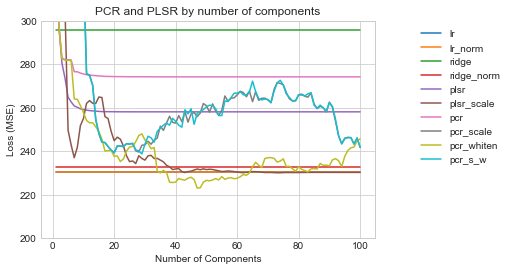

In [26]:
fig, ax = plt.subplots()
ax.set_xlabel("Number of Components")
ax.set_ylabel("Loss (MSE)")
ax.set_title("PCR and PLSR by number of components")

series_labels = scores_df_lr['model'].unique()
for name in series_labels:
    subset = scores_df_lr[scores_df_lr["model"]==name]
    y = [subset["MSE"].tolist()[0] for _ in n_comps]
    x = n_comps
    ax.plot(x,y,label = f"{name}")

series_labels = scores_df_pls['model'].unique()
for name in series_labels:
    subset = scores_df_pls[scores_df_pls["model"]==name]
    ax.plot(subset["n_comp"],subset["MSE"],label = f"{name}")

series_labels = scores_df_pcr['model'].unique()
for name in series_labels:
    subset = scores_df_pcr[scores_df_pcr["model"]==name]
    ax.plot(subset["n_comp"],subset["MSE"],label = f"{name}")

ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
plt.savefig(log_dir / f"mse_plot.png",bbox_inches='tight')

ax.set_ylim(200,300)
#ax.set_ylim(0,5*min_value)
plt.savefig(log_dir / f"mse_plot_compressed.png",bbox_inches='tight')




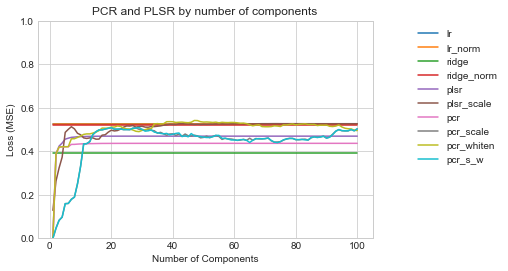

In [21]:
fig, ax = plt.subplots()
ax.set_xlabel("Number of Components")
ax.set_ylabel("Loss (MSE)")
ax.set_title("PCR and PLSR by number of components")

series_labels = scores_df_lr['model'].unique()
for name in series_labels:
    subset = scores_df_lr[scores_df_lr["model"]==name]
    y = [subset["R2"].tolist()[0] for _ in n_comps]
    x = n_comps
    ax.plot(x,y,label = f"{name}")

series_labels = scores_df_pls['model'].unique()
for name in series_labels:
    subset = scores_df_pls[scores_df_pls["model"]==name]
    ax.plot(subset["n_comp"],subset["R2"],label = f"{name}")

series_labels = scores_df_pcr['model'].unique()
for name in series_labels:
    subset = scores_df_pcr[scores_df_pcr["model"]==name]
    ax.plot(subset["n_comp"],subset["R2"],label = f"{name}")

ax.set_ylim(0,1)
ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
plt.savefig(log_dir / f"r2_plot.png",bbox_inches='tight')

